# Global Explainer - ETN

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:
from local_explanations import *
import utils
import models

import matplotlib.pyplot as plt
import matplotlib.cm as cm

import os
import numpy as np
import wandb
import networkx as nx
from networkx.algorithms import isomorphism
from networkx.generators import classic

import torch
from torch_geometric.nn import GAE, VGAE, GCNConv
import torch_geometric.transforms as T
from torch_geometric.data import InMemoryDataset, download_url, Data
from torch_geometric.utils import from_networkx, to_networkx
from torch_geometric.loader import DataLoader
from tqdm.notebook import tqdm
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import pickle

from sklearn.model_selection import train_test_split
from sklearn.metrics import silhouette_samples, silhouette_score, accuracy_score

import copy
import random
from scipy.stats import hmean

from collections import defaultdict
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool, global_add_pool, global_max_pool, GATConv, GINConv
from torch_scatter import scatter
import torch_explain as te
from torch_explain.logic.nn import entropy
from torch_explain.logic.metrics import test_explanation, complexity, test_explanations
from torch_geometric.datasets import MNISTSuperpixels


%load_ext autoreload
%autoreload 2

In [34]:
adjs_train , \
edge_weights_train , \
ori_adjs_train , \
ori_classes_train , \
belonging_train , \
summary_predictions_train , \
le_classes_train ,\
embeddings_train = read_etn(split="TRAIN", priori_annotation=True)

print(np.unique(le_classes_train, return_counts=True))
print(len(adjs_train) , len(edge_weights_train), len(ori_adjs_train) , len(ori_classes_train) , len(belonging_train))
np.unique(summary_predictions_train["wrong"], return_counts=True) , np.unique(summary_predictions_train["correct"], return_counts=True)

[]
defaultdict(<class 'int'>, {'{2}': 26, '{1, 2, 3}': 9, '{0, 1, 3}': 10, '{0, 2, 3}': 11, '{0, 2}': 25, '{1, 2}': 4, '{0, 1, 2}': 5})
(array([0, 1, 2, 3, 4, 5, 6, 7]), array([273, 139,  32,  51,  65,  58,  42,  90], dtype=int64))
750 750 750 750 750


((array([], dtype=float64), array([], dtype=int64)),
 (array([0, 1]), array([704, 704], dtype=int64)))

In [35]:
adjs_val , \
edge_weights_val , \
ori_adjs_val , \
ori_classes_val , \
belonging_val , \
summary_predictions_val , \
le_classes_val ,\
embeddings_val = read_etn(split="VAL", priori_annotation=True)

print(np.unique(le_classes_val, return_counts=True))
print(len(adjs_val) , len(edge_weights_val), len(ori_adjs_val) , len(ori_classes_val) , len(belonging_val))
np.unique(summary_predictions_val["wrong"], return_counts=True) , np.unique(summary_predictions_val["correct"], return_counts=True)

[]
defaultdict(<class 'int'>, {'{2}': 6, '{1, 2, 3}': 1, '{0, 1, 3}': 1, '{0, 2}': 6, '{1, 2}': 1})
(array([0, 1, 2, 3, 4, 5, 6, 7]), array([20,  9,  2,  7, 12,  6,  2, 15], dtype=int64))
73 73 73 73 73


((array([], dtype=float64), array([], dtype=int64)),
 (array([0, 1]), array([70, 70], dtype=int64)))

In [36]:
adjs_test , \
edge_weights_test , \
ori_adjs_test , \
ori_classes_test , \
belonging_test , \
summary_predictions_test , \
le_classes_test ,\
embeddings_test = read_etn(split="TEST", priori_annotation=True)

print(np.unique(le_classes_test, return_counts=True))
print(len(adjs_test) , len(edge_weights_test), len(ori_adjs_test) , len(ori_classes_test) , len(belonging_test))
np.unique(summary_predictions_test["wrong"], return_counts=True) , np.unique(summary_predictions_test["correct"], return_counts=True)

[]
defaultdict(<class 'int'>, {'{2}': 1, '{1, 2, 3}': 1, '{0, 2}': 6, '{0, 1, 3}': 3, '{0, 1, 2}': 1, '{1, 2}': 2})
(array([0, 1, 2, 3, 4, 5, 6, 7]), array([38, 18,  4, 10, 14,  9,  8, 14], dtype=int64))
115 115 115 115 115


((array([], dtype=float64), array([], dtype=int64)),
 (array([0, 1]), array([106, 106], dtype=int64)))

### Dataset

In [37]:
def convert_labels(g):
    new_dict = dict()
    for n,x in dict(nx.get_node_attributes(g,"x")).items():
        if x[0]==1:
            new_dict[n]="D"
        if x[1]==1:
            new_dict[n]="P"
        if x[2]==1:
            new_dict[n]="A"
        if x[3]==1:
            new_dict[n]="N"
        if x[4]==1:
            new_dict[n]="Ego"
    return new_dict

def plot_etn(data):
    G = to_networkx(data, node_attrs=["x"])
    pos = nx.kamada_kawai_layout(G)
    nx.draw(G, pos)
    nx.draw_networkx_labels(G, pos, {k:v for k,v in convert_labels(G).items() if k in G.nodes()}, font_size=20, font_color="red")

C:\Users\Steve\Desktop\GNN\gnn_logic_global_expl\code\utils.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(precomputed_embeddings[i])
C:\Users\Steve\Desktop\GNN\gnn_logic_global_expl\code\utils.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_attr=torch.tensor(t.weight).reshape(-1, 1),


(array([0, 1, 2, 3, 4, 5, 6, 7]), array([273, 139,  32,  51,  65,  58,  42,  90], dtype=int64))
(tensor([0, 1]), tensor([320, 430]))


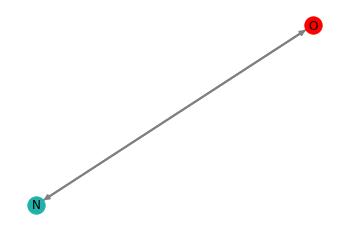

(18, tensor([18]))

In [38]:
device = "cpu" #torch.device('cuda' if torch.cuda.is_available() else 'cpu')
transform = None  

dataset_train = utils.LocalExplanationsDataset("", adjs_train, edge_weights_train, "embeddings", transform=transform, y=le_classes_train, belonging=belonging_train, task_y=ori_classes_train, precomputed_embeddings=embeddings_train)
dataset_val = utils.LocalExplanationsDataset("", adjs_val, edge_weights_val, "embeddings", transform=transform, y=le_classes_val, belonging=belonging_val, task_y=ori_classes_val, precomputed_embeddings=embeddings_val)
dataset_test = utils.LocalExplanationsDataset("", adjs_test, edge_weights_test, "embeddings", transform=transform, y=le_classes_test, belonging=belonging_test, task_y=ori_classes_test, precomputed_embeddings=embeddings_test)


##
# debug Dataset
##
print(np.unique(le_classes_train, return_counts=True))
print(torch.unique(dataset_train.data.task_y, return_counts=True))
idx = 18
utils.plot_molecule(dataset_train[idx])
belonging_train[idx] , dataset_train[idx].graph_id

(array([0., 1., 2., 3., 4., 5., 6., 7.], dtype=float32), array([273, 139,  32,  51,  65,  58,  42,  90], dtype=int64))


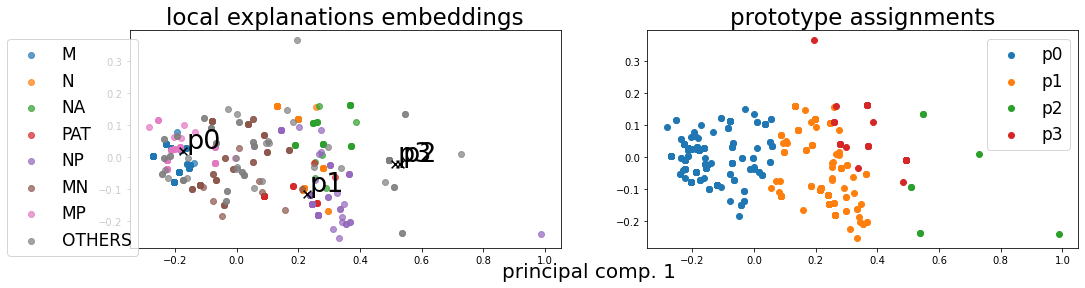

Alpha norms:
tensor([[1.0000, 0.3365, 0.4938, 0.4587],
        [0.8763, 1.0000, 0.6165, 0.7133]], grad_fn=<DivBackward0>)
Concept Purity: 0.658349 +- 0.142193
Concept distribution:  (array([0, 1, 2, 3], dtype=int64), array([405, 287,   8,  50], dtype=int64))
Logic formulas:
For class 0:
0.8946666666666667 (feature003) | ((feature001) | (feature002)
For class 1:
0.8946666666666667 (feature000)
Accuracy as classifier:  0.8947
LEN fidelity:  tensor(0.8947)

(array([0., 1., 2., 3., 4., 5., 6., 7.], dtype=float32), array([273, 139,  32,  51,  65,  58,  42,  90], dtype=int64))


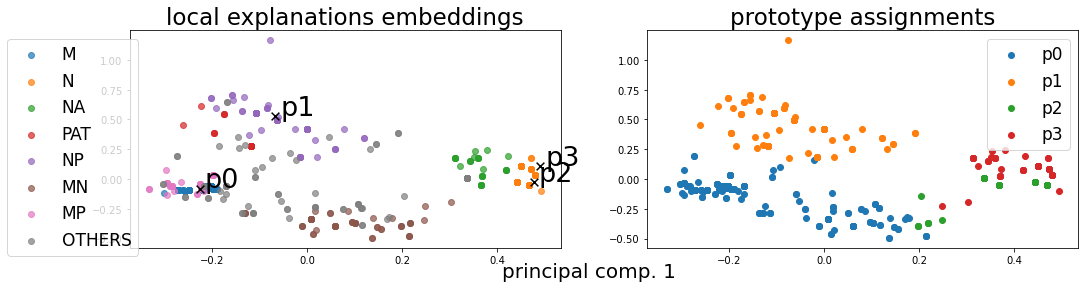

Alpha norms:
tensor([[1.0000, 0.3902, 0.2740, 0.7385],
        [1.0000, 0.3484, 0.2031, 0.4576]], grad_fn=<DivBackward0>)
Concept Purity: 0.599029 +- 0.102434
Concept distribution:  (array([0, 1, 2, 3], dtype=int64), array([413, 130, 151,  56], dtype=int64))
Logic formulas:
For class 0:
0.892 (feature001) | ((feature002) | (feature003)
For class 1:
0.892 (feature000)
Accuracy as classifier:  0.892
LEN fidelity:  tensor(0.8920)

(array([0., 1., 2., 3., 4., 5., 6., 7.], dtype=float32), array([273, 139,  32,  51,  65,  58,  42,  90], dtype=int64))


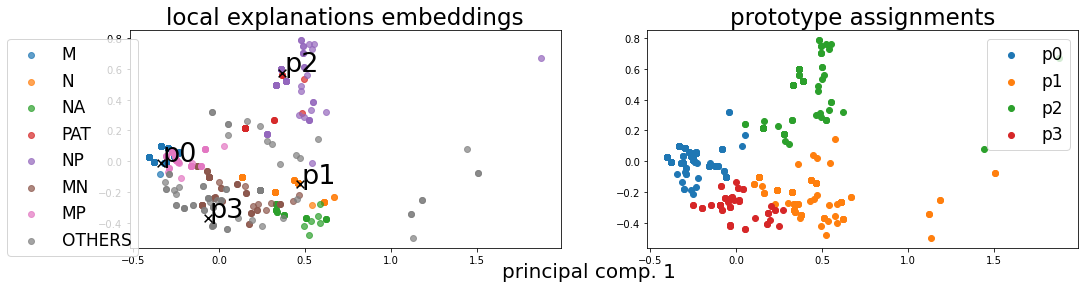

Alpha norms:
tensor([[0.9907, 0.7188, 1.0000, 0.3343],
        [1.0000, 0.5339, 0.7855, 0.1644]], grad_fn=<DivBackward0>)
Concept Purity: 0.620399 +- 0.108539
Concept distribution:  (array([0, 1, 2, 3], dtype=int64), array([342, 225, 122,  61], dtype=int64))
Logic formulas:
For class 0:
0.8893333333333333 (feature001) | (feature002)
For class 1:
0.8893333333333333 (feature000) | ((feature003)
Accuracy as classifier:  0.8893
LEN fidelity:  tensor(0.8893)

(array([0., 1., 2., 3., 4., 5., 6., 7.], dtype=float32), array([273, 139,  32,  51,  65,  58,  42,  90], dtype=int64))


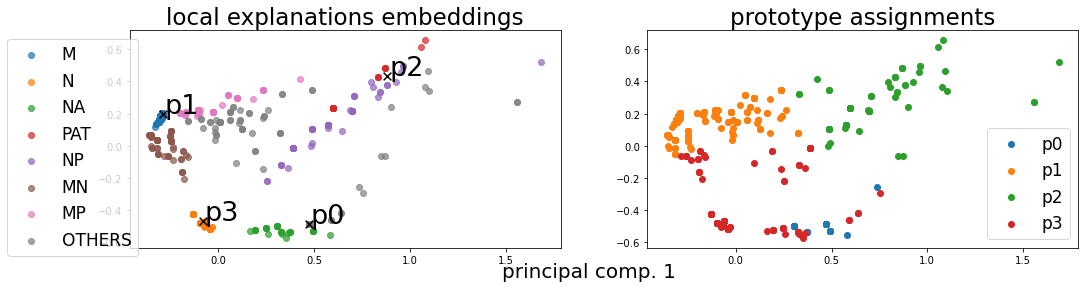

Alpha norms:
tensor([[0.5398, 1.0000, 0.4623, 0.6315],
        [0.7815, 1.0000, 0.9093, 0.7851]], grad_fn=<DivBackward0>)
Concept Purity: 0.622002 +- 0.098820
Concept distribution:  (array([0, 1, 2, 3], dtype=int64), array([ 42, 399, 112, 197], dtype=int64))
Logic formulas:
For class 0:
0.8733333333333333 (feature003) | ((feature002) | (feature000)
For class 1:
0.8733333333333333 (feature001)
Accuracy as classifier:  0.8733
LEN fidelity:  tensor(0.8733)

(array([0., 1., 2., 3., 4., 5., 6., 7.], dtype=float32), array([273, 139,  32,  51,  65,  58,  42,  90], dtype=int64))


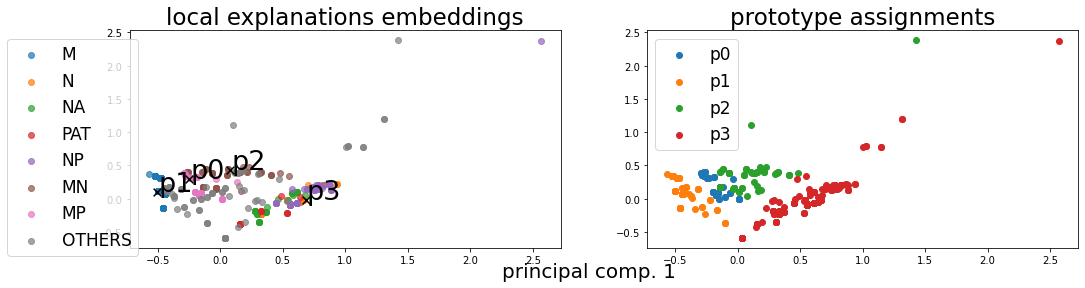

Alpha norms:
tensor([[0.7197, 0.9029, 0.2472, 1.0000],
        [0.5002, 1.0000, 0.0995, 0.4128]], grad_fn=<DivBackward0>)
Concept Purity: 0.708514 +- 0.178878
Concept distribution:  (array([0, 1, 2, 3], dtype=int64), array([ 55, 298,  68, 329], dtype=int64))
Logic formulas:
For class 0:
0.884 (feature003)
For class 1:
0.884 (feature001) | (feature000) | ((feature002)
Accuracy as classifier:  0.884
LEN fidelity:  tensor(0.8840)



In [39]:
batch_sampler = utils.GroupBatchSampler(num_input_graphs=128, drop_last=False, belonging=np.array(belonging_train))
train_group_loader = DataLoader(dataset_train, batch_sampler=batch_sampler)

batch_sampler = utils.GroupBatchSampler(num_input_graphs=256, drop_last=False, belonging=np.array(belonging_val))
val_group_loader = DataLoader(dataset_val, batch_sampler=batch_sampler)

batch_sampler = utils.GroupBatchSampler(num_input_graphs=256, drop_last=False, belonging=np.array(belonging_test))
test_group_loader = DataLoader(dataset_test, batch_sampler=batch_sampler)
    
for e in expls:
    e.inspect_embedding(train_group_loader)

In [40]:
sa = [0.8947, 0.8920, 0.8893, 0.8733, 0.8840]
np.mean(sa) , np.std(sa)

(0.88666, 0.007558994642146557)

## Train GLGExplainer

(array([0., 1., 2., 3., 4., 5., 6., 7.], dtype=float32), array([273, 139,  32,  51,  65,  58,  42,  90], dtype=int64))


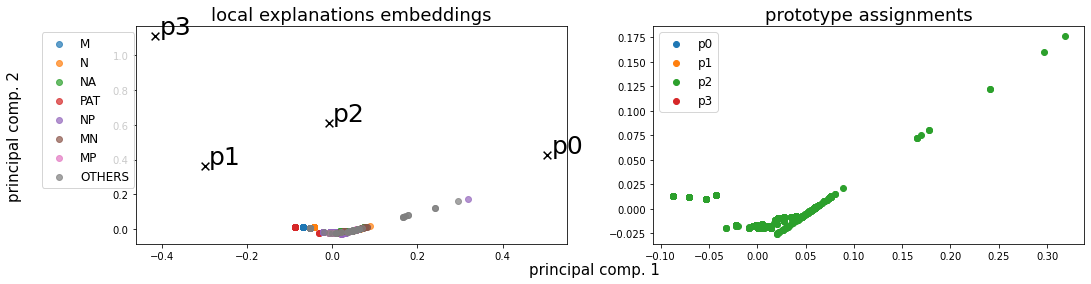

Alpha norms:
tensor([[1.0000, 0.8459, 0.8427, 0.9224],
        [0.8005, 0.7799, 1.0000, 0.8565]], grad_fn=<DivBackward0>)
Concept Purity: 0.364000 +- 0.000000
Concept distribution:  (array([2], dtype=int64), array([750], dtype=int64))
Logic formulas:
For class 0:
0.0 ()
For class 1:
0.0 ()
Accuracy as classifier:  0.0
LEN fidelity:  tensor(0.)

  1: Loss: 0.27936, LEN: 0.096436, AccxC: 0.57, AccO: 0.00, V. Acc: 0.00, V. Loss: 0.24028, V. LEN 0.10
  2: Loss: 0.22880, LEN: 0.095958, AccxC: 0.57, AccO: 0.00, V. Acc: 0.00, V. Loss: 0.20413, V. LEN 0.10
  3: Loss: 0.19641, LEN: 0.095704, AccxC: 0.58, AccO: 0.00, V. Acc: 0.00, V. Loss: 0.18034, V. LEN 0.10
  4: Loss: 0.17632, LEN: 0.096038, AccxC: 0.58, AccO: 0.00, V. Acc: 0.00, V. Loss: 0.17273, V. LEN 0.10
  5: Loss: 0.16546, LEN: 0.095490, AccxC: 0.58, AccO: 0.00, V. Acc: 0.00, V. Loss: 0.16448, V. LEN 0.10
  6: Loss: 0.16153, LEN: 0.094870, AccxC: 0.58, AccO: 0.00, V. Acc: 0.00, V. Loss: 0.15797, V. LEN 0.09
  7: Loss: 0.14867, LEN: 0.09

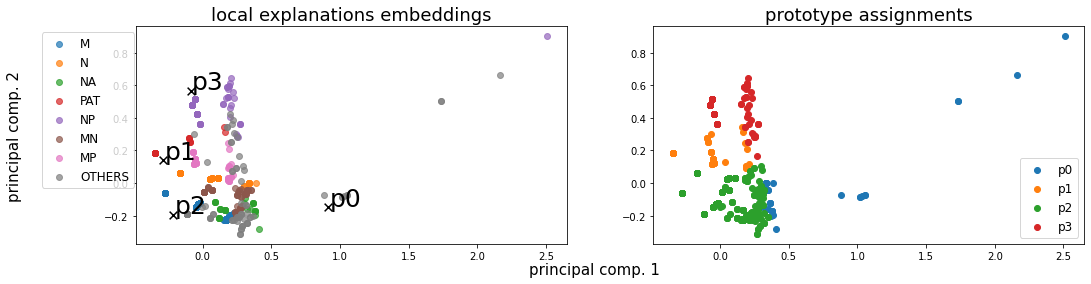

Alpha norms:
tensor([[0.8460, 0.5896, 1.0000, 0.7405],
        [1.0000, 0.7527, 0.9572, 0.7863]], grad_fn=<DivBackward0>)
Concept Purity: 0.580159 +- 0.188604
Concept distribution:  (array([0, 1, 2, 3], dtype=int64), array([ 34,  83, 559,  74], dtype=int64))
Logic formulas:
For class 0:
0.0 ()
For class 1:
0.0 ()
Accuracy as classifier:  0.0
LEN fidelity:  tensor(0.)


 20: Loss: 0.09537, LEN: 0.089084, AccxC: 0.61, AccO: 0.00, V. Acc: 0.00, V. Loss: 0.09460, V. LEN 0.09
 21: Loss: 0.09461, LEN: 0.088746, AccxC: 0.61, AccO: 0.00, V. Acc: 0.00, V. Loss: 0.09343, V. LEN 0.09
 22: Loss: 0.09362, LEN: 0.088432, AccxC: 0.61, AccO: 0.00, V. Acc: 0.00, V. Loss: 0.09233, V. LEN 0.09
 23: Loss: 0.09339, LEN: 0.088134, AccxC: 0.61, AccO: 0.00, V. Acc: 0.00, V. Loss: 0.09159, V. LEN 0.09
 24: Loss: 0.09132, LEN: 0.087764, AccxC: 0.61, AccO: 0.00, V. Acc: 0.00, V. Loss: 0.09069, V. LEN 0.09
 25: Loss: 0.09231, LEN: 0.087504, AccxC: 0.61, AccO: 0.00, V. Acc: 0.00, V. Loss: 0.09029, V. LEN 0.09
 26:

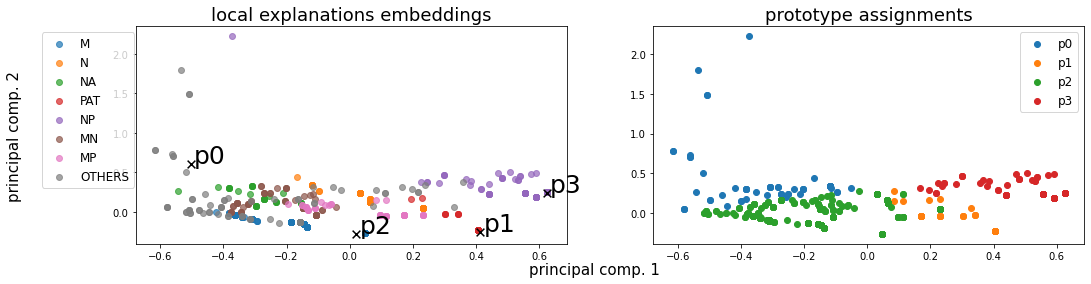

Alpha norms:
tensor([[0.7456, 0.3976, 1.0000, 0.5432],
        [1.0000, 0.5001, 0.8270, 0.6249]], grad_fn=<DivBackward0>)
Concept Purity: 0.634094 +- 0.210253
Concept distribution:  (array([0, 1, 2, 3], dtype=int64), array([ 58,  68, 554,  70], dtype=int64))
Logic formulas:
For class 0:
0.6986666666666667 (feature003) | ((feature001) | (feature000)
For class 1:
0.0 ()
Accuracy as classifier:  0.0
LEN fidelity:  tensor(0.5053)


 40: Loss: 0.08578, LEN: 0.083538, AccxC: 0.70, AccO: 0.51, V. Acc: 0.44, V. Loss: 0.08499, V. LEN 0.08
 41: Loss: 0.08378, LEN: 0.081863, AccxC: 0.76, AccO: 0.48, V. Acc: 0.44, V. Loss: 0.08447, V. LEN 0.08
 42: Loss: 0.08494, LEN: 0.083025, AccxC: 0.70, AccO: 0.51, V. Acc: 0.44, V. Loss: 0.08403, V. LEN 0.08
 43: Loss: 0.08433, LEN: 0.082667, AccxC: 0.70, AccO: 0.51, V. Acc: 0.44, V. Loss: 0.08399, V. LEN 0.08
 44: Loss: 0.08170, LEN: 0.080552, AccxC: 0.77, AccO: 0.49, V. Acc: 0.44, V. Loss: 0.08192, V. LEN 0.08
 45: Loss: 0.08185, LEN: 0.080594, AccxC: 0.76, 

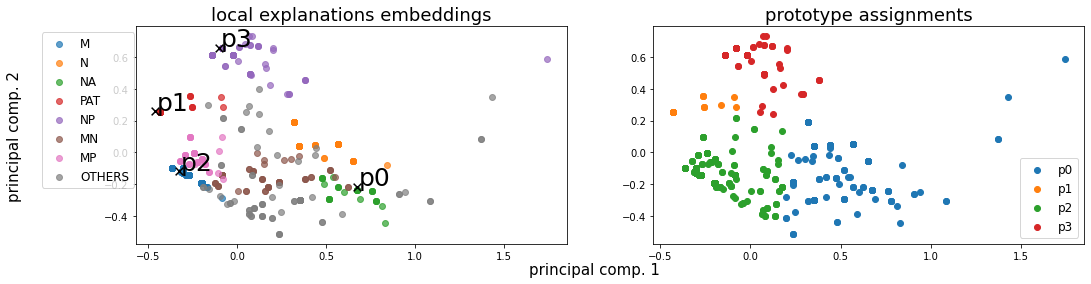

Alpha norms:
tensor([[0.6471, 0.3379, 1.0000, 0.5909],
        [1.0000, 0.3814, 0.5084, 0.5231]], grad_fn=<DivBackward0>)
Concept Purity: 0.799596 +- 0.169558
Concept distribution:  (array([0, 1, 2, 3], dtype=int64), array([245,  52, 385,  68], dtype=int64))
Logic formulas:
For class 0:
0.8626666666666667 (feature000) | ((feature001) | (feature003)
For class 1:
0.8626666666666667 (feature002)
Accuracy as classifier:  0.8627
LEN fidelity:  tensor(0.8627)


 60: Loss: 0.06698, LEN: 0.066430, AccxC: 0.87, AccO: 0.87, V. Acc: 0.85, V. Loss: 0.06842, V. LEN 0.07
 61: Loss: 0.06653, LEN: 0.066143, AccxC: 0.87, AccO: 0.87, V. Acc: 0.85, V. Loss: 0.06781, V. LEN 0.07
 62: Loss: 0.06576, LEN: 0.065391, AccxC: 0.87, AccO: 0.87, V. Acc: 0.86, V. Loss: 0.06576, V. LEN 0.07
 63: Loss: 0.06498, LEN: 0.064646, AccxC: 0.86, AccO: 0.86, V. Acc: 0.86, V. Loss: 0.06497, V. LEN 0.06
 64: Loss: 0.06375, LEN: 0.063447, AccxC: 0.87, AccO: 0.87, V. Acc: 0.86, V. Loss: 0.06418, V. LEN 0.06
 65: Loss: 0.06322, 

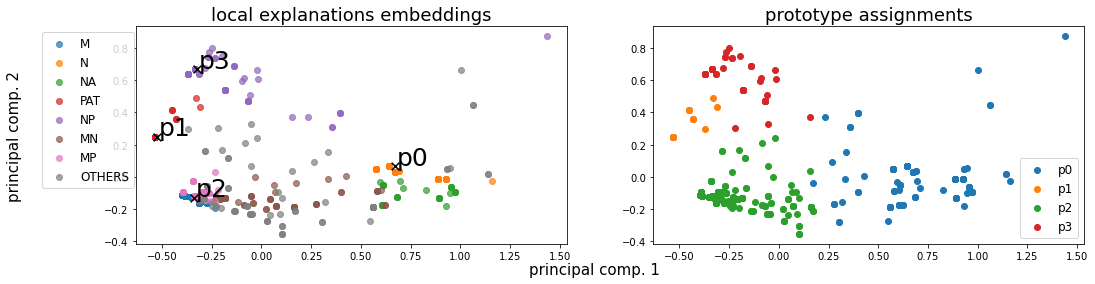

Alpha norms:
tensor([[0.8132, 0.4728, 1.0000, 0.5325],
        [1.0000, 0.2977, 0.3878, 0.3216]], grad_fn=<DivBackward0>)
Concept Purity: 0.804747 +- 0.171018
Concept distribution:  (array([0, 1, 2, 3], dtype=int64), array([232,  52, 406,  60], dtype=int64))
Logic formulas:
For class 0:
0.8826666666666667 (feature000) | ((feature001) | (feature003)
For class 1:
0.8826666666666667 (feature002)
Accuracy as classifier:  0.8827
LEN fidelity:  tensor(0.8827)


 80: Loss: 0.05248, LEN: 0.052403, AccxC: 0.88, AccO: 0.88, V. Acc: 0.86, V. Loss: 0.05548, V. LEN 0.06
 81: Loss: 0.05159, LEN: 0.051507, AccxC: 0.88, AccO: 0.88, V. Acc: 0.86, V. Loss: 0.05485, V. LEN 0.05
 82: Loss: 0.05073, LEN: 0.050654, AccxC: 0.88, AccO: 0.88, V. Acc: 0.86, V. Loss: 0.05402, V. LEN 0.05
 83: Loss: 0.05029, LEN: 0.050218, AccxC: 0.88, AccO: 0.88, V. Acc: 0.86, V. Loss: 0.05339, V. LEN 0.05
 84: Loss: 0.04963, LEN: 0.049570, AccxC: 0.88, AccO: 0.88, V. Acc: 0.86, V. Loss: 0.05294, V. LEN 0.05
 85: Loss: 0.04950, 

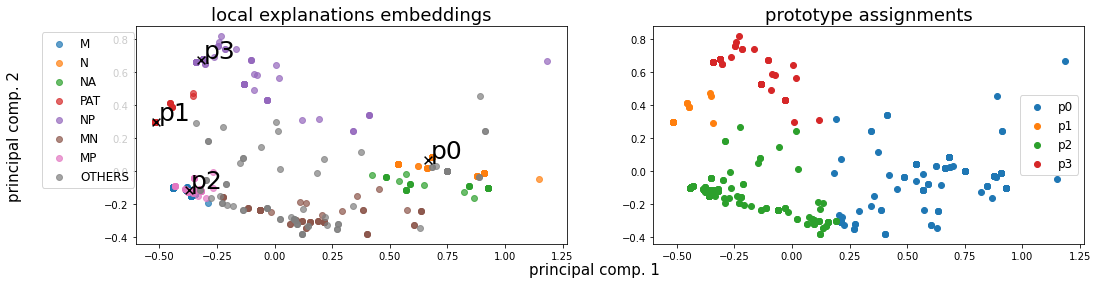

Alpha norms:
tensor([[0.7265, 0.5532, 1.0000, 0.6936],
        [1.0000, 0.3183, 0.4043, 0.3141]], grad_fn=<DivBackward0>)
Concept Purity: 0.806015 +- 0.181411
Concept distribution:  (array([0, 1, 2, 3], dtype=int64), array([245,  52, 394,  59], dtype=int64))
Logic formulas:
For class 0:
0.8773333333333333 (feature000) | ((feature001) | (feature003)
For class 1:
0.8773333333333333 (feature002)
Accuracy as classifier:  0.8773
LEN fidelity:  tensor(0.8773)


100: Loss: 0.04691, LEN: 0.046822, AccxC: 0.89, AccO: 0.89, V. Acc: 0.85, V. Loss: 0.05415, V. LEN 0.05
101: Loss: 0.04691, LEN: 0.046819, AccxC: 0.88, AccO: 0.88, V. Acc: 0.86, V. Loss: 0.05155, V. LEN 0.05
102: Loss: 0.04823, LEN: 0.048032, AccxC: 0.88, AccO: 0.88, V. Acc: 0.86, V. Loss: 0.05069, V. LEN 0.05
103: Loss: 0.04790, LEN: 0.047739, AccxC: 0.88, AccO: 0.88, V. Acc: 0.86, V. Loss: 0.05158, V. LEN 0.05
104: Loss: 0.04711, LEN: 0.046994, AccxC: 0.88, AccO: 0.88, V. Acc: 0.86, V. Loss: 0.05059, V. LEN 0.05
105: Loss: 0.04781, 

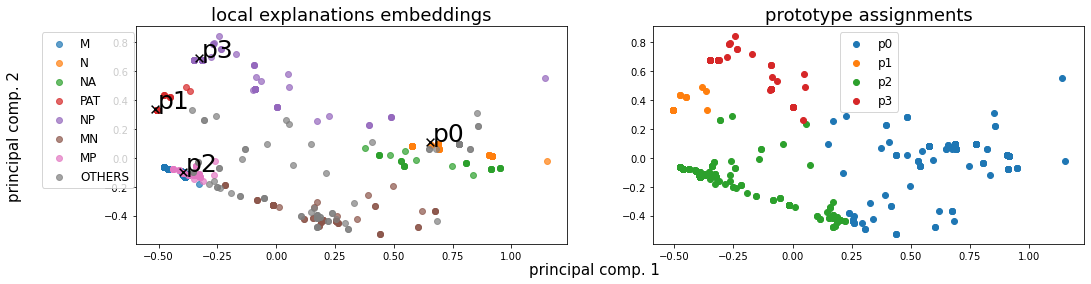

Alpha norms:
tensor([[0.6096, 0.5837, 1.0000, 0.7575],
        [1.0000, 0.4051, 0.4701, 0.4036]], grad_fn=<DivBackward0>)
Concept Purity: 0.804993 +- 0.183570
Concept distribution:  (array([0, 1, 2, 3], dtype=int64), array([249,  52, 391,  58], dtype=int64))
Logic formulas:
For class 0:
0.8786666666666667 (feature000) | ((feature001) | (feature003)
For class 1:
0.8786666666666667 (feature002)
Accuracy as classifier:  0.8787
LEN fidelity:  tensor(0.8787)


120: Loss: 0.04736, LEN: 0.047228, AccxC: 0.88, AccO: 0.88, V. Acc: 0.86, V. Loss: 0.05066, V. LEN 0.05
121: Loss: 0.04759, LEN: 0.047454, AccxC: 0.88, AccO: 0.88, V. Acc: 0.86, V. Loss: 0.05183, V. LEN 0.05
122: Loss: 0.04629, LEN: 0.046171, AccxC: 0.88, AccO: 0.88, V. Acc: 0.86, V. Loss: 0.05061, V. LEN 0.05
123: Loss: 0.04728, LEN: 0.047183, AccxC: 0.88, AccO: 0.88, V. Acc: 0.88, V. Loss: 0.04761, V. LEN 0.05
124: Loss: 0.04586, LEN: 0.045746, AccxC: 0.89, AccO: 0.89, V. Acc: 0.86, V. Loss: 0.05025, V. LEN 0.05
125: Loss: 0.04714, 

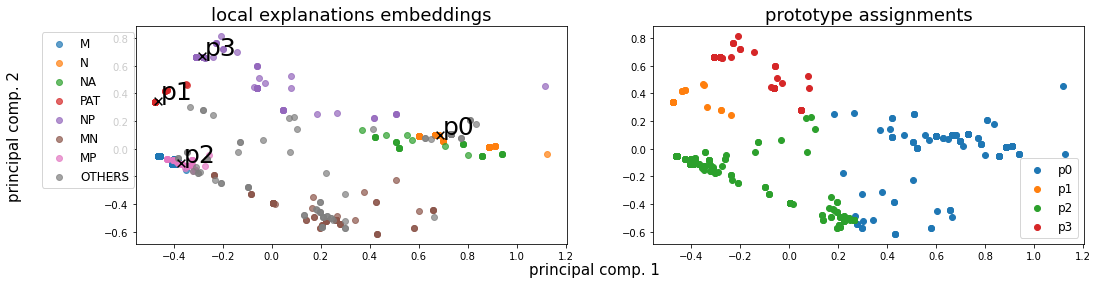

Alpha norms:
tensor([[0.5654, 0.5944, 1.0000, 0.8172],
        [1.0000, 0.4572, 0.5154, 0.4937]], grad_fn=<DivBackward0>)
Concept Purity: 0.798452 +- 0.170760
Concept distribution:  (array([0, 1, 2, 3], dtype=int64), array([238,  55, 400,  57], dtype=int64))
Logic formulas:
For class 0:
0.888 (feature001) | ((feature000) | (feature003)
For class 1:
0.888 (feature002)
Accuracy as classifier:  0.888
LEN fidelity:  tensor(0.8880)


140: Loss: 0.04695, LEN: 0.046826, AccxC: 0.88, AccO: 0.88, V. Acc: 0.88, V. Loss: 0.04771, V. LEN 0.05
141: Loss: 0.04587, LEN: 0.045747, AccxC: 0.88, AccO: 0.88, V. Acc: 0.86, V. Loss: 0.05025, V. LEN 0.05
142: Loss: 0.04778, LEN: 0.047651, AccxC: 0.88, AccO: 0.88, V. Acc: 0.86, V. Loss: 0.05194, V. LEN 0.05
143: Loss: 0.04580, LEN: 0.045698, AccxC: 0.89, AccO: 0.89, V. Acc: 0.86, V. Loss: 0.05025, V. LEN 0.05
144: Loss: 0.04604, LEN: 0.045934, AccxC: 0.88, AccO: 0.88, V. Acc: 0.88, V. Loss: 0.04769, V. LEN 0.05
145: Loss: 0.04629, LEN: 0.046168, AccxC: 0.88,

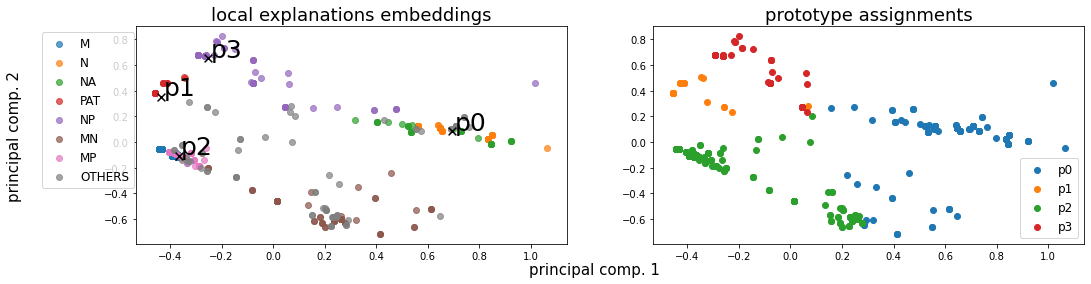

Alpha norms:
tensor([[0.5688, 0.5977, 1.0000, 0.8630],
        [1.0000, 0.4436, 0.5094, 0.5333]], grad_fn=<DivBackward0>)
Concept Purity: 0.791649 +- 0.160019
Concept distribution:  (array([0, 1, 2, 3], dtype=int64), array([234,  56, 402,  58], dtype=int64))
Logic formulas:
For class 0:
0.888 (feature001) | ((feature000) | (feature003)
For class 1:
0.888 (feature002)
Accuracy as classifier:  0.888
LEN fidelity:  tensor(0.8880)


160: Loss: 0.04752, LEN: 0.047393, AccxC: 0.88, AccO: 0.88, V. Acc: 0.86, V. Loss: 0.05197, V. LEN 0.05
161: Loss: 0.04629, LEN: 0.046142, AccxC: 0.88, AccO: 0.88, V. Acc: 0.85, V. Loss: 0.05468, V. LEN 0.05
162: Loss: 0.04614, LEN: 0.046017, AccxC: 0.88, AccO: 0.88, V. Acc: 0.86, V. Loss: 0.05022, V. LEN 0.05
163: Loss: 0.04659, LEN: 0.046451, AccxC: 0.88, AccO: 0.88, V. Acc: 0.86, V. Loss: 0.05195, V. LEN 0.05
164: Loss: 0.04730, LEN: 0.047082, AccxC: 0.88, AccO: 0.88, V. Acc: 0.85, V. Loss: 0.05478, V. LEN 0.05
165: Loss: 0.04474, LEN: 0.043833, AccxC: 0.89,

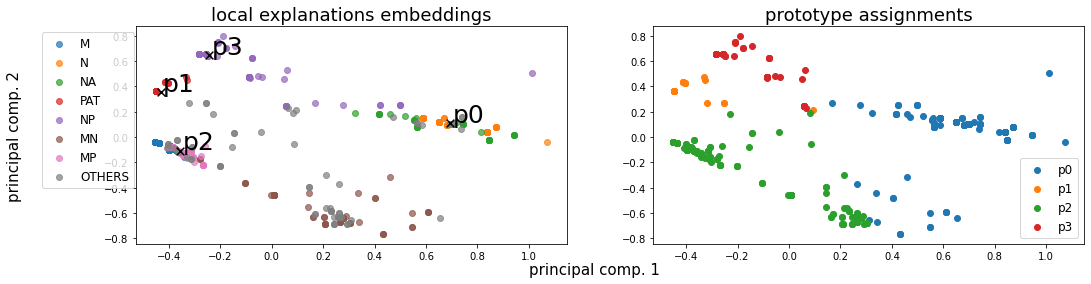

Alpha norms:
tensor([[0.5624, 0.6005, 1.0000, 0.8723],
        [1.0000, 0.4372, 0.5109, 0.5639]], grad_fn=<DivBackward0>)
Concept Purity: 0.796044 +- 0.162115
Concept distribution:  (array([0, 1, 2, 3], dtype=int64), array([231,  55, 406,  58], dtype=int64))
Logic formulas:
For class 0:
0.888 (feature001) | ((feature000) | (feature003)
For class 1:
0.888 (feature002)
Accuracy as classifier:  0.888
LEN fidelity:  tensor(0.8880)


180: Loss: 0.04696, LEN: 0.046841, AccxC: 0.88, AccO: 0.88, V. Acc: 0.86, V. Loss: 0.05194, V. LEN 0.05
181: Loss: 0.04684, LEN: 0.046692, AccxC: 0.88, AccO: 0.88, V. Acc: 0.85, V. Loss: 0.05307, V. LEN 0.05
182: Loss: 0.04643, LEN: 0.046137, AccxC: 0.88, AccO: 0.88, V. Acc: 0.86, V. Loss: 0.05198, V. LEN 0.05
183: Loss: 0.04569, LEN: 0.045517, AccxC: 0.89, AccO: 0.89, V. Acc: 0.88, V. Loss: 0.04767, V. LEN 0.05
184: Loss: 0.04640, LEN: 0.046249, AccxC: 0.89, AccO: 0.89, V. Acc: 0.88, V. Loss: 0.04766, V. LEN 0.05
185: Loss: 0.04769, LEN: 0.047564, AccxC: 0.88,

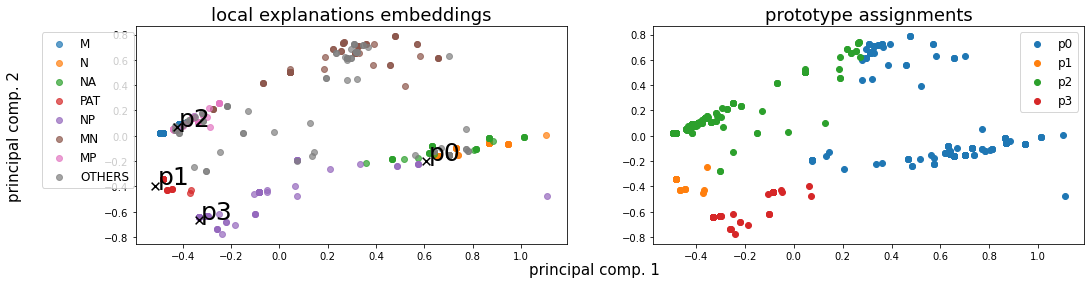

Alpha norms:
tensor([[0.5726, 0.6055, 1.0000, 0.9163],
        [1.0000, 0.4248, 0.5033, 0.6035]], grad_fn=<DivBackward0>)
Concept Purity: 0.804993 +- 0.201797
Concept distribution:  (array([0, 1, 2, 3], dtype=int64), array([274,  52, 373,  51], dtype=int64))
Logic formulas:
For class 0:
0.8706666666666667 (feature001) | ((feature000) | (feature003)
For class 1:
0.8706666666666667 (feature002)
Accuracy as classifier:  0.8707
LEN fidelity:  tensor(0.8707)


200: Loss: 0.04610, LEN: 0.045906, AccxC: 0.89, AccO: 0.89, V. Acc: 0.86, V. Loss: 0.04974, V. LEN 0.05
201: Loss: 0.04539, LEN: 0.045137, AccxC: 0.89, AccO: 0.89, V. Acc: 0.86, V. Loss: 0.05205, V. LEN 0.05
202: Loss: 0.04582, LEN: 0.045574, AccxC: 0.89, AccO: 0.89, V. Acc: 0.88, V. Loss: 0.04765, V. LEN 0.05
203: Loss: 0.04639, LEN: 0.046151, AccxC: 0.89, AccO: 0.89, V. Acc: 0.85, V. Loss: 0.05645, V. LEN 0.06
204: Loss: 0.04465, LEN: 0.044328, AccxC: 0.89, AccO: 0.89, V. Acc: 0.88, V. Loss: 0.04772, V. LEN 0.05
205: Loss: 0.04642, 

In [8]:
batch_sampler = utils.GroupBatchSampler(num_input_graphs=128, drop_last=False, belonging=np.array(belonging_train))
train_group_loader = DataLoader(dataset_train, batch_sampler=batch_sampler)

batch_sampler = utils.GroupBatchSampler(num_input_graphs=256, drop_last=False, belonging=np.array(belonging_val))
val_group_loader = DataLoader(dataset_val, batch_sampler=batch_sampler)

batch_sampler = utils.GroupBatchSampler(num_input_graphs=256, drop_last=False, belonging=np.array(belonging_test))
test_group_loader = DataLoader(dataset_test, batch_sampler=batch_sampler)



torch.manual_seed(42)
hyper = {
    "len_lr": 0.0005,
    "proto_lr": 0.001,
    "le_emb_lr": 0.001,
    "coeff_divloss": 0.000,
    "coeff_pdist": 0.,
    "coeff_gae": 0.,
    "coeff_r1": 0.09,
    "coeff_r2": 0.00099,
    "coeff_ce": 0.0,
    "coeff_de": 0.,
    "coeff_logic_loss": 0.00,
    "focal_gamma": 2, #3
    "focal_alpha": -1,
    "ts": 1,
    "te": 1,
    "focal_loss": True,
    "debug_prototypes": False,
    "num_prototypes": 4,
    "dim_prototypes": 10,
    "num_le_features": 5,
    "activation": "leaky",
    "embedder_backbone": "GAT",
    "embedder_num_layers": 5,
    "assign_func": "straight_sim",
    "LEN_temperature": 1,
    "remove_attention": True,
    "log_images": True,
    "log_models": True,
    "num_epochs": 500,
}

len_model    = models.LEN(hyper["num_prototypes"], 
                          hyper["LEN_temperature"], 
                          remove_attention=hyper["remove_attention"]).to(device)
le_model     = models.LEEmbedder(num_features=hyper["num_le_features"], 
                                 activation=hyper["activation"], 
                                 num_hidden=hyper["dim_prototypes"],
                                 backbone=hyper["embedder_backbone"],
                                 num_layers=hyper["embedder_num_layers"]).to(device)
expl         = models.GlobalExplainer(len_model, 
                               le_model, 
                               train_group_loader, 
                               val_group_loader, 
                               device, 
                               hyper_params=hyper,
                               classes_names=priori_etn_classes_names,
                               dataset_name="ETN").to(device)

prefix = "DEBUG" if hyper["debug_prototypes"] else ""
suffix = "no attn" if hyper["remove_attention"] else ""
expl.iterate(num_epochs=hyper["num_epochs"], log_wandb=False, name_wandb=f"MUTAG {hyper['num_prototypes']}prots {prefix} {suffix}")

In [14]:
x_train , emb , concepts_assignement , y_train_1h , le_classes , le_idxs , belonging = expl.get_concept_vector(train_group_loader, 
                                                                                                               return_raw=True)        

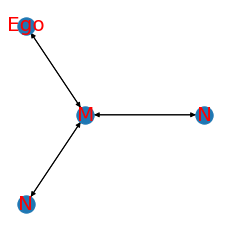

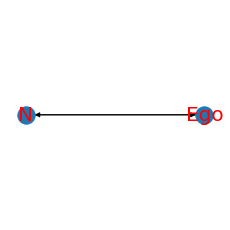

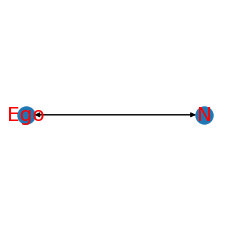

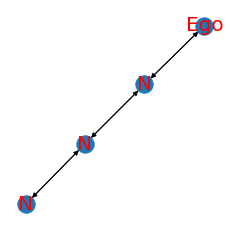

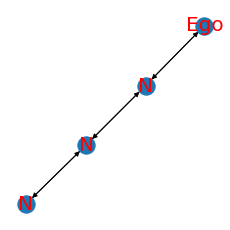

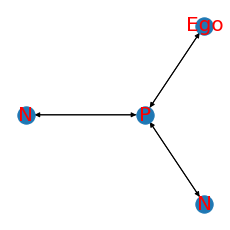

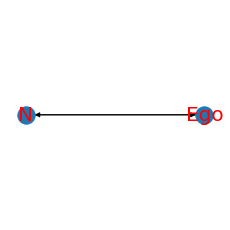

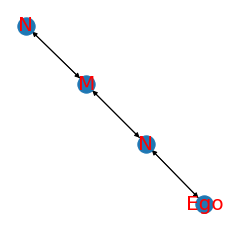

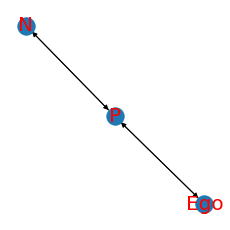

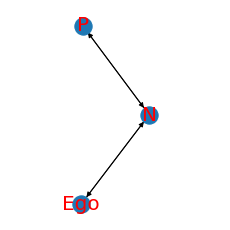

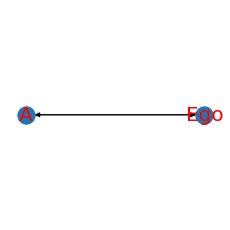

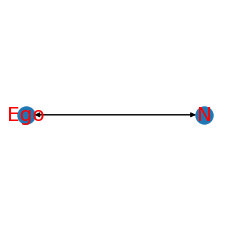

In [15]:
idxs = le_idxs[concepts_assignement.argmax(-1) == 0]
for idx in idxs[:12]: 
    plt.figure(figsize=(3,3))
    plot_etn(dataset_train[int(idx)])
    plt.show()

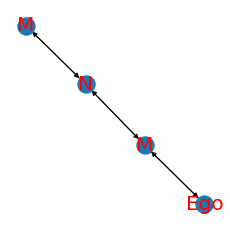

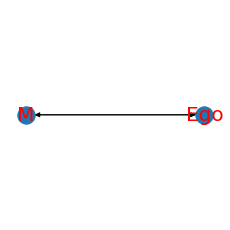

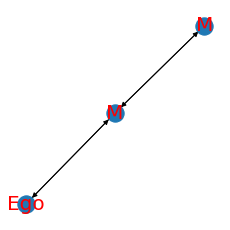

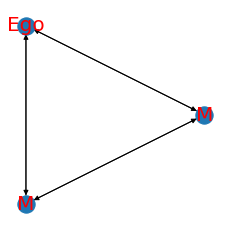

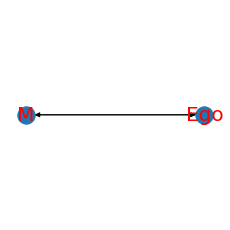

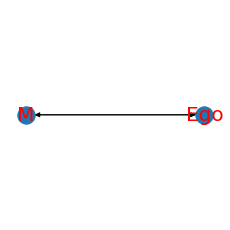

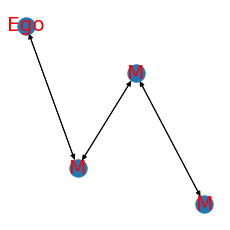

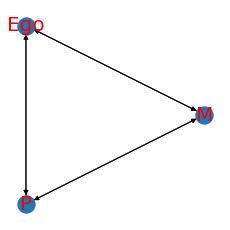

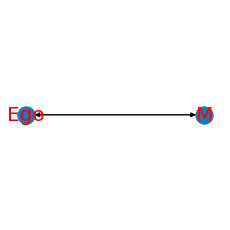

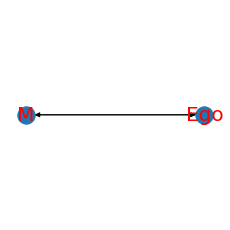

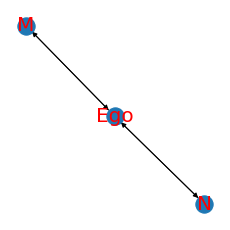

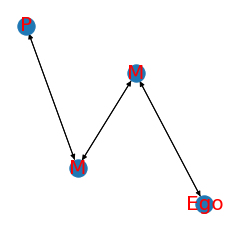

In [16]:
idxs = le_idxs[concepts_assignement.argmax(-1) == 1]
for idx in idxs[:12]: 
    plt.figure(figsize=(3,3))
    plot_etn(dataset_train[int(idx)])
    plt.show()

(array([0., 1., 2., 3., 4., 5., 6., 7.], dtype=float32), array([273, 139,  32,  51,  65,  58,  42,  90], dtype=int64))


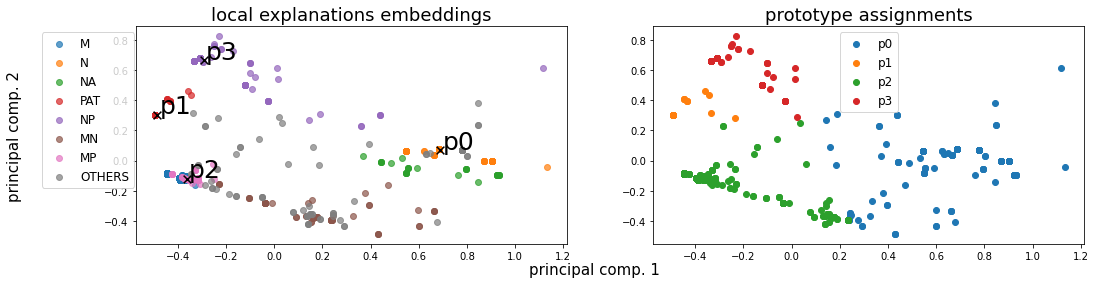

Alpha norms:
tensor([[0.6428, 0.5790, 1.0000, 0.7306],
        [1.0000, 0.3748, 0.4458, 0.3668]], grad_fn=<DivBackward0>)
Concept Purity: 0.801765 +- 0.175530
Concept distribution:  (array([0, 1, 2, 3], dtype=int64), array([242,  53, 397,  58], dtype=int64))
Logic formulas:
For class 0:
0.8866666666666667 (feature000) | ((feature001) | (feature003)
For class 1:
0.8866666666666667 (feature002)
Accuracy as classifier:  0.8867
LEN fidelity:  tensor(0.8867)



In [10]:
expl.inspect_embedding(train_group_loader)

In [ ]:
batch_sampler = utils.GroupBatchSampler(num_input_graphs=128, drop_last=False, belonging=np.array(belonging_train))
train_group_loader = DataLoader(dataset_train, batch_sampler=batch_sampler)

batch_sampler = utils.GroupBatchSampler(num_input_graphs=256, drop_last=False, belonging=np.array(belonging_val))
val_group_loader = DataLoader(dataset_val, batch_sampler=batch_sampler)

batch_sampler = utils.GroupBatchSampler(num_input_graphs=256, drop_last=False, belonging=np.array(belonging_test))
test_group_loader = DataLoader(dataset_test, batch_sampler=batch_sampler)

torch.manual_seed(42)
hyper = {
    "len_lr": 0.0005,
    "proto_lr": 0.001,
    "le_emb_lr": 0.001,
    "coeff_divloss": 0.000,
    "coeff_pdist": 0.,
    "coeff_gae": 0.,
    "coeff_r1": 0.09,
    "coeff_r2": 0.00099,
    "coeff_ce": 0.0,
    "coeff_de": 0.,
    "coeff_logic_loss": 0.00,
    "focal_gamma": 2, #3
    "focal_alpha": -1,
    "ts": 1,
    "te": 1,
    "focal_loss": True,
    "debug_prototypes": False,
    "num_prototypes": 4,
    "dim_prototypes": 10,
    "num_le_features": 5,
    "activation": "leaky",
    "embedder_backbone": "GAT",
    "embedder_num_layers": 2,
    "assign_func": "straight_sim",
    "LEN_temperature": 1,
    "remove_attention": True,
    "log_images": True,
    "log_models": False,
    "num_epochs": 500
}

len_model    = models.LEN(hyper["num_prototypes"], 
                          hyper["LEN_temperature"], 
                          remove_attention=hyper["remove_attention"]).to(device)
le_model     = models.LEEmbedder(num_features=hyper["num_le_features"], 
                                 activation=hyper["activation"], 
                                 num_hidden=hyper["dim_prototypes"],
                                 backbone=hyper["embedder_backbone"],
                                 num_layers=hyper["embedder_num_layers"]).to(device)
expl4         = models.GlobalExplainer(len_model, 
                               le_model, 
                               train_group_loader, 
                               val_group_loader, 
                               device, 
                               hyper_params=hyper,
                               classes_names=priori_etn_classes_names,
                               dataset_name="ETN").to(device)

prefix = "DEBUG" if hyper["debug_prototypes"] else ""
suffix = "no attn" if hyper["remove_attention"] else ""
expl4.iterate(num_epochs=hyper["num_epochs"], log_wandb=False, name_wandb=f"ETN {hyper['num_prototypes']}prots {prefix} {suffix}")

## Inspect prototypes

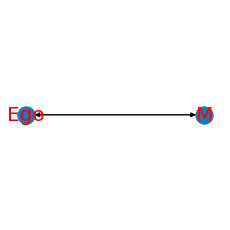

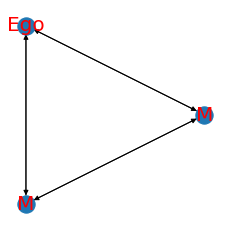

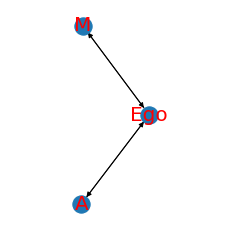

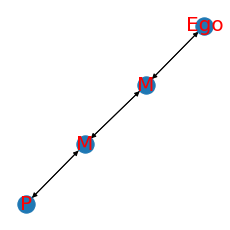

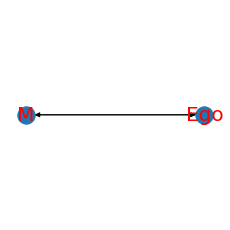

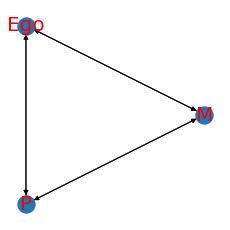

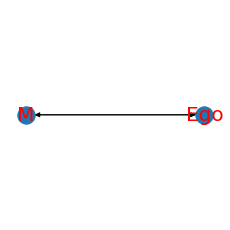

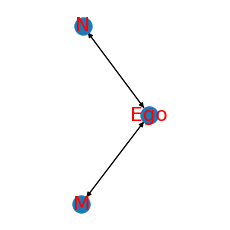

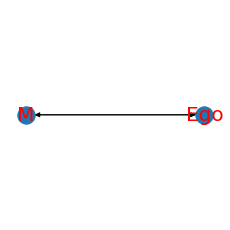

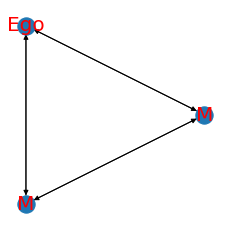

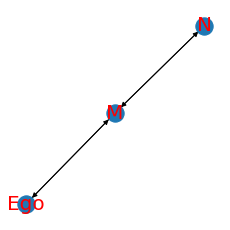

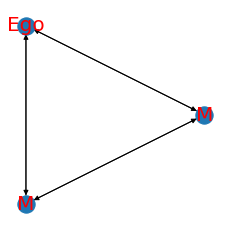

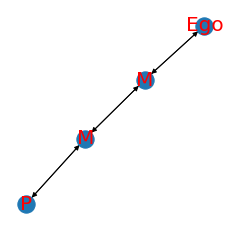

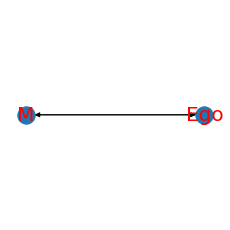

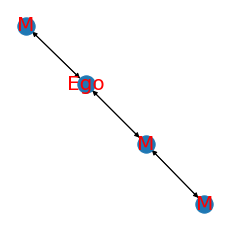

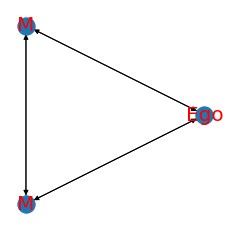

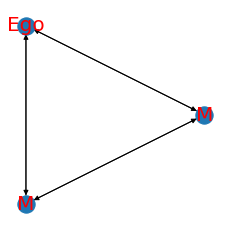

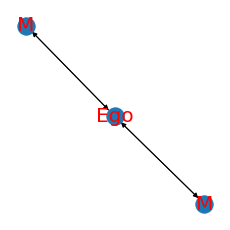

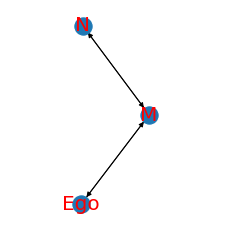

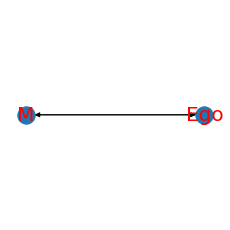

In [44]:
x_train , emb , concepts_assignement , y_train_1h , le_classes , le_idxs , belonging = expl4.get_concept_vector(train_group_loader, 
                                                                                                                return_raw=True)        

prototype_assignements = utils.prototype_assignement("sim", emb, expl4.prototype_vectors, temp=1)

proto = 1
idxs = le_idxs[prototype_assignements.argmax(-1) == proto]
argsort = torch.argsort(prototype_assignements[prototype_assignements.argmax(-1) == proto, proto], descending=True)
idxs = le_idxs[concepts_assignement.argmax(-1) == proto]
for idx in idxs[:20]: 
    plt.figure(figsize=(3,3))
    plot_etn(dataset_train[int(idx)])
    plt.show()

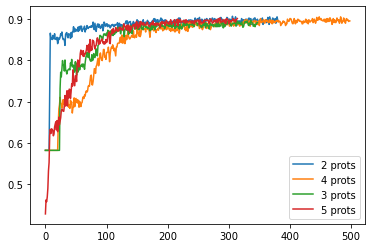

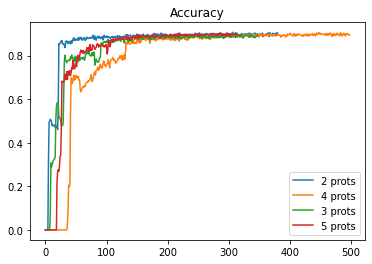

In [14]:
plt.plot([i["acc_per_class"] for i in expl.train_metrics], label="2 prots")
plt.plot([i["acc_per_class"] for i in expl4.train_metrics], label="4 prots")
plt.plot([i["acc_per_class"] for i in expl3.train_metrics], label="3 prots")
plt.plot([i["acc_per_class"] for i in expl5.train_metrics], label="5 prots")
plt.legend()
plt.show()

plt.plot([i["acc_overall"] for i in expl.train_metrics], label="2 prots")
plt.plot([i["acc_overall"] for i in expl4.train_metrics], label="4 prots")
plt.plot([i["acc_overall"] for i in expl3.train_metrics], label="3 prots")
plt.plot([i["acc_overall"] for i in expl5.train_metrics], label="5 prots")
plt.legend()
plt.title("Accuracy")
plt.show()

(array([0., 1., 2., 3., 4., 5., 6., 7.], dtype=float32), array([38, 18,  4, 10, 14,  9,  8, 14], dtype=int64))


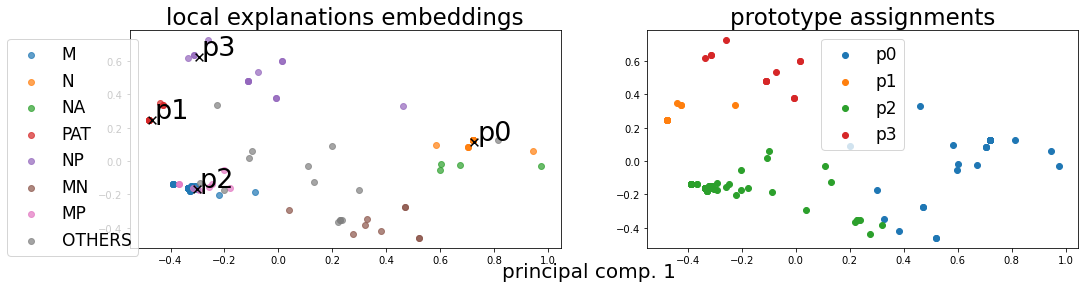

Alpha norms:
tensor([[0.6428, 0.5790, 1.0000, 0.7306],
        [1.0000, 0.3748, 0.4458, 0.3668]], grad_fn=<DivBackward0>)
Concept Purity: 0.778915 +- 0.180862
Concept distribution:  (array([0, 1, 2, 3], dtype=int64), array([32, 11, 59, 13], dtype=int64))
Logic formulas:
For class 0:
0.8434782608695652 (feature003) | (feature000) | ((feature001)
For class 1:
0.8434782608695652 (feature002)
Accuracy as classifier:  0.8435
LEN fidelity:  tensor(0.8435)



In [19]:
batch_sampler = utils.GroupBatchSampler(num_input_graphs=128, drop_last=False, belonging=np.array(belonging_train))
train_group_loader = DataLoader(dataset_train, batch_sampler=batch_sampler)

batch_sampler = utils.GroupBatchSampler(num_input_graphs=256, drop_last=False, belonging=np.array(belonging_val))
val_group_loader = DataLoader(dataset_val, batch_sampler=batch_sampler)

batch_sampler = utils.GroupBatchSampler(num_input_graphs=256, drop_last=False, belonging=np.array(belonging_test))
test_group_loader = DataLoader(dataset_test, batch_sampler=batch_sampler)

torch.manual_seed(42)
hyper = {
    "len_lr": 0.0005,
    "proto_lr": 0.001,
    "le_emb_lr": 0.001,
    "coeff_divloss": 0.000,
    "coeff_pdist": 0.,
    "coeff_gae": 0.,
    "coeff_r1": 0.09,
    "coeff_r2": 0.00099,
    "coeff_ce": 0.0,
    "coeff_de": 0.,
    "coeff_logic_loss": 0.00,
    "focal_gamma": 2, #3
    "focal_alpha": -1,
    "ts": 1,
    "te": 1,
    "focal_loss": True,
    "debug_prototypes": False,
    "num_prototypes": 4,
    "dim_prototypes": 10,
    "num_le_features": 5,
    "activation": "leaky",
    "embedder_backbone": "GAT",
    "embedder_num_layers": 5,
    "assign_func": "straight_sim",
    "LEN_temperature": 1,
    "remove_attention": True,
    "log_images": True,
    "log_models": False,
    "num_epochs": 500
}

len_model    = models.LEN(hyper["num_prototypes"], 
                          hyper["LEN_temperature"], 
                          remove_attention=hyper["remove_attention"]).to(device)
le_model     = models.LEEmbedder(num_features=hyper["num_le_features"], 
                                 activation=hyper["activation"], 
                                 num_hidden=hyper["dim_prototypes"],
                                 backbone=hyper["embedder_backbone"],
                                 num_layers=hyper["embedder_num_layers"]).to(device)
expl         = models.GlobalExplainer(len_model, 
                               le_model, 
                               train_group_loader, 
                               val_group_loader, 
                               device, 
                               hyper_params=hyper,
                               classes_names=priori_etn_classes_names,
                               dataset_name="ETN").to(device)
expl.load_state_dict(torch.load("../trained_models/ETN_allsamples.pt"))
expl.inspect_embedding(test_group_loader)

In [9]:
def plot_etn(data, ax=None):
    G = to_networkx(data, node_attrs=["x"], to_undirected=True)
    pos = nx.kamada_kawai_layout(G)
    nx.draw(G, pos, node_color="orange", node_size=400, ax=ax)
    nx.draw_networkx_labels(G, pos, {k:v for k,v in convert_labels(G).items() if k in G.nodes()}, font_size=18, font_color="black", ax=ax)

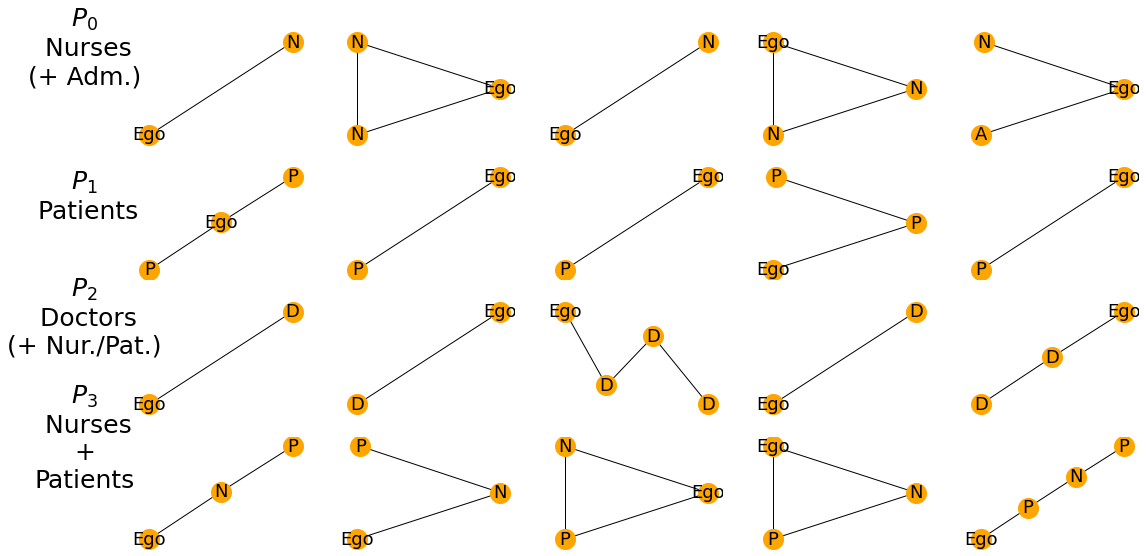

In [11]:
expl.eval()
x_train , emb , concepts_assignement , y_train_1h , le_classes , le_idxs , belonging = expl.get_concept_vector(test_group_loader, 
                                                                                                                    return_raw=True)        
proto_names = {
    0: "Nurses\n(+ Adm.)",
    1: "Patients",
    2: "Doctors\n(+ Nur./Pat.)",
    3: "Nurses\n+\nPatients",
}
torch.manual_seed(42)
fig = plt.figure(figsize=(18,5*1.9))
n = 0
for p in range(expl.hyper["num_prototypes"]):
    idxs = le_idxs[concepts_assignement.argmax(-1) == p]
    idxs = idxs[torch.randperm(len(idxs))]    
    for ex in range(5):
        n += 1
        ax = plt.subplot(expl.hyper["num_prototypes"],5,n)      
        #G = to_networkx(dataset_test[int(idxs[ex])], to_undirected=True)
        #pos = nx.spring_layout(G, seed=42)
        #nx.draw(G, pos, node_size=300, ax=ax, node_color="orange")
        plot_etn(dataset_test[int(idxs[ex])])
        ax.axis("on")
        plt.box(False)
        
for p in range(expl.hyper["num_prototypes"]):
    plt.subplot(expl.hyper["num_prototypes"],5,5*p + 1)
    plt.ylabel(f"$P_{p}$\n {proto_names[p]}", size=25, rotation="horizontal", labelpad=50)

plt.savefig("prototypes_etn.pdf")
plt.show() 

## Ablation study

(array([0., 1., 2., 3., 4., 5., 6., 7.], dtype=float32), array([266, 125,  31,  47,  63,  52,  41,  84], dtype=int64))


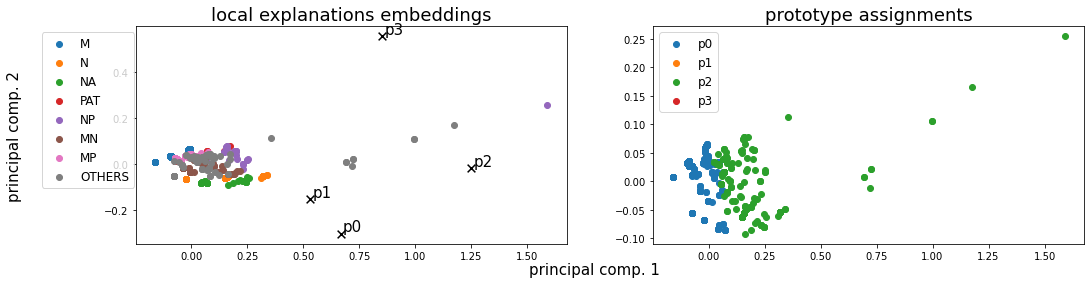

Alpha norms:
tensor([[1.0000, 0.8459, 0.8427, 0.9224],
        [0.8005, 0.7799, 1.0000, 0.8565]], grad_fn=<DivBackward0>)
Concept Purity: 0.394417 +- 0.104645
Concept distribution:  (array([0, 2], dtype=int64), array([533, 176], dtype=int64))
Logic formulas:
For class 0:
0.0 ()
For class 1:
0.0 ()
Accuracy as classifier:  0.0
LEN fidelity:  tensor(0.)

  1: Loss: 0.22246, LEN: 0.096762, AccxC: 0.30, AccO: 0.00, V. Acc: 0.00, V. Loss: 0.20840, V. LEN 0.10
  2: Loss: 0.21514, LEN: 0.096291, AccxC: 0.28, AccO: 0.00, V. Acc: 0.00, V. Loss: 0.20983, V. LEN 0.10
  3: Loss: 0.20560, LEN: 0.095711, AccxC: 0.48, AccO: 0.00, V. Acc: 0.00, V. Loss: 0.20737, V. LEN 0.10
  4: Loss: 0.20101, LEN: 0.095294, AccxC: 0.58, AccO: 0.00, V. Acc: 0.00, V. Loss: 0.19748, V. LEN 0.10
  5: Loss: 0.19050, LEN: 0.094765, AccxC: 0.58, AccO: 0.00, V. Acc: 0.00, V. Loss: 0.18406, V. LEN 0.09
  6: Loss: 0.17491, LEN: 0.094331, AccxC: 0.58, AccO: 0.00, V. Acc: 0.00, V. Loss: 0.16578, V. LEN 0.09
  7: Loss: 0.15923, L

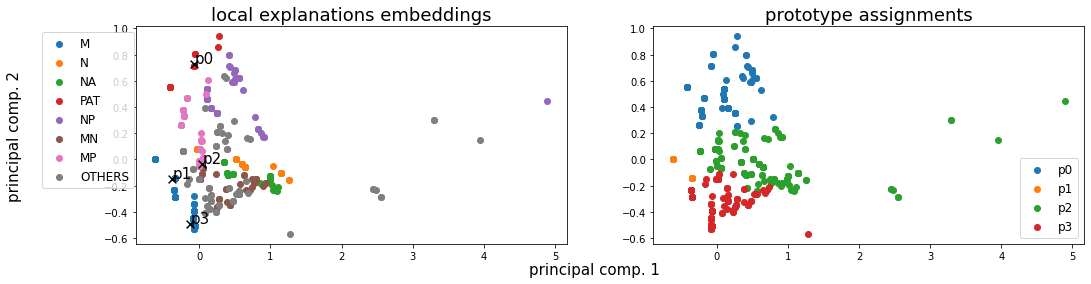

Alpha norms:
tensor([[0.9916, 0.7638, 0.8793, 1.0000],
        [0.8366, 0.8439, 1.0000, 0.9342]], grad_fn=<DivBackward0>)
Concept Purity: 0.653314 +- 0.224048
Concept distribution:  (array([0, 1, 2, 3], dtype=int64), array([132, 125, 249, 203], dtype=int64))
Logic formulas:
For class 0:
0.0 ()
For class 1:
0.0 ()
Accuracy as classifier:  0.0
LEN fidelity:  tensor(0.)


 20: Loss: 0.10346, LEN: 0.089073, AccxC: 0.58, AccO: 0.00, V. Acc: 0.00, V. Loss: 0.10227, V. LEN 0.09
 21: Loss: 0.10172, LEN: 0.088688, AccxC: 0.58, AccO: 0.00, V. Acc: 0.00, V. Loss: 0.09967, V. LEN 0.09
 22: Loss: 0.09912, LEN: 0.088282, AccxC: 0.58, AccO: 0.00, V. Acc: 0.00, V. Loss: 0.09705, V. LEN 0.09
 23: Loss: 0.09660, LEN: 0.087979, AccxC: 0.58, AccO: 0.00, V. Acc: 0.00, V. Loss: 0.09462, V. LEN 0.09
 24: Loss: 0.09448, LEN: 0.087476, AccxC: 0.58, AccO: 0.00, V. Acc: 0.00, V. Loss: 0.09264, V. LEN 0.09
 25: Loss: 0.09236, LEN: 0.087156, AccxC: 0.58, AccO: 0.00, V. Acc: 0.00, V. Loss: 0.09102, V. LEN 0.09
 26:

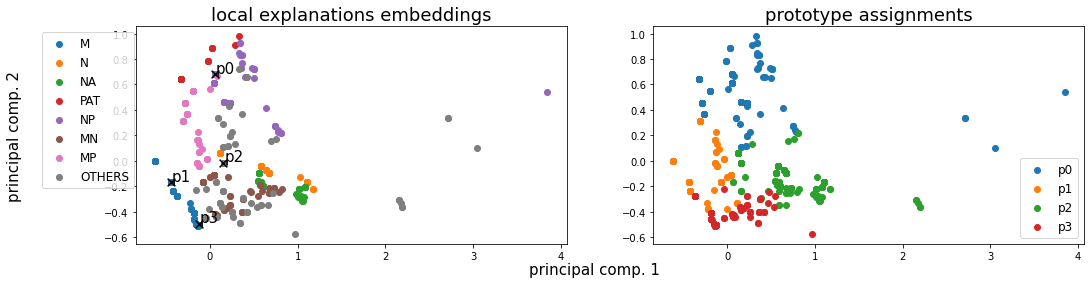

Alpha norms:
tensor([[0.7058, 0.8491, 0.7086, 1.0000],
        [0.6486, 1.0000, 0.7454, 0.8285]], grad_fn=<DivBackward0>)
Concept Purity: 0.629052 +- 0.138279
Concept distribution:  (array([0, 1, 2, 3], dtype=int64), array([144, 205, 214, 146], dtype=int64))
Logic formulas:
For class 0:
0.5726375176304654 (feature002) | ((feature000) | (feature001)
For class 1:
0.0 ()
Accuracy as classifier:  0.0
LEN fidelity:  tensor(0.1805)


 40: Loss: 0.08139, LEN: 0.080578, AccxC: 0.84, AccO: 0.12, V. Acc: 0.20, V. Loss: 0.08067, V. LEN 0.08
 41: Loss: 0.08043, LEN: 0.080035, AccxC: 0.84, AccO: 0.53, V. Acc: 0.68, V. Loss: 0.08003, V. LEN 0.08
 42: Loss: 0.07993, LEN: 0.079526, AccxC: 0.84, AccO: 0.76, V. Acc: 0.88, V. Loss: 0.07942, V. LEN 0.08
 43: Loss: 0.07909, LEN: 0.078740, AccxC: 0.84, AccO: 0.84, V. Acc: 0.88, V. Loss: 0.07875, V. LEN 0.08
 44: Loss: 0.07871, LEN: 0.078130, AccxC: 0.84, AccO: 0.84, V. Acc: 0.88, V. Loss: 0.07816, V. LEN 0.08
 45: Loss: 0.07810, LEN: 0.077727, AccxC: 0.84, 

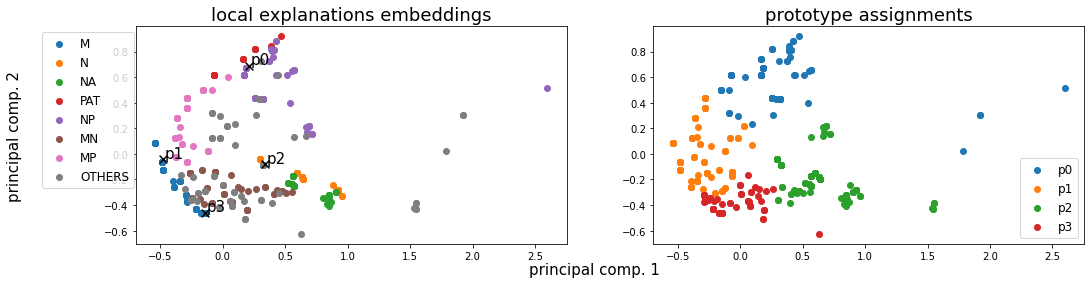

Alpha norms:
tensor([[0.3979, 1.0000, 0.6265, 0.8431],
        [0.3975, 1.0000, 0.5331, 0.5688]], grad_fn=<DivBackward0>)
Concept Purity: 0.595785 +- 0.099302
Concept distribution:  (array([0, 1, 2, 3], dtype=int64), array([121, 283, 208,  97], dtype=int64))
Logic formulas:
For class 0:
0.8744710860366713 (feature002) | ((feature000)
For class 1:
0.8744710860366713 (feature001) | (feature003)
Accuracy as classifier:  0.8745
LEN fidelity:  tensor(0.8745)


 60: Loss: 0.06622, LEN: 0.065982, AccxC: 0.87, AccO: 0.87, V. Acc: 0.89, V. Loss: 0.06545, V. LEN 0.07
 61: Loss: 0.06539, LEN: 0.065077, AccxC: 0.87, AccO: 0.87, V. Acc: 0.89, V. Loss: 0.06474, V. LEN 0.06
 62: Loss: 0.06469, LEN: 0.064440, AccxC: 0.87, AccO: 0.87, V. Acc: 0.89, V. Loss: 0.06406, V. LEN 0.06
 63: Loss: 0.06466, LEN: 0.064397, AccxC: 0.87, AccO: 0.87, V. Acc: 0.89, V. Loss: 0.06335, V. LEN 0.06
 64: Loss: 0.06310, LEN: 0.062907, AccxC: 0.88, AccO: 0.88, V. Acc: 0.89, V. Loss: 0.06271, V. LEN 0.06
 65: Loss: 0.06268, 

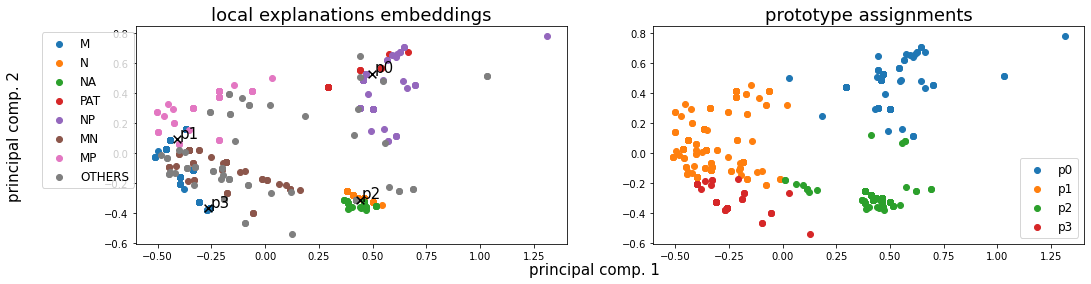

Alpha norms:
tensor([[0.3966, 1.0000, 0.6102, 0.5811],
        [0.2681, 1.0000, 0.4859, 0.4475]], grad_fn=<DivBackward0>)
Concept Purity: 0.631458 +- 0.065636
Concept distribution:  (array([0, 1, 2, 3], dtype=int64), array([116, 335, 198,  60], dtype=int64))
Logic formulas:
For class 0:
0.8928067700987306 (feature002) | ((feature000)
For class 1:
0.8928067700987306 (feature001) | (feature003)
Accuracy as classifier:  0.8928
LEN fidelity:  tensor(0.8928)


 80: Loss: 0.05199, LEN: 0.051533, AccxC: 0.89, AccO: 0.89, V. Acc: 0.89, V. Loss: 0.05125, V. LEN 0.05
 81: Loss: 0.04997, LEN: 0.049744, AccxC: 0.89, AccO: 0.89, V. Acc: 0.89, V. Loss: 0.05063, V. LEN 0.05
 82: Loss: 0.05060, LEN: 0.050390, AccxC: 0.89, AccO: 0.89, V. Acc: 0.89, V. Loss: 0.04997, V. LEN 0.05
 83: Loss: 0.04937, LEN: 0.049216, AccxC: 0.89, AccO: 0.89, V. Acc: 0.89, V. Loss: 0.04939, V. LEN 0.05
 84: Loss: 0.04888, LEN: 0.048379, AccxC: 0.89, AccO: 0.89, V. Acc: 0.89, V. Loss: 0.04920, V. LEN 0.05
 85: Loss: 0.04926, 

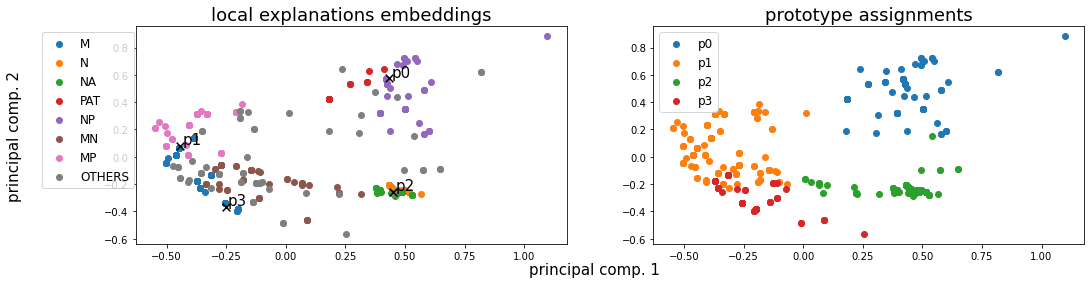

Alpha norms:
tensor([[0.5165, 1.0000, 0.7012, 0.4619],
        [0.1788, 1.0000, 0.3412, 0.2620]], grad_fn=<DivBackward0>)
Concept Purity: 0.650923 +- 0.115589
Concept distribution:  (array([0, 1, 2, 3], dtype=int64), array([118, 264, 200, 127], dtype=int64))
Logic formulas:
For class 0:
0.8928067700987306 (feature002) | (feature000)
For class 1:
0.8928067700987306 (feature001) | (feature003)
Accuracy as classifier:  0.8928
LEN fidelity:  tensor(0.8928)


100: Loss: 0.04668, LEN: 0.046048, AccxC: 0.89, AccO: 0.89, V. Acc: 0.89, V. Loss: 0.04466, V. LEN 0.04
101: Loss: 0.04417, LEN: 0.043987, AccxC: 0.89, AccO: 0.89, V. Acc: 0.89, V. Loss: 0.04455, V. LEN 0.04
102: Loss: 0.04404, LEN: 0.043771, AccxC: 0.90, AccO: 0.90, V. Acc: 0.89, V. Loss: 0.04391, V. LEN 0.04
103: Loss: 0.04457, LEN: 0.043987, AccxC: 0.89, AccO: 0.89, V. Acc: 0.89, V. Loss: 0.04451, V. LEN 0.04
104: Loss: 0.04375, LEN: 0.043516, AccxC: 0.89, AccO: 0.89, V. Acc: 0.89, V. Loss: 0.04454, V. LEN 0.04
105: Loss: 0.04465, L

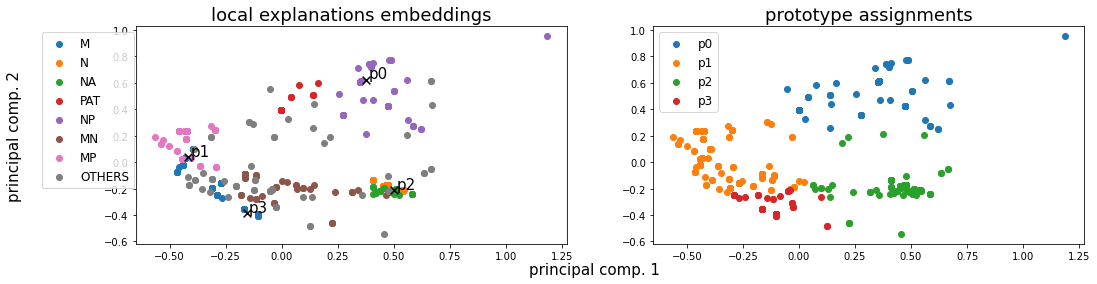

Alpha norms:
tensor([[0.5162, 1.0000, 0.6047, 0.4022],
        [0.1422, 1.0000, 0.2803, 0.1927]], grad_fn=<DivBackward0>)
Concept Purity: 0.624441 +- 0.062245
Concept distribution:  (array([0, 1, 2, 3], dtype=int64), array([116, 322, 208,  63], dtype=int64))
Logic formulas:
For class 0:
0.8928067700987306 (feature002) | (feature000)
For class 1:
0.8928067700987306 (feature001) | (feature003)
Accuracy as classifier:  0.8928
LEN fidelity:  tensor(0.8928)


120: Loss: 0.04396, LEN: 0.043737, AccxC: 0.89, AccO: 0.89, V. Acc: 0.91, V. Loss: 0.03988, V. LEN 0.04
121: Loss: 0.04406, LEN: 0.043885, AccxC: 0.89, AccO: 0.89, V. Acc: 0.89, V. Loss: 0.04429, V. LEN 0.04
122: Loss: 0.04424, LEN: 0.043950, AccxC: 0.90, AccO: 0.90, V. Acc: 0.91, V. Loss: 0.04041, V. LEN 0.04
123: Loss: 0.04260, LEN: 0.042386, AccxC: 0.89, AccO: 0.89, V. Acc: 0.89, V. Loss: 0.04359, V. LEN 0.04
124: Loss: 0.04633, LEN: 0.046015, AccxC: 0.89, AccO: 0.89, V. Acc: 0.91, V. Loss: 0.04032, V. LEN 0.04
125: Loss: 0.04306, L

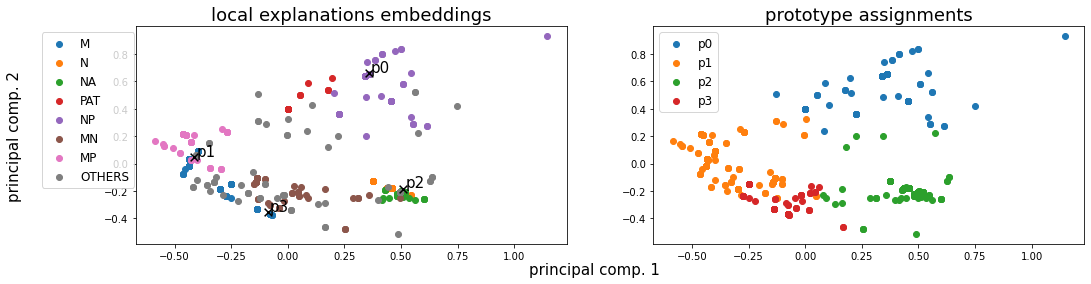

Alpha norms:
tensor([[0.5263, 1.0000, 0.5879, 0.3743],
        [0.1427, 1.0000, 0.2807, 0.1877]], grad_fn=<DivBackward0>)
Concept Purity: 0.639780 +- 0.080790
Concept distribution:  (array([0, 1, 2, 3], dtype=int64), array([115, 267, 205, 122], dtype=int64))
Logic formulas:
For class 0:
0.8984485190409027 (feature002) | (feature000)
For class 1:
0.8984485190409027 (feature001) | (feature003)
Accuracy as classifier:  0.8984
LEN fidelity:  tensor(0.8984)


140: Loss: 0.04467, LEN: 0.044352, AccxC: 0.89, AccO: 0.89, V. Acc: 0.91, V. Loss: 0.04055, V. LEN 0.04
141: Loss: 0.04403, LEN: 0.043676, AccxC: 0.90, AccO: 0.90, V. Acc: 0.89, V. Loss: 0.04360, V. LEN 0.04
142: Loss: 0.04192, LEN: 0.041658, AccxC: 0.90, AccO: 0.90, V. Acc: 0.91, V. Loss: 0.04062, V. LEN 0.04
143: Loss: 0.04745, LEN: 0.047082, AccxC: 0.89, AccO: 0.89, V. Acc: 0.91, V. Loss: 0.03983, V. LEN 0.04
144: Loss: 0.04209, LEN: 0.041877, AccxC: 0.90, AccO: 0.90, V. Acc: 0.91, V. Loss: 0.04045, V. LEN 0.04
145: Loss: 0.04336, L

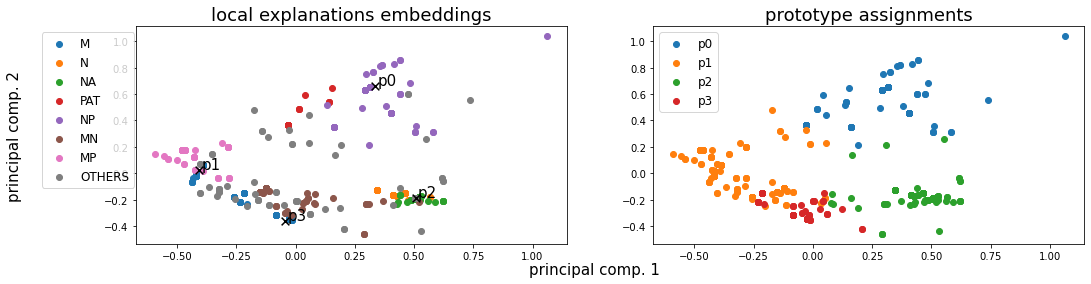

Alpha norms:
tensor([[0.5315, 1.0000, 0.5717, 0.3638],
        [0.1418, 1.0000, 0.2762, 0.1877]], grad_fn=<DivBackward0>)
Concept Purity: 0.643537 +- 0.086570
Concept distribution:  (array([0, 1, 2, 3], dtype=int64), array([114, 272, 204, 119], dtype=int64))
Logic formulas:
For class 0:
0.9012693935119888 (feature002) | (feature000)
For class 1:
0.9012693935119888 (feature001) | (feature003)
Accuracy as classifier:  0.9013
LEN fidelity:  tensor(0.9013)


160: Loss: 0.04215, LEN: 0.041960, AccxC: 0.90, AccO: 0.90, V. Acc: 0.91, V. Loss: 0.04026, V. LEN 0.04
161: Loss: 0.04193, LEN: 0.041741, AccxC: 0.90, AccO: 0.90, V. Acc: 0.91, V. Loss: 0.04023, V. LEN 0.04
162: Loss: 0.04543, LEN: 0.045279, AccxC: 0.89, AccO: 0.89, V. Acc: 0.91, V. Loss: 0.04024, V. LEN 0.04
163: Loss: 0.04213, LEN: 0.041957, AccxC: 0.90, AccO: 0.90, V. Acc: 0.91, V. Loss: 0.03971, V. LEN 0.04
164: Loss: 0.04221, LEN: 0.042036, AccxC: 0.90, AccO: 0.90, V. Acc: 0.91, V. Loss: 0.04019, V. LEN 0.04
165: Loss: 0.04413, L

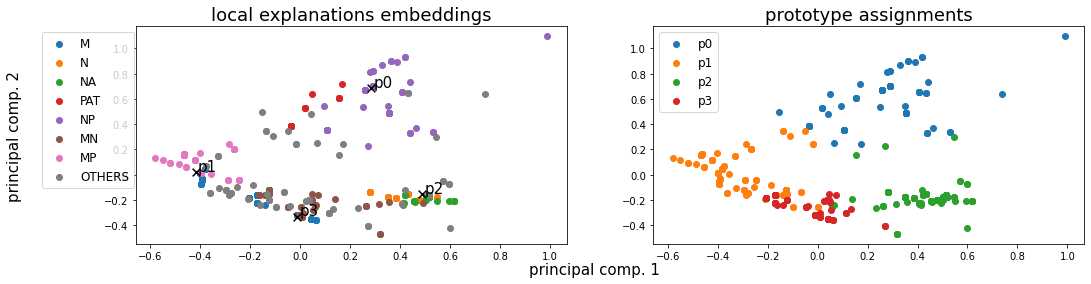

Alpha norms:
tensor([[0.5436, 1.0000, 0.5608, 0.3563],
        [0.1439, 1.0000, 0.2722, 0.1871]], grad_fn=<DivBackward0>)
Concept Purity: 0.637633 +- 0.082404
Concept distribution:  (array([0, 1, 2, 3], dtype=int64), array([116, 250, 203, 140], dtype=int64))
Logic formulas:
For class 0:
0.8998589562764457 (feature002) | (feature000)
For class 1:
0.8998589562764457 (feature001) | (feature003)
Accuracy as classifier:  0.8999
LEN fidelity:  tensor(0.8999)


180: Loss: 0.04722, LEN: 0.046981, AccxC: 0.89, AccO: 0.89, V. Acc: 0.91, V. Loss: 0.04049, V. LEN 0.04
181: Loss: 0.04389, LEN: 0.043632, AccxC: 0.90, AccO: 0.90, V. Acc: 0.91, V. Loss: 0.04024, V. LEN 0.04
182: Loss: 0.04202, LEN: 0.041836, AccxC: 0.90, AccO: 0.90, V. Acc: 0.91, V. Loss: 0.04018, V. LEN 0.04
183: Loss: 0.04212, LEN: 0.041963, AccxC: 0.90, AccO: 0.90, V. Acc: 0.88, V. Loss: 0.05496, V. LEN 0.05
184: Loss: 0.04465, LEN: 0.044406, AccxC: 0.89, AccO: 0.89, V. Acc: 0.91, V. Loss: 0.04023, V. LEN 0.04
185: Loss: 0.04301, L

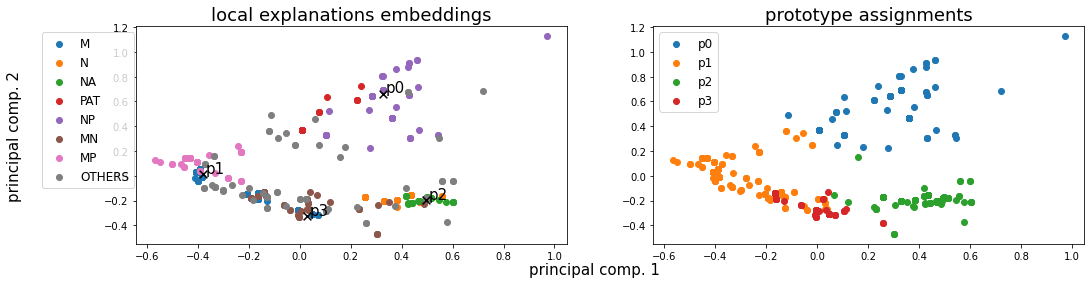

Alpha norms:
tensor([[0.5587, 1.0000, 0.5562, 0.3493],
        [0.1475, 1.0000, 0.2738, 0.1879]], grad_fn=<DivBackward0>)
Concept Purity: 0.651052 +- 0.105829
Concept distribution:  (array([0, 1, 2, 3], dtype=int64), array([118, 278, 200, 113], dtype=int64))
Logic formulas:
For class 0:
0.9012693935119888 (feature002) | (feature000)
For class 1:
0.9012693935119888 (feature001) | (feature003)
Accuracy as classifier:  0.9013
LEN fidelity:  tensor(0.9013)


200: Loss: 0.04486, LEN: 0.044595, AccxC: 0.89, AccO: 0.89, V. Acc: 0.91, V. Loss: 0.04027, V. LEN 0.04
201: Loss: 0.04555, LEN: 0.045137, AccxC: 0.89, AccO: 0.89, V. Acc: 0.91, V. Loss: 0.04024, V. LEN 0.04
202: Loss: 0.04281, LEN: 0.042608, AccxC: 0.90, AccO: 0.90, V. Acc: 0.91, V. Loss: 0.04026, V. LEN 0.04
203: Loss: 0.04358, LEN: 0.043347, AccxC: 0.90, AccO: 0.90, V. Acc: 0.91, V. Loss: 0.04031, V. LEN 0.04
204: Loss: 0.04280, LEN: 0.042598, AccxC: 0.90, AccO: 0.90, V. Acc: 0.91, V. Loss: 0.04042, V. LEN 0.04
205: Loss: 0.04889, L

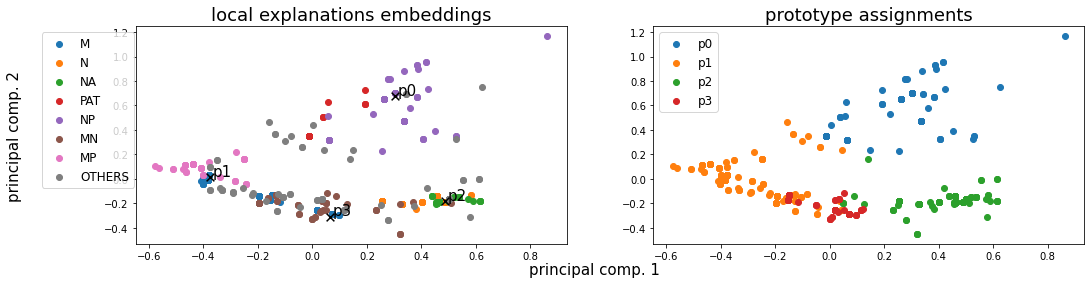

Alpha norms:
tensor([[0.5670, 1.0000, 0.5598, 0.3510],
        [0.1495, 1.0000, 0.2797, 0.1921]], grad_fn=<DivBackward0>)
Concept Purity: 0.651240 +- 0.104175
Concept distribution:  (array([0, 1, 2, 3], dtype=int64), array([116, 275, 205, 113], dtype=int64))
Logic formulas:
For class 0:
0.9055007052186178 (feature002) | (feature000)
For class 1:
0.9055007052186178 (feature001) | (feature003)
Accuracy as classifier:  0.9055
LEN fidelity:  tensor(0.9055)


220: Loss: 0.04318, LEN: 0.042983, AccxC: 0.90, AccO: 0.90, V. Acc: 0.91, V. Loss: 0.04022, V. LEN 0.04
221: Loss: 0.04438, LEN: 0.044249, AccxC: 0.90, AccO: 0.90, V. Acc: 0.91, V. Loss: 0.04019, V. LEN 0.04
222: Loss: 0.04258, LEN: 0.042386, AccxC: 0.90, AccO: 0.90, V. Acc: 0.91, V. Loss: 0.04024, V. LEN 0.04
223: Loss: 0.04185, LEN: 0.041676, AccxC: 0.90, AccO: 0.90, V. Acc: 0.91, V. Loss: 0.03970, V. LEN 0.04
224: Loss: 0.04306, LEN: 0.042930, AccxC: 0.90, AccO: 0.90, V. Acc: 0.86, V. Loss: 0.06019, V. LEN 0.06
225: Loss: 0.04359, L

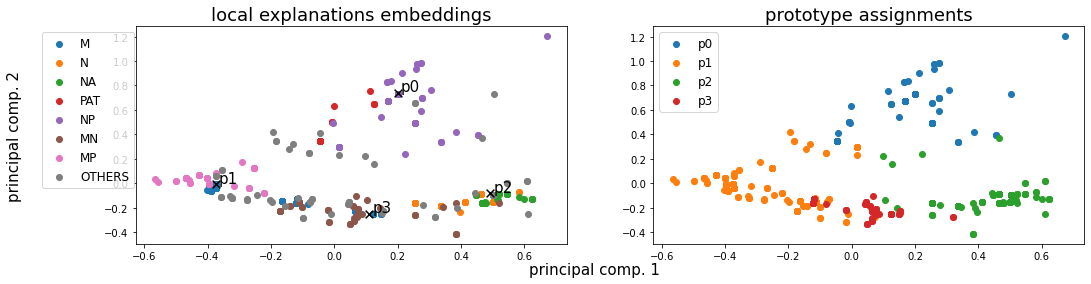

Alpha norms:
tensor([[0.5793, 1.0000, 0.5649, 0.3566],
        [0.1539, 1.0000, 0.2870, 0.1988]], grad_fn=<DivBackward0>)
Concept Purity: 0.632506 +- 0.087773
Concept distribution:  (array([0, 1, 2, 3], dtype=int64), array([107, 278, 203, 121], dtype=int64))
Logic formulas:
For class 0:
0.9040902679830748 (feature002) | (feature000)
For class 1:
0.9040902679830748 (feature001) | (feature003)
Accuracy as classifier:  0.9041
LEN fidelity:  tensor(0.9041)


240: Loss: 0.04064, LEN: 0.040510, AccxC: 0.91, AccO: 0.91, V. Acc: 0.89, V. Loss: 0.04559, V. LEN 0.05
241: Loss: 0.04229, LEN: 0.042129, AccxC: 0.90, AccO: 0.90, V. Acc: 0.91, V. Loss: 0.04032, V. LEN 0.04
242: Loss: 0.04869, LEN: 0.048524, AccxC: 0.89, AccO: 0.89, V. Acc: 0.91, V. Loss: 0.04036, V. LEN 0.04
243: Loss: 0.04441, LEN: 0.044255, AccxC: 0.90, AccO: 0.90, V. Acc: 0.91, V. Loss: 0.04226, V. LEN 0.04
244: Loss: 0.04072, LEN: 0.040574, AccxC: 0.90, AccO: 0.90, V. Acc: 0.91, V. Loss: 0.04039, V. LEN 0.04
245: Loss: 0.04126, L

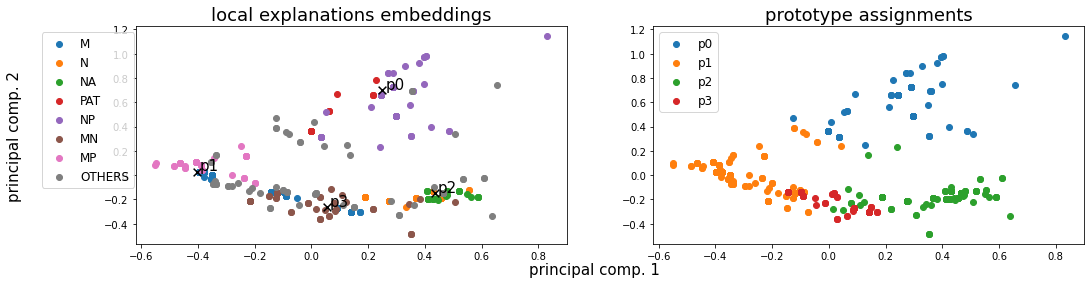

Alpha norms:
tensor([[0.5910, 1.0000, 0.5731, 0.3652],
        [0.1570, 1.0000, 0.2928, 0.2048]], grad_fn=<DivBackward0>)
Concept Purity: 0.647297 +- 0.113564
Concept distribution:  (array([0, 1, 2, 3], dtype=int64), array([116, 255, 210, 128], dtype=int64))
Logic formulas:
For class 0:
0.8984485190409027 (feature002) | (feature000)
For class 1:
0.8984485190409027 (feature001) | (feature003)
Accuracy as classifier:  0.8984
LEN fidelity:  tensor(0.8984)


260: Loss: 0.04465, LEN: 0.044440, AccxC: 0.90, AccO: 0.90, V. Acc: 0.91, V. Loss: 0.04057, V. LEN 0.04
261: Loss: 0.04168, LEN: 0.041455, AccxC: 0.90, AccO: 0.90, V. Acc: 0.92, V. Loss: 0.03625, V. LEN 0.04
262: Loss: 0.04330, LEN: 0.043069, AccxC: 0.90, AccO: 0.90, V. Acc: 0.91, V. Loss: 0.04030, V. LEN 0.04
263: Loss: 0.04324, LEN: 0.043059, AccxC: 0.90, AccO: 0.90, V. Acc: 0.91, V. Loss: 0.04030, V. LEN 0.04
264: Loss: 0.04046, LEN: 0.040309, AccxC: 0.90, AccO: 0.90, V. Acc: 0.91, V. Loss: 0.04222, V. LEN 0.04
265: Loss: 0.04778, L

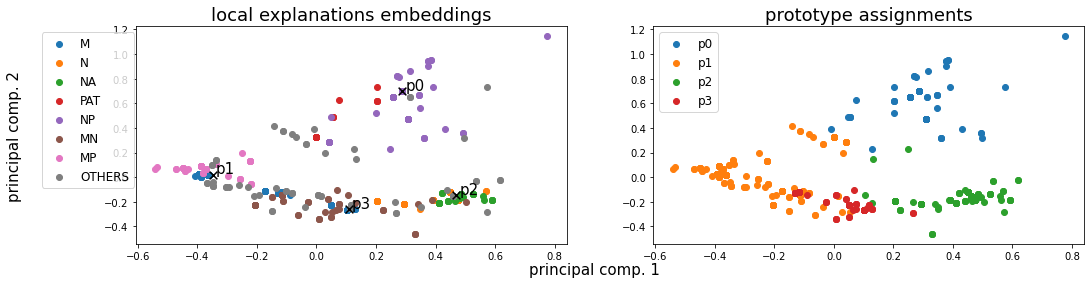

Alpha norms:
tensor([[0.6032, 1.0000, 0.5695, 0.3682],
        [0.1597, 1.0000, 0.2913, 0.2054]], grad_fn=<DivBackward0>)
Concept Purity: 0.687663 +- 0.110296
Concept distribution:  (array([0, 1, 2, 3], dtype=int64), array([ 70, 320, 201, 118], dtype=int64))
Logic formulas:
For class 0:
0.8716502115655853 (feature002) | (feature000)
For class 1:
0.8716502115655853 (feature001) | (feature003)
Accuracy as classifier:  0.8717
LEN fidelity:  tensor(0.8717)


280: Loss: 0.04351, LEN: 0.043416, AccxC: 0.90, AccO: 0.90, V. Acc: 0.88, V. Loss: 0.05622, V. LEN 0.06
281: Loss: 0.04181, LEN: 0.041672, AccxC: 0.90, AccO: 0.90, V. Acc: 0.91, V. Loss: 0.04026, V. LEN 0.04
282: Loss: 0.04509, LEN: 0.044942, AccxC: 0.89, AccO: 0.89, V. Acc: 0.92, V. Loss: 0.03688, V. LEN 0.04
283: Loss: 0.04051, LEN: 0.040371, AccxC: 0.90, AccO: 0.90, V. Acc: 0.91, V. Loss: 0.04222, V. LEN 0.04
284: Loss: 0.04711, LEN: 0.046981, AccxC: 0.89, AccO: 0.89, V. Acc: 0.91, V. Loss: 0.04030, V. LEN 0.04
285: Loss: 0.04332, L

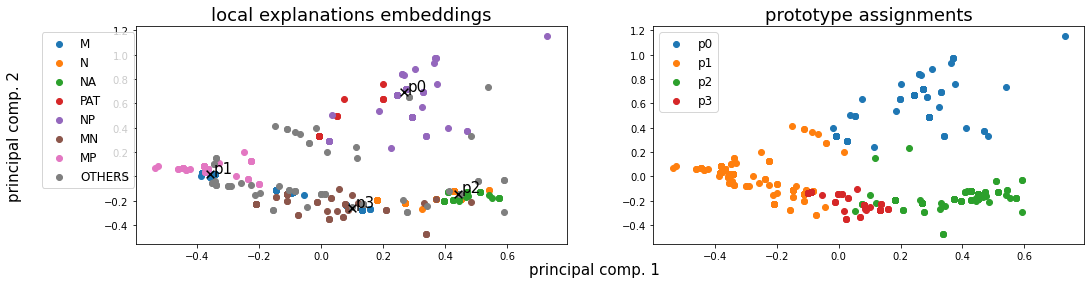

Alpha norms:
tensor([[0.6154, 1.0000, 0.5645, 0.3597],
        [0.1616, 1.0000, 0.2884, 0.2001]], grad_fn=<DivBackward0>)
Concept Purity: 0.645774 +- 0.096830
Concept distribution:  (array([0, 1, 2, 3], dtype=int64), array([115, 271, 207, 116], dtype=int64))
Logic formulas:
For class 0:
0.9040902679830748 (feature002) | (feature000)
For class 1:
0.9040902679830748 (feature001) | (feature003)
Accuracy as classifier:  0.9041
LEN fidelity:  tensor(0.9041)


300: Loss: 0.04041, LEN: 0.040263, AccxC: 0.90, AccO: 0.90, V. Acc: 0.91, V. Loss: 0.04036, V. LEN 0.04
301: Loss: 0.04477, LEN: 0.044636, AccxC: 0.89, AccO: 0.89, V. Acc: 0.92, V. Loss: 0.03666, V. LEN 0.04
302: Loss: 0.04434, LEN: 0.044164, AccxC: 0.89, AccO: 0.89, V. Acc: 0.91, V. Loss: 0.04035, V. LEN 0.04
303: Loss: 0.04355, LEN: 0.043427, AccxC: 0.90, AccO: 0.90, V. Acc: 0.91, V. Loss: 0.04204, V. LEN 0.04
304: Loss: 0.04970, LEN: 0.049259, AccxC: 0.88, AccO: 0.88, V. Acc: 0.92, V. Loss: 0.03687, V. LEN 0.04
305: Loss: 0.04276, L

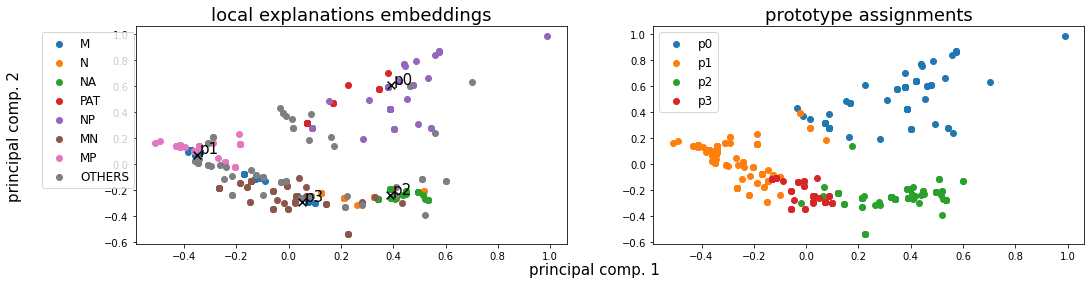

Alpha norms:
tensor([[0.6265, 1.0000, 0.5679, 0.3684],
        [0.1652, 1.0000, 0.2933, 0.2061]], grad_fn=<DivBackward0>)
Concept Purity: 0.643053 +- 0.090604
Concept distribution:  (array([0, 1, 2, 3], dtype=int64), array([119, 268, 203, 119], dtype=int64))
Logic formulas:
For class 0:
0.8984485190409027 (feature002) | (feature000)
For class 1:
0.8984485190409027 (feature001) | (feature003)
Accuracy as classifier:  0.8984
LEN fidelity:  tensor(0.8984)


320: Loss: 0.04526, LEN: 0.045102, AccxC: 0.90, AccO: 0.90, V. Acc: 0.92, V. Loss: 0.03703, V. LEN 0.04
321: Loss: 0.04076, LEN: 0.040631, AccxC: 0.90, AccO: 0.90, V. Acc: 0.89, V. Loss: 0.04522, V. LEN 0.05
322: Loss: 0.04290, LEN: 0.042739, AccxC: 0.90, AccO: 0.90, V. Acc: 0.88, V. Loss: 0.05599, V. LEN 0.06
323: Loss: 0.04634, LEN: 0.046218, AccxC: 0.89, AccO: 0.89, V. Acc: 0.88, V. Loss: 0.05585, V. LEN 0.06
324: Loss: 0.04602, LEN: 0.045900, AccxC: 0.89, AccO: 0.89, V. Acc: 0.92, V. Loss: 0.03706, V. LEN 0.04
325: Loss: 0.04570, L

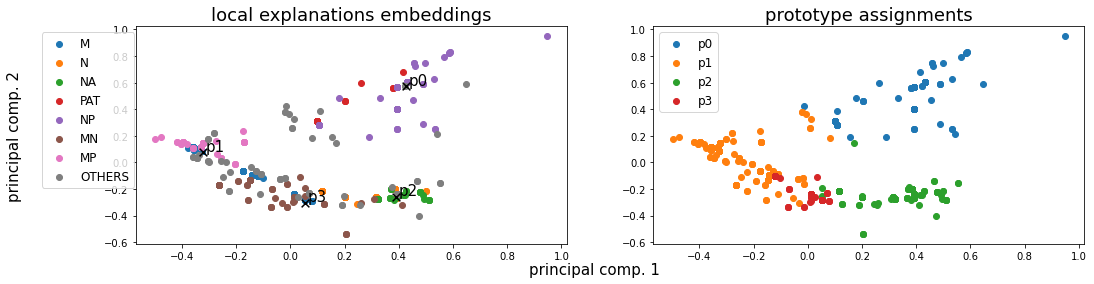

Alpha norms:
tensor([[0.6245, 1.0000, 0.5567, 0.3439],
        [0.1625, 1.0000, 0.2848, 0.1940]], grad_fn=<DivBackward0>)
Concept Purity: 0.653479 +- 0.106927
Concept distribution:  (array([0, 1, 2, 3], dtype=int64), array([117, 285, 202, 105], dtype=int64))
Logic formulas:
For class 0:
0.9026798307475318 (feature002) | (feature000)
For class 1:
0.9026798307475318 (feature001) | (feature003)
Accuracy as classifier:  0.9027
LEN fidelity:  tensor(0.9027)


340: Loss: 0.04428, LEN: 0.044112, AccxC: 0.90, AccO: 0.90, V. Acc: 0.92, V. Loss: 0.03676, V. LEN 0.04
341: Loss: 0.04631, LEN: 0.046168, AccxC: 0.89, AccO: 0.89, V. Acc: 0.92, V. Loss: 0.03726, V. LEN 0.04
342: Loss: 0.04231, LEN: 0.042176, AccxC: 0.90, AccO: 0.90, V. Acc: 0.92, V. Loss: 0.03701, V. LEN 0.04
343: Loss: 0.04343, LEN: 0.043143, AccxC: 0.90, AccO: 0.90, V. Acc: 0.89, V. Loss: 0.04576, V. LEN 0.05
344: Loss: 0.04212, LEN: 0.041967, AccxC: 0.90, AccO: 0.90, V. Acc: 0.91, V. Loss: 0.04053, V. LEN 0.04
345: Loss: 0.04646, L

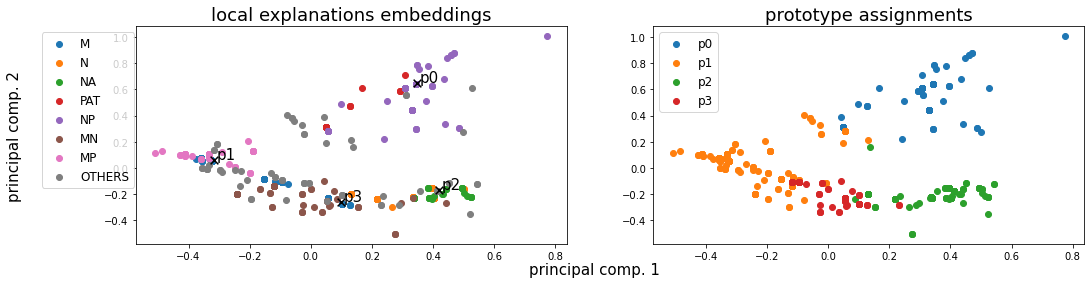

Alpha norms:
tensor([[0.6183, 1.0000, 0.5603, 0.3431],
        [0.1615, 1.0000, 0.2893, 0.1955]], grad_fn=<DivBackward0>)
Concept Purity: 0.634382 +- 0.087672
Concept distribution:  (array([0, 1, 2, 3], dtype=int64), array([109, 280, 199, 121], dtype=int64))
Logic formulas:
For class 0:
0.9040902679830748 (feature002) | (feature000)
For class 1:
0.9040902679830748 (feature001) | (feature003)
Accuracy as classifier:  0.9041
LEN fidelity:  tensor(0.9041)


360: Loss: 0.04257, LEN: 0.042434, AccxC: 0.90, AccO: 0.90, V. Acc: 0.91, V. Loss: 0.04249, V. LEN 0.04
361: Loss: 0.04108, LEN: 0.040970, AccxC: 0.91, AccO: 0.91, V. Acc: 0.89, V. Loss: 0.05049, V. LEN 0.05
362: Loss: 0.04346, LEN: 0.043310, AccxC: 0.90, AccO: 0.90, V. Acc: 0.92, V. Loss: 0.03681, V. LEN 0.04
363: Loss: 0.04506, LEN: 0.044903, AccxC: 0.89, AccO: 0.89, V. Acc: 0.92, V. Loss: 0.03730, V. LEN 0.04
364: Loss: 0.04121, LEN: 0.041012, AccxC: 0.90, AccO: 0.90, V. Acc: 0.91, V. Loss: 0.04151, V. LEN 0.04
365: Loss: 0.04233, L

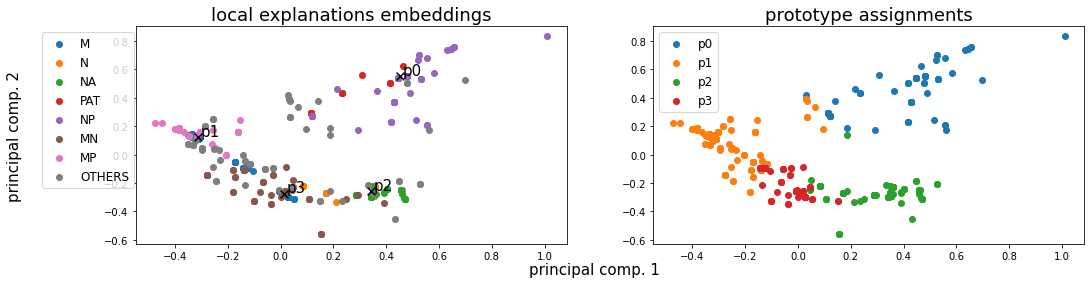

Alpha norms:
tensor([[0.6216, 1.0000, 0.5487, 0.3261],
        [0.1615, 1.0000, 0.2817, 0.1875]], grad_fn=<DivBackward0>)
Concept Purity: 0.640670 +- 0.077495
Concept distribution:  (array([0, 1, 2, 3], dtype=int64), array([117, 269, 200, 123], dtype=int64))
Logic formulas:
For class 0:
0.9026798307475318 (feature002) | (feature000)
For class 1:
0.9026798307475318 (feature001) | (feature003)
Accuracy as classifier:  0.9027
LEN fidelity:  tensor(0.9027)


380: Loss: 0.04808, LEN: 0.047951, AccxC: 0.88, AccO: 0.88, V. Acc: 0.92, V. Loss: 0.03742, V. LEN 0.04
381: Loss: 0.04233, LEN: 0.042193, AccxC: 0.90, AccO: 0.90, V. Acc: 0.91, V. Loss: 0.04161, V. LEN 0.04
382: Loss: 0.04706, LEN: 0.046892, AccxC: 0.89, AccO: 0.89, V. Acc: 0.92, V. Loss: 0.03717, V. LEN 0.04
383: Loss: 0.04190, LEN: 0.041768, AccxC: 0.90, AccO: 0.90, V. Acc: 0.88, V. Loss: 0.05605, V. LEN 0.06
384: Loss: 0.04285, LEN: 0.042643, AccxC: 0.90, AccO: 0.90, V. Acc: 0.92, V. Loss: 0.03644, V. LEN 0.04
385: Loss: 0.04857, L

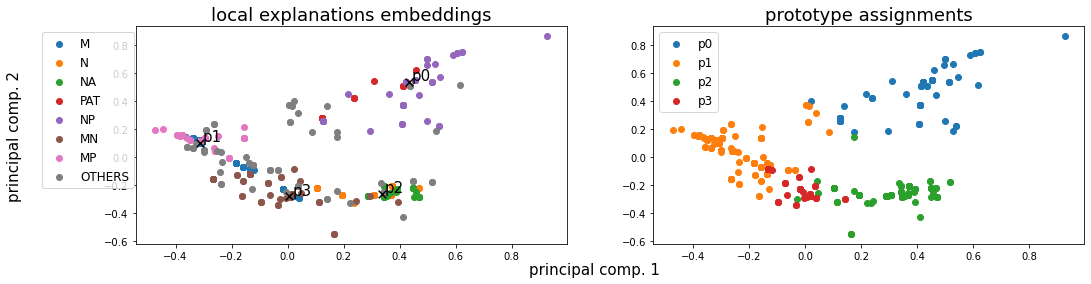

Alpha norms:
tensor([[0.6126, 1.0000, 0.5515, 0.3130],
        [0.1588, 1.0000, 0.2837, 0.1807]], grad_fn=<DivBackward0>)
Concept Purity: 0.647068 +- 0.091133
Concept distribution:  (array([0, 1, 2, 3], dtype=int64), array([117, 281, 201, 110], dtype=int64))
Logic formulas:
For class 0:
0.9012693935119888 (feature002) | (feature000)
For class 1:
0.9012693935119888 (feature001) | (feature003)
Accuracy as classifier:  0.9013
LEN fidelity:  tensor(0.9013)


400: Loss: 0.04866, LEN: 0.048490, AccxC: 0.88, AccO: 0.88, V. Acc: 0.92, V. Loss: 0.03710, V. LEN 0.04
401: Loss: 0.04215, LEN: 0.042044, AccxC: 0.90, AccO: 0.90, V. Acc: 0.89, V. Loss: 0.04567, V. LEN 0.05
402: Loss: 0.04401, LEN: 0.043837, AccxC: 0.89, AccO: 0.89, V. Acc: 0.92, V. Loss: 0.03714, V. LEN 0.04
403: Loss: 0.04197, LEN: 0.041827, AccxC: 0.90, AccO: 0.90, V. Acc: 0.91, V. Loss: 0.04173, V. LEN 0.04
404: Loss: 0.04534, LEN: 0.045224, AccxC: 0.89, AccO: 0.89, V. Acc: 0.92, V. Loss: 0.03732, V. LEN 0.04
405: Loss: 0.04154, L

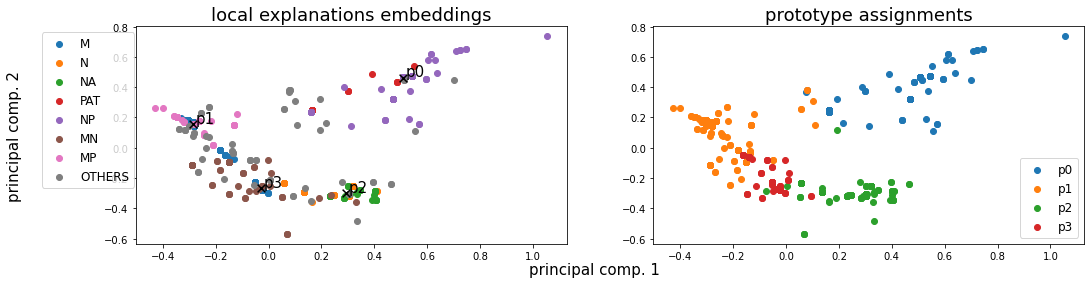

Alpha norms:
tensor([[0.5999, 1.0000, 0.5546, 0.3000],
        [0.1566, 1.0000, 0.2859, 0.1754]], grad_fn=<DivBackward0>)
Concept Purity: 0.643069 +- 0.086129
Concept distribution:  (array([0, 1, 2, 3], dtype=int64), array([118, 271, 200, 120], dtype=int64))
Logic formulas:
For class 0:
0.9012693935119888 (feature002) | (feature000)
For class 1:
0.9012693935119888 (feature001) | (feature003)
Accuracy as classifier:  0.9013
LEN fidelity:  tensor(0.9013)


420: Loss: 0.04418, LEN: 0.044029, AccxC: 0.90, AccO: 0.90, V. Acc: 0.92, V. Loss: 0.03760, V. LEN 0.04
421: Loss: 0.04220, LEN: 0.042050, AccxC: 0.90, AccO: 0.90, V. Acc: 0.89, V. Loss: 0.04508, V. LEN 0.04
422: Loss: 0.04332, LEN: 0.043198, AccxC: 0.90, AccO: 0.90, V. Acc: 0.92, V. Loss: 0.03753, V. LEN 0.04
423: Loss: 0.04347, LEN: 0.043375, AccxC: 0.90, AccO: 0.90, V. Acc: 0.92, V. Loss: 0.03714, V. LEN 0.04
424: Loss: 0.04462, LEN: 0.044537, AccxC: 0.90, AccO: 0.90, V. Acc: 0.92, V. Loss: 0.03716, V. LEN 0.04
425: Loss: 0.04226, L

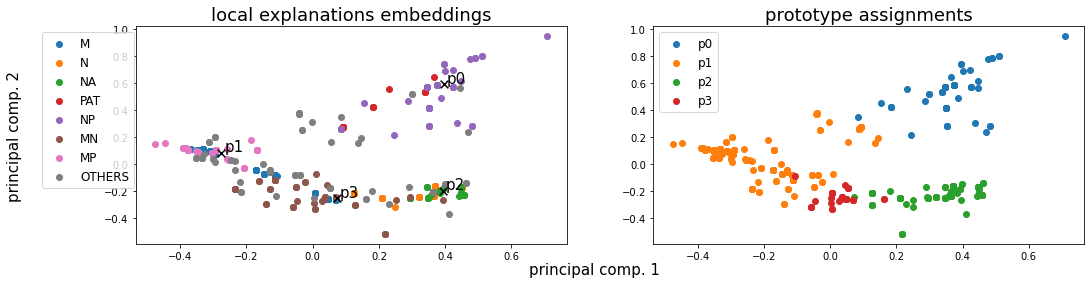

Alpha norms:
tensor([[0.6006, 1.0000, 0.5456, 0.2804],
        [0.1555, 1.0000, 0.2782, 0.1654]], grad_fn=<DivBackward0>)
Concept Purity: 0.674000 +- 0.083647
Concept distribution:  (array([0, 1, 2, 3], dtype=int64), array([ 70, 386, 198,  55], dtype=int64))
Logic formulas:
For class 0:
0.8702397743300423 (feature002) | (feature000)
For class 1:
0.8702397743300423 (feature001) | (feature003)
Accuracy as classifier:  0.8702
LEN fidelity:  tensor(0.8702)


440: Loss: 0.04156, LEN: 0.041428, AccxC: 0.90, AccO: 0.90, V. Acc: 0.88, V. Loss: 0.05519, V. LEN 0.06
441: Loss: 0.04498, LEN: 0.044848, AccxC: 0.89, AccO: 0.89, V. Acc: 0.92, V. Loss: 0.03753, V. LEN 0.04
442: Loss: 0.04311, LEN: 0.042966, AccxC: 0.90, AccO: 0.90, V. Acc: 0.92, V. Loss: 0.03735, V. LEN 0.04
443: Loss: 0.04108, LEN: 0.040963, AccxC: 0.90, AccO: 0.90, V. Acc: 0.88, V. Loss: 0.05588, V. LEN 0.06
444: Loss: 0.04437, LEN: 0.044270, AccxC: 0.90, AccO: 0.90, V. Acc: 0.92, V. Loss: 0.03654, V. LEN 0.04
445: Loss: 0.04343, L

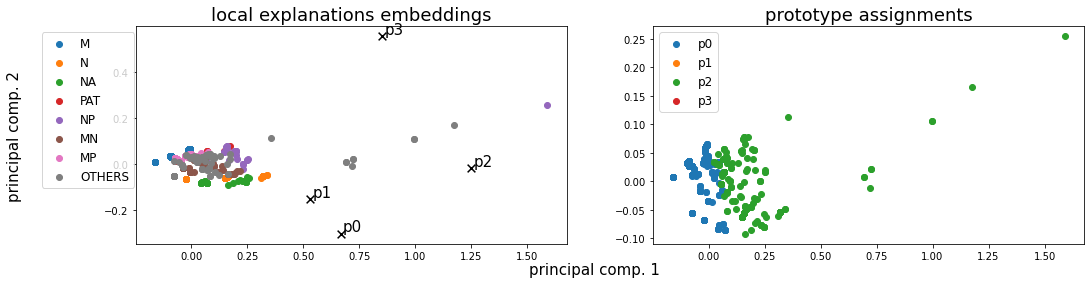

Alpha norms:
tensor([[1.0000, 0.8459, 0.8427, 0.9224],
        [0.8005, 0.7799, 1.0000, 0.8565]], grad_fn=<DivBackward0>)
Concept Purity: 0.394417 +- 0.104645
Concept distribution:  (array([0, 2], dtype=int64), array([533, 176], dtype=int64))
Logic formulas:
For class 0:
0.0 ()
For class 1:
0.0 ()
Accuracy as classifier:  0.0
LEN fidelity:  tensor(0.)

  1: Loss: 0.47890, LEN: 0.353197, AccxC: 0.30, AccO: 0.00, V. Acc: 0.00, V. Loss: 0.46491, V. LEN 0.35
  2: Loss: 0.47169, LEN: 0.352833, AccxC: 0.36, AccO: 0.00, V. Acc: 0.00, V. Loss: 0.46644, V. LEN 0.35
  3: Loss: 0.46218, LEN: 0.352285, AccxC: 0.58, AccO: 0.00, V. Acc: 0.00, V. Loss: 0.46408, V. LEN 0.35
  4: Loss: 0.45771, LEN: 0.351994, AccxC: 0.58, AccO: 0.00, V. Acc: 0.00, V. Loss: 0.45434, V. LEN 0.35
  5: Loss: 0.44732, LEN: 0.351599, AccxC: 0.58, AccO: 0.00, V. Acc: 0.00, V. Loss: 0.44099, V. LEN 0.35
  6: Loss: 0.43183, LEN: 0.351325, AccxC: 0.58, AccO: 0.00, V. Acc: 0.00, V. Loss: 0.42294, V. LEN 0.35
  7: Loss: 0.41633, L

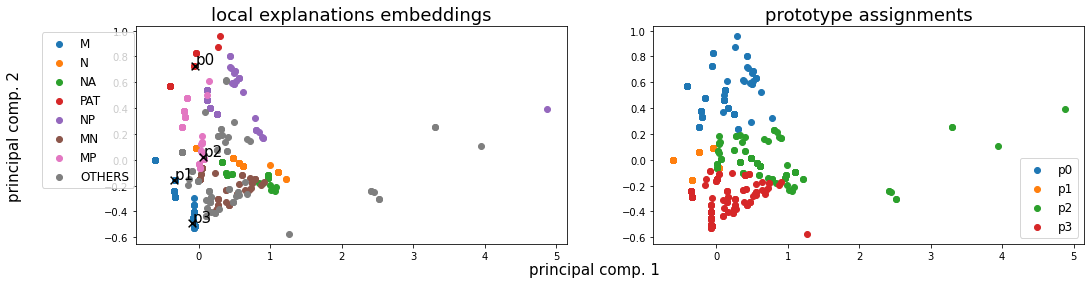

Alpha norms:
tensor([[0.9577, 0.7829, 0.7451, 1.0000],
        [0.7964, 0.8794, 1.0000, 0.9787]], grad_fn=<DivBackward0>)
Concept Purity: 0.478424 +- 0.107115
Concept distribution:  (array([0, 1, 2, 3], dtype=int64), array([132, 242, 112, 223], dtype=int64))
Logic formulas:
For class 0:
0.0 ()
For class 1:
0.0 ()
Accuracy as classifier:  0.0
LEN fidelity:  tensor(0.)


 20: Loss: 0.35993, LEN: 0.346506, AccxC: 0.58, AccO: 0.00, V. Acc: 0.00, V. Loss: 0.35817, V. LEN 0.35
 21: Loss: 0.35858, LEN: 0.346516, AccxC: 0.58, AccO: 0.00, V. Acc: 0.00, V. Loss: 0.35639, V. LEN 0.35
 22: Loss: 0.35653, LEN: 0.346045, AccxC: 0.58, AccO: 0.00, V. Acc: 0.00, V. Loss: 0.35492, V. LEN 0.35
 23: Loss: 0.35540, LEN: 0.345828, AccxC: 0.58, AccO: 0.00, V. Acc: 0.00, V. Loss: 0.35347, V. LEN 0.35
 24: Loss: 0.35430, LEN: 0.345238, AccxC: 0.58, AccO: 0.00, V. Acc: 0.00, V. Loss: 0.35245, V. LEN 0.35
 25: Loss: 0.35217, LEN: 0.345062, AccxC: 0.58, AccO: 0.00, V. Acc: 0.00, V. Loss: 0.35091, V. LEN 0.34
 26:

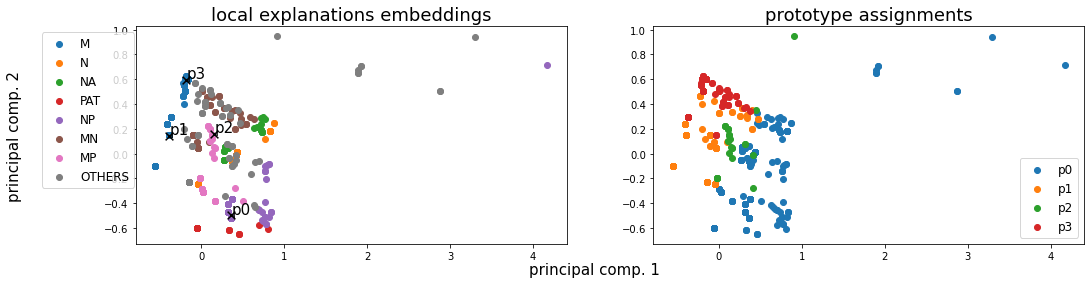

Alpha norms:
tensor([[0.6504, 0.7163, 0.5649, 1.0000],
        [0.7708, 0.9520, 0.6885, 1.0000]], grad_fn=<DivBackward0>)
Concept Purity: 0.591556 +- 0.216174
Concept distribution:  (array([0, 1, 2, 3], dtype=int64), array([228, 312,  28, 141], dtype=int64))
Logic formulas:
For class 0:
0.7263751763046544 (feature000) | ((feature002)
For class 1:
0.763046544428773 (feature001) | (feature003) | ((feature002)

------------------------------------------------------------------------------------
Has double activations  tensor(28)
But only for wrong predictions

Accuracy as classifier:  0.725
LEN fidelity:  tensor(0.7250)


 40: Loss: 0.33835, LEN: 0.336251, AccxC: 0.76, AccO: 0.63, V. Acc: 0.79, V. Loss: 0.33535, V. LEN 0.33
 41: Loss: 0.33627, LEN: 0.335072, AccxC: 0.77, AccO: 0.73, V. Acc: 0.83, V. Loss: 0.33244, V. LEN 0.33
 42: Loss: 0.33161, LEN: 0.330372, AccxC: 0.86, AccO: 0.82, V. Acc: 0.85, V. Loss: 0.32966, V. LEN 0.33
 43: Loss: 0.32948, LEN: 0.328628, AccxC: 0.86, AccO: 0.81, V

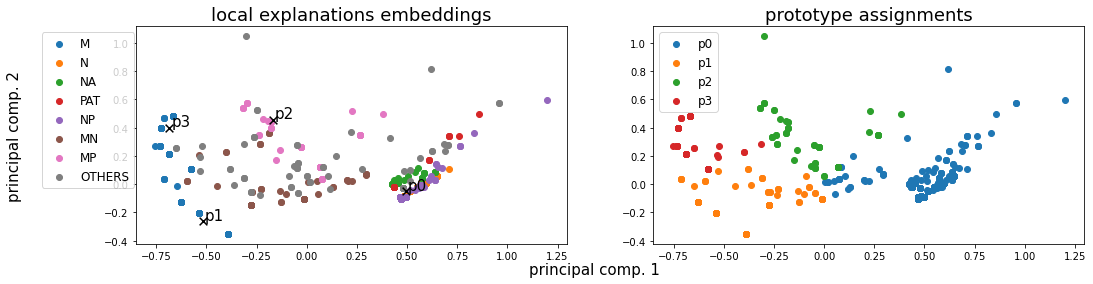

Alpha norms:
tensor([[0.5579, 0.9413, 0.3871, 1.0000],
        [0.8125, 1.0000, 0.4081, 0.8285]], grad_fn=<DivBackward0>)
Concept Purity: 0.673750 +- 0.204516
Concept distribution:  (array([0, 1, 2, 3], dtype=int64), array([330, 205,  59, 115], dtype=int64))
Logic formulas:
For class 0:
0.8787023977433004 (feature000)
For class 1:
0.8787023977433004 (feature001) | (feature003) | ((feature002)
Accuracy as classifier:  0.8787
LEN fidelity:  tensor(0.8787)


 60: Loss: 0.29214, LEN: 0.290953, AccxC: 0.88, AccO: 0.88, V. Acc: 0.89, V. Loss: 0.28832, V. LEN 0.29
 61: Loss: 0.28873, LEN: 0.287775, AccxC: 0.88, AccO: 0.88, V. Acc: 0.89, V. Loss: 0.28508, V. LEN 0.28
 62: Loss: 0.28497, LEN: 0.284094, AccxC: 0.88, AccO: 0.88, V. Acc: 0.89, V. Loss: 0.28167, V. LEN 0.28
 63: Loss: 0.28288, LEN: 0.281544, AccxC: 0.88, AccO: 0.88, V. Acc: 0.89, V. Loss: 0.27816, V. LEN 0.28
 64: Loss: 0.27735, LEN: 0.276289, AccxC: 0.88, AccO: 0.88, V. Acc: 0.89, V. Loss: 0.27404, V. LEN 0.27
 65: Loss: 0.27414, 

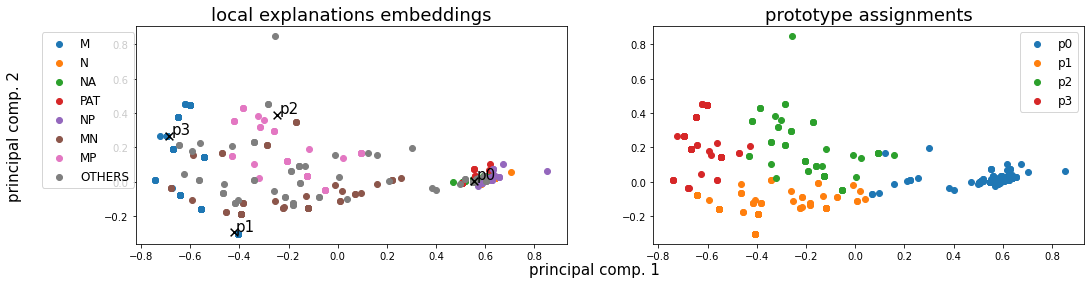

Alpha norms:
tensor([[0.6552, 1.0000, 0.4070, 0.9799],
        [0.5769, 1.0000, 0.2269, 0.6267]], grad_fn=<DivBackward0>)
Concept Purity: 0.672481 +- 0.177597
Concept distribution:  (array([0, 1, 2, 3], dtype=int64), array([313, 208,  62, 126], dtype=int64))
Logic formulas:
For class 0:
0.8913963328631875 (feature000)
For class 1:
0.8913963328631875 (feature001) | (feature003) | ((feature002)
Accuracy as classifier:  0.8914
LEN fidelity:  tensor(0.8914)


 80: Loss: 0.21211, LEN: 0.211305, AccxC: 0.89, AccO: 0.89, V. Acc: 0.89, V. Loss: 0.20832, V. LEN 0.21
 81: Loss: 0.20475, LEN: 0.204025, AccxC: 0.89, AccO: 0.89, V. Acc: 0.89, V. Loss: 0.20464, V. LEN 0.20
 82: Loss: 0.20519, LEN: 0.204307, AccxC: 0.89, AccO: 0.89, V. Acc: 0.89, V. Loss: 0.20023, V. LEN 0.20
 83: Loss: 0.19701, LEN: 0.196132, AccxC: 0.89, AccO: 0.89, V. Acc: 0.89, V. Loss: 0.19616, V. LEN 0.20
 84: Loss: 0.19572, LEN: 0.194843, AccxC: 0.89, AccO: 0.89, V. Acc: 0.89, V. Loss: 0.19210, V. LEN 0.19
 85: Loss: 0.19558, 

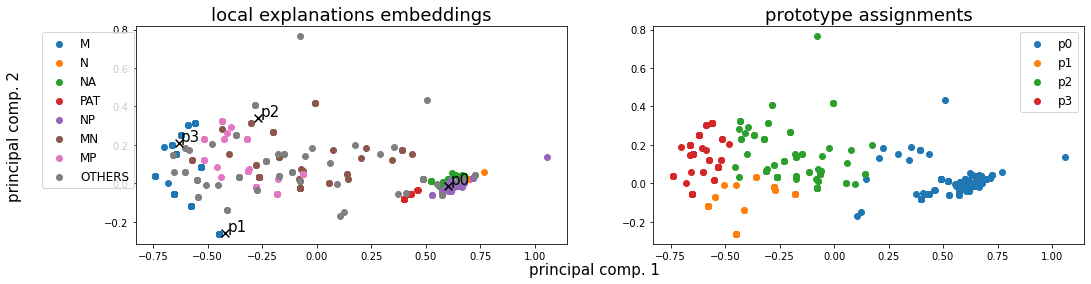

Alpha norms:
tensor([[0.8071, 0.9613, 0.3946, 1.0000],
        [0.5109, 1.0000, 0.1318, 0.5968]], grad_fn=<DivBackward0>)
Concept Purity: 0.647779 +- 0.216814
Concept distribution:  (array([0, 1, 2, 3], dtype=int64), array([313, 148,  88, 160], dtype=int64))
Logic formulas:
For class 0:
0.8970380818053597 (feature000)
For class 1:
0.8970380818053597 (feature001) | ((feature002) | (feature003)
Accuracy as classifier:  0.897
LEN fidelity:  tensor(0.8970)


100: Loss: 0.16779, LEN: 0.167111, AccxC: 0.90, AccO: 0.90, V. Acc: 0.89, V. Loss: 0.16529, V. LEN 0.16
101: Loss: 0.16376, LEN: 0.163087, AccxC: 0.90, AccO: 0.90, V. Acc: 0.91, V. Loss: 0.15176, V. LEN 0.15
102: Loss: 0.16172, LEN: 0.160966, AccxC: 0.90, AccO: 0.90, V. Acc: 0.91, V. Loss: 0.15095, V. LEN 0.15
103: Loss: 0.16454, LEN: 0.163771, AccxC: 0.90, AccO: 0.90, V. Acc: 0.91, V. Loss: 0.14985, V. LEN 0.15
104: Loss: 0.16010, LEN: 0.159288, AccxC: 0.90, AccO: 0.90, V. Acc: 0.91, V. Loss: 0.14921, V. LEN 0.15
105: Loss: 0.16018, L

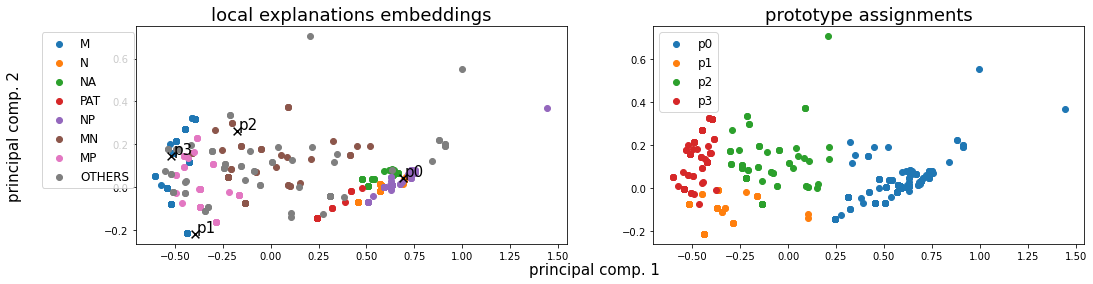

Alpha norms:
tensor([[0.6914, 0.8967, 0.2474, 1.0000],
        [0.4003, 1.0000, 0.0730, 0.5635]], grad_fn=<DivBackward0>)
Concept Purity: 0.655701 +- 0.169276
Concept distribution:  (array([0, 1, 2, 3], dtype=int64), array([309, 156,  72, 172], dtype=int64))
Logic formulas:
For class 0:
0.8998589562764457 (feature000)
For class 1:
0.8998589562764457 (feature001) | ((feature002) | (feature003)
Accuracy as classifier:  0.8999
LEN fidelity:  tensor(0.8999)


120: Loss: 0.15874, LEN: 0.158104, AccxC: 0.89, AccO: 0.89, V. Acc: 0.91, V. Loss: 0.14191, V. LEN 0.14
121: Loss: 0.15698, LEN: 0.156090, AccxC: 0.90, AccO: 0.90, V. Acc: 0.91, V. Loss: 0.14726, V. LEN 0.15
122: Loss: 0.17538, LEN: 0.174622, AccxC: 0.87, AccO: 0.87, V. Acc: 0.91, V. Loss: 0.14245, V. LEN 0.14
123: Loss: 0.15618, LEN: 0.155475, AccxC: 0.90, AccO: 0.90, V. Acc: 0.91, V. Loss: 0.14732, V. LEN 0.15
124: Loss: 0.15875, LEN: 0.157782, AccxC: 0.89, AccO: 0.89, V. Acc: 0.91, V. Loss: 0.14103, V. LEN 0.14
125: Loss: 0.15373, 

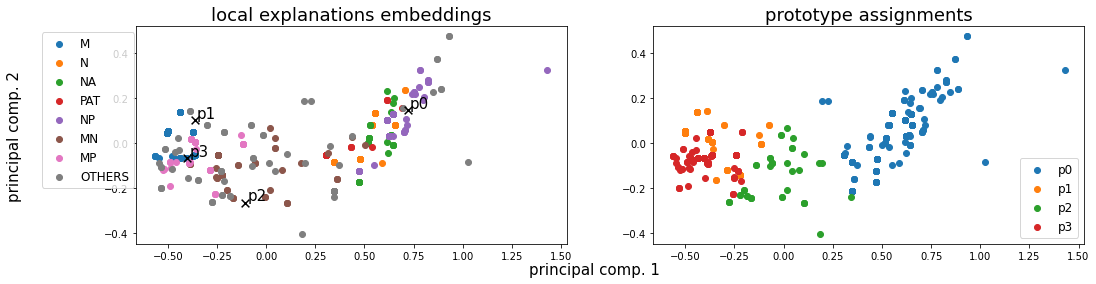

Alpha norms:
tensor([[0.5772, 0.8959, 0.1206, 1.0000],
        [0.3035, 1.0000, 0.0477, 0.5088]], grad_fn=<DivBackward0>)
Concept Purity: 0.606463 +- 0.146465
Concept distribution:  (array([0, 1, 2, 3], dtype=int64), array([310, 193,  40, 166], dtype=int64))
Logic formulas:
For class 0:
0.8984485190409027 (feature000)
For class 1:
0.8984485190409027 (feature001) | (feature003) | ((feature002)
Accuracy as classifier:  0.8984
LEN fidelity:  tensor(0.8984)


140: Loss: 0.16351, LEN: 0.162925, AccxC: 0.90, AccO: 0.90, V. Acc: 0.91, V. Loss: 0.14302, V. LEN 0.14
141: Loss: 0.17394, LEN: 0.172854, AccxC: 0.87, AccO: 0.87, V. Acc: 0.91, V. Loss: 0.14795, V. LEN 0.15
142: Loss: 0.15486, LEN: 0.154416, AccxC: 0.90, AccO: 0.90, V. Acc: 0.88, V. Loss: 0.15338, V. LEN 0.15
143: Loss: 0.15519, LEN: 0.154287, AccxC: 0.89, AccO: 0.89, V. Acc: 0.91, V. Loss: 0.14626, V. LEN 0.15
144: Loss: 0.15477, LEN: 0.153947, AccxC: 0.89, AccO: 0.89, V. Acc: 0.91, V. Loss: 0.14634, V. LEN 0.15
145: Loss: 0.15747, 

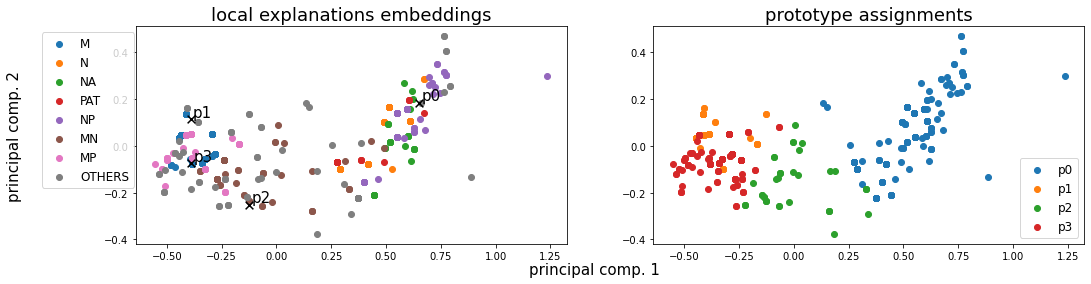

Alpha norms:
tensor([[0.4666, 0.8849, 0.0639, 1.0000],
        [0.2340, 1.0000, 0.0359, 0.4735]], grad_fn=<DivBackward0>)
Concept Purity: 0.629959 +- 0.143862
Concept distribution:  (array([0, 1, 2, 3], dtype=int64), array([307, 155,  38, 209], dtype=int64))
Logic formulas:
For class 0:
0.8970380818053597 (feature000)
For class 1:
0.8970380818053597 (feature001) | (feature003) | ((feature002)
Accuracy as classifier:  0.897
LEN fidelity:  tensor(0.8970)


160: Loss: 0.15098, LEN: 0.150329, AccxC: 0.90, AccO: 0.90, V. Acc: 0.91, V. Loss: 0.14330, V. LEN 0.14
161: Loss: 0.15511, LEN: 0.154694, AccxC: 0.89, AccO: 0.89, V. Acc: 0.91, V. Loss: 0.14319, V. LEN 0.14
162: Loss: 0.15144, LEN: 0.150858, AccxC: 0.89, AccO: 0.89, V. Acc: 0.91, V. Loss: 0.14328, V. LEN 0.14
163: Loss: 0.15297, LEN: 0.152483, AccxC: 0.90, AccO: 0.90, V. Acc: 0.85, V. Loss: 0.15686, V. LEN 0.16
164: Loss: 0.15886, LEN: 0.158350, AccxC: 0.88, AccO: 0.88, V. Acc: 0.91, V. Loss: 0.14314, V. LEN 0.14
165: Loss: 0.15769, L

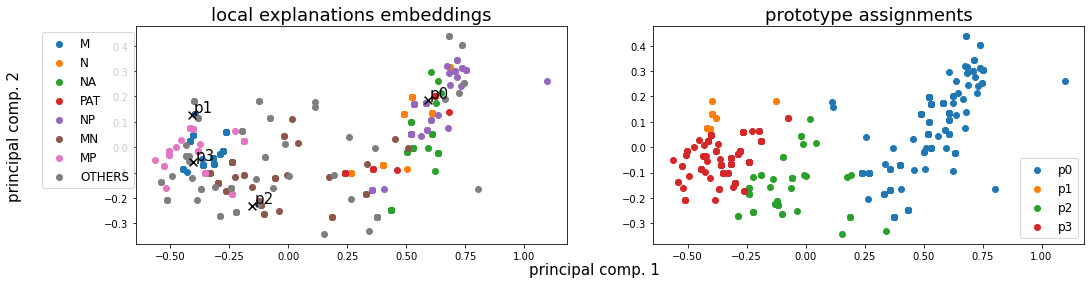

Alpha norms:
tensor([[0.3983, 0.8936, 0.0514, 1.0000],
        [0.1897, 1.0000, 0.0288, 0.4257]], grad_fn=<DivBackward0>)
Concept Purity: 0.619708 +- 0.170451
Concept distribution:  (array([0, 1, 2, 3], dtype=int64), array([310, 119,  46, 234], dtype=int64))
Logic formulas:
For class 0:
0.8984485190409027 (feature000)
For class 1:
0.8758815232722144 (feature001) | (feature003)
Accuracy as classifier:  0.8547
LEN fidelity:  tensor(0.8547)


180: Loss: 0.16004, LEN: 0.159426, AccxC: 0.87, AccO: 0.84, V. Acc: 0.86, V. Loss: 0.14649, V. LEN 0.15
181: Loss: 0.15526, LEN: 0.154660, AccxC: 0.90, AccO: 0.86, V. Acc: 0.77, V. Loss: 0.14965, V. LEN 0.15
182: Loss: 0.16336, LEN: 0.162614, AccxC: 0.84, AccO: 0.80, V. Acc: 0.86, V. Loss: 0.14680, V. LEN 0.15
183: Loss: 0.15014, LEN: 0.149654, AccxC: 0.90, AccO: 0.86, V. Acc: 0.88, V. Loss: 0.14338, V. LEN 0.14
184: Loss: 0.15488, LEN: 0.154198, AccxC: 0.86, AccO: 0.83, V. Acc: 0.88, V. Loss: 0.14322, V. LEN 0.14
185: Loss: 0.14881, LEN: 0.148207, A

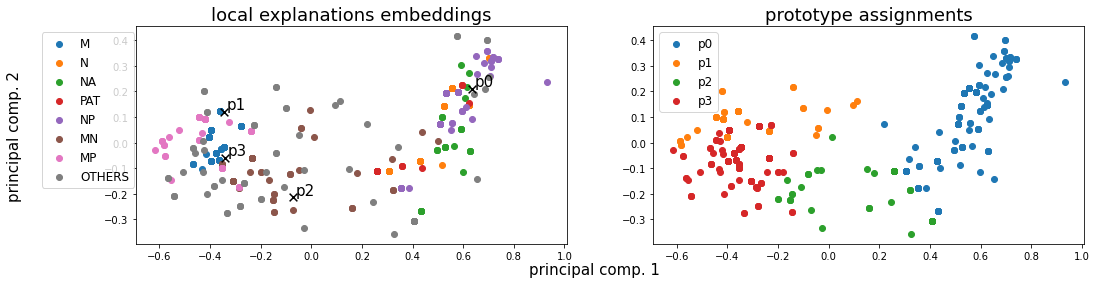

Alpha norms:
tensor([[0.3293, 0.9074, 0.0454, 1.0000],
        [0.1579, 1.0000, 0.0244, 0.3956]], grad_fn=<DivBackward0>)
Concept Purity: 0.593270 +- 0.126476
Concept distribution:  (array([0, 1, 2, 3], dtype=int64), array([241, 164,  90, 214], dtype=int64))
Logic formulas:
For class 0:
0.843441466854725 (feature000)
For class 1:
0.9026798307475318 (feature001) | (feature003)
Accuracy as classifier:  0.8096
LEN fidelity:  tensor(0.8096)


200: Loss: 0.15726, LEN: 0.156800, AccxC: 0.88, AccO: 0.85, V. Acc: 0.77, V. Loss: 0.14288, V. LEN 0.14
201: Loss: 0.15241, LEN: 0.151394, AccxC: 0.87, AccO: 0.84, V. Acc: 0.88, V. Loss: 0.14335, V. LEN 0.14
202: Loss: 0.15268, LEN: 0.152099, AccxC: 0.90, AccO: 0.87, V. Acc: 0.83, V. Loss: 0.15659, V. LEN 0.16
203: Loss: 0.14903, LEN: 0.148542, AccxC: 0.89, AccO: 0.86, V. Acc: 0.88, V. Loss: 0.14342, V. LEN 0.14
204: Loss: 0.14721, LEN: 0.146883, AccxC: 0.90, AccO: 0.87, V. Acc: 0.82, V. Loss: 0.13942, V. LEN 0.14
205: Loss: 0.15108, LEN: 0.150586, Ac

In [62]:
expls = []
for use_focal in [True, False]:
    batch_sampler = utils.GroupBatchSampler(num_input_graphs=128, drop_last=False, belonging=np.array(belonging_train))
    train_group_loader = DataLoader(dataset_train, batch_sampler=batch_sampler)

    batch_sampler = utils.GroupBatchSampler(num_input_graphs=256, drop_last=False, belonging=np.array(belonging_val))
    val_group_loader = DataLoader(dataset_val, batch_sampler=batch_sampler)

    batch_sampler = utils.GroupBatchSampler(num_input_graphs=256, drop_last=False, belonging=np.array(belonging_test))
    test_group_loader = DataLoader(dataset_test, batch_sampler=batch_sampler)

    torch.manual_seed(42)
    hyper = {
        "len_lr": 0.0005,
        "proto_lr": 0.001,
        "le_emb_lr": 0.001,
        "coeff_divloss": 0.000,
        "coeff_pdist": 0.,
        "coeff_gae": 0.,
        "coeff_r1": 0.09,
        "coeff_r2": 0.00099,
        "coeff_ce": 0.0,
        "coeff_de": 0.,
        "coeff_logic_loss": 0.00,
        "focal_gamma": 2, #3
        "focal_alpha": -1,
        "ts": 1,
        "te": 1,
        "focal_loss": use_focal,
        "debug_prototypes": False,
        "num_prototypes": 4,
        "dim_prototypes": 10,
        "num_le_features": 5,
        "activation": "leaky",
        "embedder_backbone": "GAT",
        "embedder_num_layers": 2,
        "assign_func": "straight_sim",
        "LEN_temperature": 1,
        "remove_attention": True,
        "log_images": True,
        "log_models": True,
        "num_epochs": 500
    }

    len_model    = models.LEN(hyper["num_prototypes"], 
                              hyper["LEN_temperature"], 
                              remove_attention=hyper["remove_attention"]).to(device)
    le_model     = models.LEEmbedder(num_features=hyper["num_le_features"], 
                                     activation=hyper["activation"], 
                                     num_hidden=hyper["dim_prototypes"],
                                     backbone=hyper["embedder_backbone"],
                                     num_layers=hyper["embedder_num_layers"]).to(device)
    expl4         = models.GlobalExplainer(len_model, 
                                   le_model, 
                                   train_group_loader, 
                                   val_group_loader, 
                                   device, 
                                   hyper_params=hyper,
                                   classes_names=priori_etn_classes_names,
                                   dataset_name="ETN").to(device)

    prefix = "DEBUG" if hyper["debug_prototypes"] else ""
    suffix = "no attn" if hyper["remove_attention"] else ""
    expl4.iterate(num_epochs=hyper["num_epochs"], log_wandb=False, name_wandb=f"ETN {hyper['num_prototypes']}prots {prefix} {suffix}")
    
    with open(f'../logs/model_focal_{use_focal}_ETN.pkl', 'wb') as handle:
        pickle.dump(expl4, handle)

In [16]:
with open(f'../logs/model_focal_True_ETN.pkl', 'rb') as handle:
    uno = pickle.load(handle)
with open(f'../logs/model_focal_False_ETN.pkl', 'rb') as handle:
    due = pickle.load(handle)

In [19]:
print([e["acc_overall"] for e in uno.val_metrics][uno.early_stopping.best_epoch-1], "@", uno.early_stopping.best_epoch )
print([e["acc_overall"] for e in due.val_metrics][due.early_stopping.best_epoch-1], "@", due.early_stopping.best_epoch)

tensor(0.9242) @ 357
tensor(0.9242) @ 115


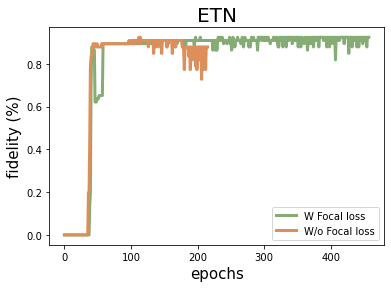

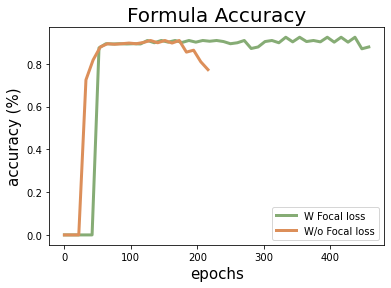

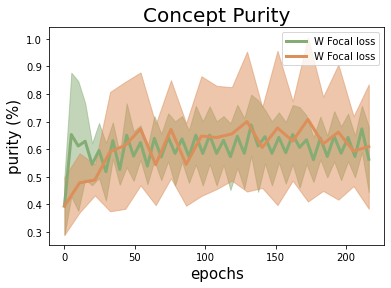

In [64]:
c1 = "#86ac75"
c2 = "#dc8f5a"

print([e["acc_overall"] for e in uno.val_metrics][uno.early_stopping.best_epoch-1])

plt.plot([e["acc_overall"] for e in uno.val_metrics], label="W Focal loss", color=c1, linewidth=3)
plt.plot([e["acc_overall"] for e in due.val_metrics], label="W/o Focal loss", color=c2, linewidth=3)
plt.legend()
plt.title("ETN", size=20)
plt.xlabel("epochs", size=15)
plt.ylabel("fidelity (%)", size=15)
plt.savefig("fidelity_focal_etn.pdf")
plt.show()

plt.plot(np.linspace(0, len([e["acc_overall"] for e in uno.val_metrics]), num=len([e["logic_acc_clf"] for e in uno.val_logic_metrics])), [e["logic_acc_clf"] for e in uno.val_logic_metrics], label="W Focal loss", color=c1, linewidth=3)
plt.plot(np.linspace(0, len([e["acc_overall"] for e in due.val_metrics]), num=len([e["logic_acc_clf"] for e in due.val_logic_metrics])), [e["logic_acc_clf"] for e in due.val_logic_metrics], label="W/o Focal loss", color=c2, linewidth=3)
plt.legend()
plt.title("Formula Accuracy", size=20)
plt.xlabel("epochs", size=15)
plt.ylabel("accuracy (%)", size=15)
plt.savefig("formula_acc_focal_etn.pdf")
plt.show()


purity     = np.array([e["concept_purity"] for e in uno.val_logic_metrics])
std_purity = np.array([e["concept_purity_std"] for e in uno.val_logic_metrics])
plt.plot(np.linspace(0, len([e["acc_overall"] for e in due.val_metrics]), num=len(purity)), purity, label="W Focal loss", color=c1, linewidth=3)
plt.fill_between(np.linspace(0, len([e["acc_overall"] for e in due.val_metrics]), num=len(purity)), purity-std_purity, purity+std_purity, alpha=0.5, color=c1)

purity     = np.array([e["concept_purity"] for e in due.val_logic_metrics])
std_purity = np.array([e["concept_purity_std"] for e in due.val_logic_metrics])
plt.plot(np.linspace(0, len([e["acc_overall"] for e in due.val_metrics]), num=len(purity)), purity, label="W Focal loss", color=c2, linewidth=3)
plt.fill_between(np.linspace(0, len([e["acc_overall"] for e in due.val_metrics]), num=len(purity)), purity-std_purity, purity+std_purity, alpha=0.5, color=c2)



plt.legend()
plt.title("Concept Purity", size=20)
plt.xlabel("epochs", size=15)
plt.ylabel("purity (%)", size=15)
plt.savefig("purity_focal_etn.pdf")
plt.show()

### Confidence Interval

(array([0., 1., 2., 3., 4., 5., 6., 7.], dtype=float32), array([273, 139,  32,  51,  65,  58,  42,  90], dtype=int64))


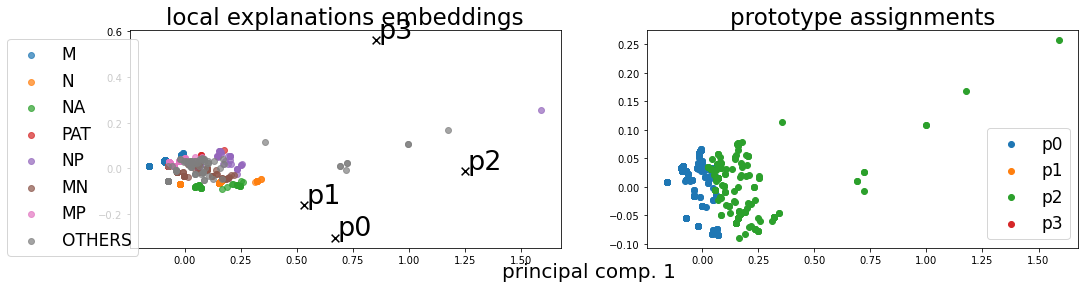

Alpha norms:
tensor([[1.0000, 0.8459, 0.8427, 0.9224],
        [0.8005, 0.7799, 1.0000, 0.8565]], grad_fn=<DivBackward0>)
Concept Purity: 0.384162 +- 0.100740
Concept distribution:  (array([0, 2], dtype=int64), array([563, 187], dtype=int64))
Logic formulas:
For class 0:
0.0 ()
For class 1:
0.0 ()
Accuracy as classifier:  0.0
LEN fidelity:  tensor(0.)

  1: Loss: 0.22276, LEN: 0.096763, AccxC: 0.30, AccO: 0.00, V. Acc: 0.00, V. Loss: 0.20912, V. LEN 0.10
  2: Loss: 0.20855, LEN: 0.096285, AccxC: 0.29, AccO: 0.00, V. Acc: 0.00, V. Loss: 0.20855, V. LEN 0.10
  3: Loss: 0.20684, LEN: 0.095748, AccxC: 0.43, AccO: 0.00, V. Acc: 0.00, V. Loss: 0.20274, V. LEN 0.10
  4: Loss: 0.20031, LEN: 0.095230, AccxC: 0.57, AccO: 0.00, V. Acc: 0.00, V. Loss: 0.19193, V. LEN 0.09
  5: Loss: 0.19008, LEN: 0.094699, AccxC: 0.57, AccO: 0.00, V. Acc: 0.00, V. Loss: 0.18155, V. LEN 0.09
  6: Loss: 0.18180, LEN: 0.094138, AccxC: 0.57, AccO: 0.00, V. Acc: 0.00, V. Loss: 0.17431, V. LEN 0.09
  7: Loss: 0.16531, L

 77: Loss: 0.08491, LEN: 0.083004, AccxC: 0.62, AccO: 0.61, V. Acc: 0.48, V. Loss: 0.08956, V. LEN 0.09
 78: Loss: 0.08321, LEN: 0.081416, AccxC: 0.63, AccO: 0.58, V. Acc: 0.49, V. Loss: 0.08777, V. LEN 0.08
 79: Loss: 0.08209, LEN: 0.080507, AccxC: 0.63, AccO: 0.57, V. Acc: 0.51, V. Loss: 0.08671, V. LEN 0.08

------------------------------------------------------------------------------------
Has double activations  tensor(178)
But only for wrong predictions



------------------------------------------------------------------------------------
Has double activations  tensor(15)
But only for wrong predictions


 80: Loss: 0.08152, LEN: 0.079942, AccxC: 0.63, AccO: 0.57, V. Acc: 0.49, V. Loss: 0.08616, V. LEN 0.08
 81: Loss: 0.08093, LEN: 0.079549, AccxC: 0.69, AccO: 0.57, V. Acc: 0.45, V. Loss: 0.08623, V. LEN 0.08
 82: Loss: 0.08046, LEN: 0.079199, AccxC: 0.75, AccO: 0.56, V. Acc: 0.47, V. Loss: 0.08575, V. LEN 0.08
 83: Loss: 0.07977, LEN: 0.078722, AccxC: 0.76, AccO: 0.70, V. Acc:

154: Loss: 0.04459, LEN: 0.044418, AccxC: 0.89, AccO: 0.89, V. Acc: 0.86, V. Loss: 0.05095, V. LEN 0.05
155: Loss: 0.04574, LEN: 0.045579, AccxC: 0.88, AccO: 0.88, V. Acc: 0.88, V. Loss: 0.04858, V. LEN 0.05
156: Loss: 0.04440, LEN: 0.044233, AccxC: 0.89, AccO: 0.89, V. Acc: 0.88, V. Loss: 0.04848, V. LEN 0.05
157: Loss: 0.04474, LEN: 0.044592, AccxC: 0.89, AccO: 0.89, V. Acc: 0.88, V. Loss: 0.04816, V. LEN 0.05
158: Loss: 0.04441, LEN: 0.044298, AccxC: 0.89, AccO: 0.89, V. Acc: 0.85, V. Loss: 0.05416, V. LEN 0.05
159: Loss: 0.04562, LEN: 0.045528, AccxC: 0.89, AccO: 0.89, V. Acc: 0.88, V. Loss: 0.04857, V. LEN 0.05


160: Loss: 0.04491, LEN: 0.044811, AccxC: 0.89, AccO: 0.89, V. Acc: 0.88, V. Loss: 0.04810, V. LEN 0.05
161: Loss: 0.04511, LEN: 0.044961, AccxC: 0.89, AccO: 0.89, V. Acc: 0.88, V. Loss: 0.04856, V. LEN 0.05
162: Loss: 0.04567, LEN: 0.045532, AccxC: 0.89, AccO: 0.89, V. Acc: 0.88, V. Loss: 0.04858, V. LEN 0.05
163: Loss: 0.04508, LEN: 0.044891, AccxC: 0.89, AccO: 0.89, V.

233: Loss: 0.04406, LEN: 0.043991, AccxC: 0.89, AccO: 0.89, V. Acc: 0.86, V. Loss: 0.05128, V. LEN 0.05
234: Loss: 0.04407, LEN: 0.043971, AccxC: 0.89, AccO: 0.89, V. Acc: 0.88, V. Loss: 0.04849, V. LEN 0.05
235: Loss: 0.04403, LEN: 0.043981, AccxC: 0.89, AccO: 0.89, V. Acc: 0.88, V. Loss: 0.04852, V. LEN 0.05
236: Loss: 0.04514, LEN: 0.045011, AccxC: 0.89, AccO: 0.89, V. Acc: 0.85, V. Loss: 0.05339, V. LEN 0.05
237: Loss: 0.04470, LEN: 0.044632, AccxC: 0.89, AccO: 0.89, V. Acc: 0.88, V. Loss: 0.04849, V. LEN 0.05
238: Loss: 0.04436, LEN: 0.044305, AccxC: 0.89, AccO: 0.89, V. Acc: 0.88, V. Loss: 0.04779, V. LEN 0.05
239: Loss: 0.04390, LEN: 0.043838, AccxC: 0.89, AccO: 0.89, V. Acc: 0.88, V. Loss: 0.04851, V. LEN 0.05


240: Loss: 0.04367, LEN: 0.043578, AccxC: 0.89, AccO: 0.89, V. Acc: 0.88, V. Loss: 0.04847, V. LEN 0.05
241: Loss: 0.04473, LEN: 0.044574, AccxC: 0.89, AccO: 0.89, V. Acc: 0.88, V. Loss: 0.04846, V. LEN 0.05
242: Loss: 0.04460, LEN: 0.044525, AccxC: 0.89, AccO: 0.89, V.

312: Loss: 0.04360, LEN: 0.043425, AccxC: 0.89, AccO: 0.89, V. Acc: 0.85, V. Loss: 0.05397, V. LEN 0.05
313: Loss: 0.04264, LEN: 0.042467, AccxC: 0.90, AccO: 0.90, V. Acc: 0.88, V. Loss: 0.04835, V. LEN 0.05
314: Loss: 0.04468, LEN: 0.044576, AccxC: 0.89, AccO: 0.89, V. Acc: 0.86, V. Loss: 0.05114, V. LEN 0.05
315: Loss: 0.04345, LEN: 0.043310, AccxC: 0.90, AccO: 0.90, V. Acc: 0.88, V. Loss: 0.04828, V. LEN 0.05
316: Loss: 0.04421, LEN: 0.044121, AccxC: 0.89, AccO: 0.89, V. Acc: 0.88, V. Loss: 0.04831, V. LEN 0.05
317: Loss: 0.04822, LEN: 0.048011, AccxC: 0.88, AccO: 0.88, V. Acc: 0.85, V. Loss: 0.05392, V. LEN 0.05
318: Loss: 0.04399, LEN: 0.043853, AccxC: 0.89, AccO: 0.89, V. Acc: 0.89, V. Loss: 0.04554, V. LEN 0.05
319: Loss: 0.04612, LEN: 0.045681, AccxC: 0.89, AccO: 0.89, V. Acc: 0.88, V. Loss: 0.04823, V. LEN 0.05


320: Loss: 0.04678, LEN: 0.046505, AccxC: 0.88, AccO: 0.88, V. Acc: 0.88, V. Loss: 0.04825, V. LEN 0.05
321: Loss: 0.04394, LEN: 0.043815, AccxC: 0.89, AccO: 0.89, V.

391: Loss: 0.05766, LEN: 0.057384, AccxC: 0.85, AccO: 0.85, V. Acc: 0.84, V. Loss: 0.05692, V. LEN 0.06
392: Loss: 0.04471, LEN: 0.044431, AccxC: 0.89, AccO: 0.89, V. Acc: 0.88, V. Loss: 0.04974, V. LEN 0.05
393: Loss: 0.04544, LEN: 0.045113, AccxC: 0.89, AccO: 0.89, V. Acc: 0.88, V. Loss: 0.04882, V. LEN 0.05
394: Loss: 0.04201, LEN: 0.041809, AccxC: 0.90, AccO: 0.90, V. Acc: 0.85, V. Loss: 0.05448, V. LEN 0.05
395: Loss: 0.04213, LEN: 0.041981, AccxC: 0.90, AccO: 0.90, V. Acc: 0.86, V. Loss: 0.05240, V. LEN 0.05
396: Loss: 0.04213, LEN: 0.042033, AccxC: 0.90, AccO: 0.90, V. Acc: 0.86, V. Loss: 0.05163, V. LEN 0.05
397: Loss: 0.04176, LEN: 0.041685, AccxC: 0.90, AccO: 0.90, V. Acc: 0.86, V. Loss: 0.05244, V. LEN 0.05
398: Loss: 0.04591, LEN: 0.045815, AccxC: 0.89, AccO: 0.89, V. Acc: 0.86, V. Loss: 0.05165, V. LEN 0.05
399: Loss: 0.04570, LEN: 0.045493, AccxC: 0.89, AccO: 0.89, V. Acc: 0.88, V. Loss: 0.04806, V. LEN 0.05


400: Loss: 0.04385, LEN: 0.043755, AccxC: 0.89, AccO: 0.89, V.

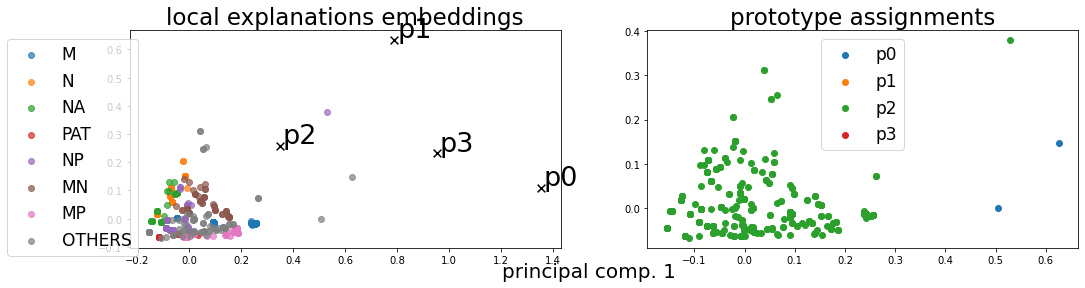

Alpha norms:
tensor([[1.0000, 0.7647, 0.7221, 0.6666],
        [0.8184, 1.0000, 0.9975, 0.8879]], grad_fn=<DivBackward0>)
Concept Purity: 0.682487 +- 0.317513
Concept distribution:  (array([0, 2], dtype=int64), array([  2, 748], dtype=int64))
Logic formulas:
For class 0:
0.0 ()
For class 1:
0.0 ()
Accuracy as classifier:  0.0
LEN fidelity:  tensor(0.)

  1: Loss: 0.32106, LEN: 0.105150, AccxC: 0.43, AccO: 0.00, V. Acc: 0.00, V. Loss: 0.29031, V. LEN 0.10
  2: Loss: 0.27131, LEN: 0.104203, AccxC: 0.43, AccO: 0.00, V. Acc: 0.00, V. Loss: 0.24580, V. LEN 0.10
  3: Loss: 0.23747, LEN: 0.103216, AccxC: 0.43, AccO: 0.00, V. Acc: 0.00, V. Loss: 0.21764, V. LEN 0.10
  4: Loss: 0.21125, LEN: 0.102354, AccxC: 0.42, AccO: 0.00, V. Acc: 0.00, V. Loss: 0.19734, V. LEN 0.10
  5: Loss: 0.19411, LEN: 0.101525, AccxC: 0.41, AccO: 0.00, V. Acc: 0.00, V. Loss: 0.18708, V. LEN 0.10
  6: Loss: 0.17940, LEN: 0.100670, AccxC: 0.38, AccO: 0.00, V. Acc: 0.00, V. Loss: 0.17549, V. LEN 0.10
  7: Loss: 0.17041, L

 77: Loss: 0.05418, LEN: 0.053462, AccxC: 0.87, AccO: 0.87, V. Acc: 0.85, V. Loss: 0.05844, V. LEN 0.06
 78: Loss: 0.05330, LEN: 0.052835, AccxC: 0.87, AccO: 0.87, V. Acc: 0.85, V. Loss: 0.05853, V. LEN 0.06
 79: Loss: 0.05296, LEN: 0.052307, AccxC: 0.87, AccO: 0.87, V. Acc: 0.85, V. Loss: 0.05806, V. LEN 0.06


 80: Loss: 0.05302, LEN: 0.052601, AccxC: 0.87, AccO: 0.87, V. Acc: 0.85, V. Loss: 0.05779, V. LEN 0.06
 81: Loss: 0.05202, LEN: 0.051551, AccxC: 0.87, AccO: 0.87, V. Acc: 0.85, V. Loss: 0.05794, V. LEN 0.06
 82: Loss: 0.05240, LEN: 0.051566, AccxC: 0.87, AccO: 0.87, V. Acc: 0.85, V. Loss: 0.05764, V. LEN 0.06
 83: Loss: 0.05179, LEN: 0.050953, AccxC: 0.87, AccO: 0.87, V. Acc: 0.85, V. Loss: 0.05722, V. LEN 0.06
 84: Loss: 0.05212, LEN: 0.051511, AccxC: 0.87, AccO: 0.87, V. Acc: 0.85, V. Loss: 0.05709, V. LEN 0.06
 85: Loss: 0.05258, LEN: 0.051681, AccxC: 0.87, AccO: 0.87, V. Acc: 0.85, V. Loss: 0.05696, V. LEN 0.06
 86: Loss: 0.05116, LEN: 0.050659, AccxC: 0.87, AccO: 0.87, V.

156: Loss: 0.04623, LEN: 0.046028, AccxC: 0.88, AccO: 0.88, V. Acc: 0.88, V. Loss: 0.04845, V. LEN 0.05
157: Loss: 0.04628, LEN: 0.045954, AccxC: 0.88, AccO: 0.88, V. Acc: 0.88, V. Loss: 0.04845, V. LEN 0.05
158: Loss: 0.04638, LEN: 0.046097, AccxC: 0.89, AccO: 0.89, V. Acc: 0.88, V. Loss: 0.04834, V. LEN 0.05
159: Loss: 0.04614, LEN: 0.045825, AccxC: 0.88, AccO: 0.88, V. Acc: 0.86, V. Loss: 0.05080, V. LEN 0.05


160: Loss: 0.05037, LEN: 0.050042, AccxC: 0.87, AccO: 0.87, V. Acc: 0.88, V. Loss: 0.04823, V. LEN 0.05
161: Loss: 0.04707, LEN: 0.046731, AccxC: 0.88, AccO: 0.88, V. Acc: 0.88, V. Loss: 0.04822, V. LEN 0.05
162: Loss: 0.04633, LEN: 0.046001, AccxC: 0.89, AccO: 0.89, V. Acc: 0.88, V. Loss: 0.04839, V. LEN 0.05
163: Loss: 0.04792, LEN: 0.047516, AccxC: 0.88, AccO: 0.88, V. Acc: 0.86, V. Loss: 0.05075, V. LEN 0.05
164: Loss: 0.04741, LEN: 0.047089, AccxC: 0.88, AccO: 0.88, V. Acc: 0.88, V. Loss: 0.04823, V. LEN 0.05
165: Loss: 0.04585, LEN: 0.045666, AccxC: 0.89, AccO: 0.89, V.

235: Loss: 0.04549, LEN: 0.045275, AccxC: 0.89, AccO: 0.89, V. Acc: 0.88, V. Loss: 0.04898, V. LEN 0.05
236: Loss: 0.04863, LEN: 0.048377, AccxC: 0.88, AccO: 0.88, V. Acc: 0.88, V. Loss: 0.04896, V. LEN 0.05
237: Loss: 0.04628, LEN: 0.046089, AccxC: 0.88, AccO: 0.88, V. Acc: 0.85, V. Loss: 0.05916, V. LEN 0.06
238: Loss: 0.05013, LEN: 0.049912, AccxC: 0.87, AccO: 0.87, V. Acc: 0.86, V. Loss: 0.05139, V. LEN 0.05
239: Loss: 0.05140, LEN: 0.051161, AccxC: 0.87, AccO: 0.87, V. Acc: 0.88, V. Loss: 0.04901, V. LEN 0.05


240: Loss: 0.04645, LEN: 0.046190, AccxC: 0.88, AccO: 0.88, V. Acc: 0.88, V. Loss: 0.04886, V. LEN 0.05
241: Loss: 0.04558, LEN: 0.045330, AccxC: 0.89, AccO: 0.89, V. Acc: 0.88, V. Loss: 0.04916, V. LEN 0.05
242: Loss: 0.04551, LEN: 0.045301, AccxC: 0.89, AccO: 0.89, V. Acc: 0.86, V. Loss: 0.05137, V. LEN 0.05
243: Loss: 0.04445, LEN: 0.044265, AccxC: 0.89, AccO: 0.89, V. Acc: 0.88, V. Loss: 0.04920, V. LEN 0.05
244: Loss: 0.04767, LEN: 0.047358, AccxC: 0.88, AccO: 0.88, V.

314: Loss: 0.04921, LEN: 0.049035, AccxC: 0.87, AccO: 0.87, V. Acc: 0.86, V. Loss: 0.04991, V. LEN 0.05
315: Loss: 0.04562, LEN: 0.045288, AccxC: 0.89, AccO: 0.89, V. Acc: 0.88, V. Loss: 0.04877, V. LEN 0.05
316: Loss: 0.04663, LEN: 0.046406, AccxC: 0.89, AccO: 0.89, V. Acc: 0.88, V. Loss: 0.04772, V. LEN 0.05
317: Loss: 0.04488, LEN: 0.044616, AccxC: 0.89, AccO: 0.89, V. Acc: 0.88, V. Loss: 0.04742, V. LEN 0.05
318: Loss: 0.04490, LEN: 0.044589, AccxC: 0.89, AccO: 0.89, V. Acc: 0.88, V. Loss: 0.04767, V. LEN 0.05
319: Loss: 0.04464, LEN: 0.044503, AccxC: 0.89, AccO: 0.89, V. Acc: 0.86, V. Loss: 0.05012, V. LEN 0.05


320: Loss: 0.04773, LEN: 0.047537, AccxC: 0.88, AccO: 0.88, V. Acc: 0.88, V. Loss: 0.04876, V. LEN 0.05
321: Loss: 0.04558, LEN: 0.045322, AccxC: 0.89, AccO: 0.89, V. Acc: 0.88, V. Loss: 0.04745, V. LEN 0.05
322: Loss: 0.04898, LEN: 0.048743, AccxC: 0.88, AccO: 0.88, V. Acc: 0.86, V. Loss: 0.05009, V. LEN 0.05
323: Loss: 0.04547, LEN: 0.045190, AccxC: 0.88, AccO: 0.88, V.

393: Loss: 0.04526, LEN: 0.045089, AccxC: 0.89, AccO: 0.89, V. Acc: 0.88, V. Loss: 0.04888, V. LEN 0.05
394: Loss: 0.04525, LEN: 0.045144, AccxC: 0.89, AccO: 0.89, V. Acc: 0.88, V. Loss: 0.04885, V. LEN 0.05
395: Loss: 0.04410, LEN: 0.043975, AccxC: 0.89, AccO: 0.89, V. Acc: 0.86, V. Loss: 0.05321, V. LEN 0.05
396: Loss: 0.04483, LEN: 0.044555, AccxC: 0.89, AccO: 0.89, V. Acc: 0.85, V. Loss: 0.05915, V. LEN 0.06
397: Loss: 0.04445, LEN: 0.044205, AccxC: 0.89, AccO: 0.89, V. Acc: 0.88, V. Loss: 0.04878, V. LEN 0.05
398: Loss: 0.04805, LEN: 0.047862, AccxC: 0.88, AccO: 0.88, V. Acc: 0.88, V. Loss: 0.04895, V. LEN 0.05
399: Loss: 0.04479, LEN: 0.044610, AccxC: 0.89, AccO: 0.89, V. Acc: 0.88, V. Loss: 0.04781, V. LEN 0.05


400: Loss: 0.04453, LEN: 0.044380, AccxC: 0.89, AccO: 0.89, V. Acc: 0.88, V. Loss: 0.04780, V. LEN 0.05
401: Loss: 0.04525, LEN: 0.045092, AccxC: 0.89, AccO: 0.89, V. Acc: 0.86, V. Loss: 0.05210, V. LEN 0.05
402: Loss: 0.04520, LEN: 0.045057, AccxC: 0.89, AccO: 0.89, V.

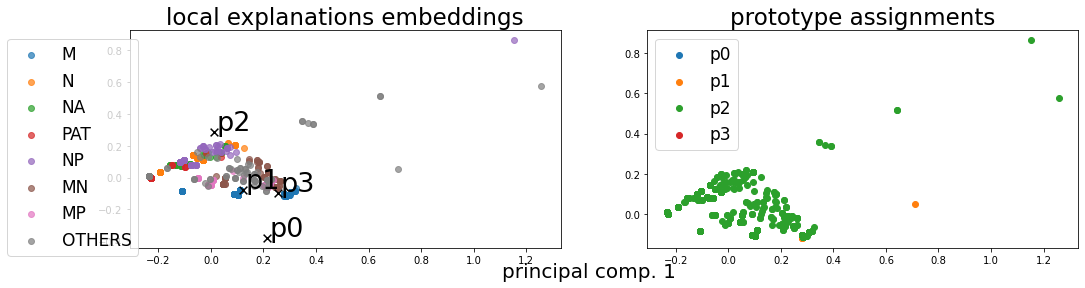

Alpha norms:
tensor([[0.9026, 0.9783, 0.9124, 1.0000],
        [0.6990, 1.0000, 0.6649, 0.9657]], grad_fn=<DivBackward0>)
Concept Purity: 0.555965 +- 0.194035
Concept distribution:  (array([1, 2], dtype=int64), array([  4, 746], dtype=int64))
Logic formulas:
For class 0:
0.0 ()
For class 1:
0.0 ()
Accuracy as classifier:  0.0
LEN fidelity:  tensor(0.)

  1: Loss: 0.29991, LEN: 0.088664, AccxC: 0.64, AccO: 0.00, V. Acc: 0.00, V. Loss: 0.27847, V. LEN 0.09
  2: Loss: 0.26153, LEN: 0.088219, AccxC: 0.57, AccO: 0.00, V. Acc: 0.00, V. Loss: 0.24070, V. LEN 0.09
  3: Loss: 0.22513, LEN: 0.088009, AccxC: 0.57, AccO: 0.00, V. Acc: 0.00, V. Loss: 0.20488, V. LEN 0.09
  4: Loss: 0.18337, LEN: 0.087788, AccxC: 0.57, AccO: 0.00, V. Acc: 0.00, V. Loss: 0.16139, V. LEN 0.09
  5: Loss: 0.14776, LEN: 0.087560, AccxC: 0.57, AccO: 0.00, V. Acc: 0.00, V. Loss: 0.13016, V. LEN 0.09
  6: Loss: 0.12500, LEN: 0.087559, AccxC: 0.47, AccO: 0.00, V. Acc: 0.00, V. Loss: 0.11450, V. LEN 0.09
  7: Loss: 0.11389, L

 77: Loss: 0.04513, LEN: 0.044365, AccxC: 0.89, AccO: 0.89, V. Acc: 0.88, V. Loss: 0.05005, V. LEN 0.05
 78: Loss: 0.04542, LEN: 0.044912, AccxC: 0.89, AccO: 0.89, V. Acc: 0.88, V. Loss: 0.05004, V. LEN 0.05
 79: Loss: 0.04462, LEN: 0.043943, AccxC: 0.89, AccO: 0.89, V. Acc: 0.88, V. Loss: 0.05059, V. LEN 0.05


 80: Loss: 0.04494, LEN: 0.044362, AccxC: 0.89, AccO: 0.89, V. Acc: 0.88, V. Loss: 0.04986, V. LEN 0.05
 81: Loss: 0.04417, LEN: 0.043519, AccxC: 0.89, AccO: 0.89, V. Acc: 0.88, V. Loss: 0.05051, V. LEN 0.05
 82: Loss: 0.04398, LEN: 0.043423, AccxC: 0.89, AccO: 0.89, V. Acc: 0.88, V. Loss: 0.05049, V. LEN 0.05
 83: Loss: 0.04409, LEN: 0.043479, AccxC: 0.89, AccO: 0.89, V. Acc: 0.88, V. Loss: 0.05027, V. LEN 0.05
 84: Loss: 0.04384, LEN: 0.043338, AccxC: 0.89, AccO: 0.89, V. Acc: 0.88, V. Loss: 0.04954, V. LEN 0.05
 85: Loss: 0.04462, LEN: 0.043881, AccxC: 0.89, AccO: 0.89, V. Acc: 0.88, V. Loss: 0.04984, V. LEN 0.05
 86: Loss: 0.04477, LEN: 0.043966, AccxC: 0.89, AccO: 0.89, V.

156: Loss: 0.04414, LEN: 0.043601, AccxC: 0.89, AccO: 0.89, V. Acc: 0.89, V. Loss: 0.04748, V. LEN 0.05
157: Loss: 0.04350, LEN: 0.043163, AccxC: 0.89, AccO: 0.89, V. Acc: 0.88, V. Loss: 0.04939, V. LEN 0.05
158: Loss: 0.04341, LEN: 0.042905, AccxC: 0.89, AccO: 0.89, V. Acc: 0.89, V. Loss: 0.04759, V. LEN 0.05
159: Loss: 0.04373, LEN: 0.043343, AccxC: 0.89, AccO: 0.89, V. Acc: 0.86, V. Loss: 0.06105, V. LEN 0.06


160: Loss: 0.04789, LEN: 0.047433, AccxC: 0.88, AccO: 0.88, V. Acc: 0.89, V. Loss: 0.04769, V. LEN 0.05
161: Loss: 0.04705, LEN: 0.046732, AccxC: 0.88, AccO: 0.88, V. Acc: 0.89, V. Loss: 0.04760, V. LEN 0.05
162: Loss: 0.04423, LEN: 0.043841, AccxC: 0.89, AccO: 0.89, V. Acc: 0.89, V. Loss: 0.04764, V. LEN 0.05
163: Loss: 0.04474, LEN: 0.044304, AccxC: 0.89, AccO: 0.89, V. Acc: 0.89, V. Loss: 0.04765, V. LEN 0.05
164: Loss: 0.05343, LEN: 0.053091, AccxC: 0.86, AccO: 0.86, V. Acc: 0.89, V. Loss: 0.04771, V. LEN 0.05
165: Loss: 0.04414, LEN: 0.043710, AccxC: 0.89, AccO: 0.89, V.

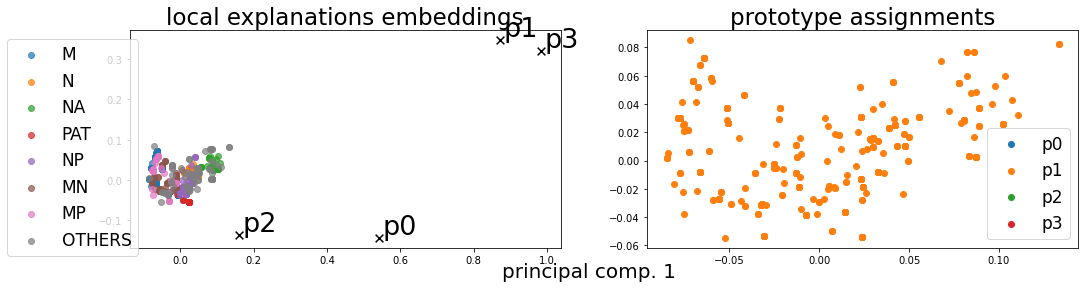

Alpha norms:
tensor([[0.8447, 1.0000, 0.7540, 0.7290],
        [1.0000, 0.8509, 0.8434, 0.9098]], grad_fn=<DivBackward0>)
Concept Purity: 0.364000 +- 0.000000
Concept distribution:  (array([1], dtype=int64), array([750], dtype=int64))
Logic formulas:
For class 0:
0.0 ()
For class 1:
0.0 ()
Accuracy as classifier:  0.0
LEN fidelity:  tensor(0.)

  1: Loss: 0.35157, LEN: 0.114491, AccxC: 0.43, AccO: 0.00, V. Acc: 0.00, V. Loss: 0.30242, V. LEN 0.11
  2: Loss: 0.30945, LEN: 0.113301, AccxC: 0.43, AccO: 0.00, V. Acc: 0.00, V. Loss: 0.25967, V. LEN 0.11
  3: Loss: 0.27584, LEN: 0.112166, AccxC: 0.43, AccO: 0.00, V. Acc: 0.00, V. Loss: 0.22814, V. LEN 0.11
  4: Loss: 0.23960, LEN: 0.111112, AccxC: 0.43, AccO: 0.00, V. Acc: 0.00, V. Loss: 0.21512, V. LEN 0.11
  5: Loss: 0.21998, LEN: 0.110139, AccxC: 0.43, AccO: 0.00, V. Acc: 0.00, V. Loss: 0.21088, V. LEN 0.11
  6: Loss: 0.20290, LEN: 0.109197, AccxC: 0.43, AccO: 0.00, V. Acc: 0.00, V. Loss: 0.20043, V. LEN 0.11
  7: Loss: 0.19116, LEN: 0.10

 74: Loss: 0.06000, LEN: 0.059403, AccxC: 0.86, AccO: 0.86, V. Acc: 0.82, V. Loss: 0.06393, V. LEN 0.06
 75: Loss: 0.05934, LEN: 0.058830, AccxC: 0.86, AccO: 0.86, V. Acc: 0.82, V. Loss: 0.06342, V. LEN 0.06
 76: Loss: 0.05856, LEN: 0.057959, AccxC: 0.86, AccO: 0.86, V. Acc: 0.84, V. Loss: 0.06167, V. LEN 0.06
 77: Loss: 0.05783, LEN: 0.057247, AccxC: 0.86, AccO: 0.86, V. Acc: 0.84, V. Loss: 0.06097, V. LEN 0.06
 78: Loss: 0.05691, LEN: 0.056318, AccxC: 0.86, AccO: 0.86, V. Acc: 0.84, V. Loss: 0.06052, V. LEN 0.06
 79: Loss: 0.05594, LEN: 0.055511, AccxC: 0.86, AccO: 0.86, V. Acc: 0.84, V. Loss: 0.06007, V. LEN 0.06


 80: Loss: 0.05618, LEN: 0.055691, AccxC: 0.86, AccO: 0.86, V. Acc: 0.84, V. Loss: 0.05959, V. LEN 0.06
 81: Loss: 0.05502, LEN: 0.054633, AccxC: 0.86, AccO: 0.86, V. Acc: 0.84, V. Loss: 0.05915, V. LEN 0.06
 82: Loss: 0.05443, LEN: 0.053946, AccxC: 0.86, AccO: 0.86, V. Acc: 0.84, V. Loss: 0.05895, V. LEN 0.06
 83: Loss: 0.05489, LEN: 0.053729, AccxC: 0.86, AccO: 0.86, V.

153: Loss: 0.04889, LEN: 0.048301, AccxC: 0.88, AccO: 0.88, V. Acc: 0.86, V. Loss: 0.05266, V. LEN 0.05
154: Loss: 0.04823, LEN: 0.048044, AccxC: 0.88, AccO: 0.88, V. Acc: 0.86, V. Loss: 0.05249, V. LEN 0.05
155: Loss: 0.04835, LEN: 0.048177, AccxC: 0.88, AccO: 0.88, V. Acc: 0.86, V. Loss: 0.05249, V. LEN 0.05
156: Loss: 0.04842, LEN: 0.048165, AccxC: 0.88, AccO: 0.88, V. Acc: 0.86, V. Loss: 0.05260, V. LEN 0.05
157: Loss: 0.04847, LEN: 0.048122, AccxC: 0.88, AccO: 0.88, V. Acc: 0.86, V. Loss: 0.05275, V. LEN 0.05
158: Loss: 0.04823, LEN: 0.047970, AccxC: 0.88, AccO: 0.88, V. Acc: 0.86, V. Loss: 0.05257, V. LEN 0.05
159: Loss: 0.04924, LEN: 0.048461, AccxC: 0.88, AccO: 0.88, V. Acc: 0.86, V. Loss: 0.05256, V. LEN 0.05


160: Loss: 0.04827, LEN: 0.047943, AccxC: 0.88, AccO: 0.88, V. Acc: 0.86, V. Loss: 0.05258, V. LEN 0.05
161: Loss: 0.04831, LEN: 0.047869, AccxC: 0.88, AccO: 0.88, V. Acc: 0.86, V. Loss: 0.05279, V. LEN 0.05
162: Loss: 0.04846, LEN: 0.048249, AccxC: 0.88, AccO: 0.88, V.

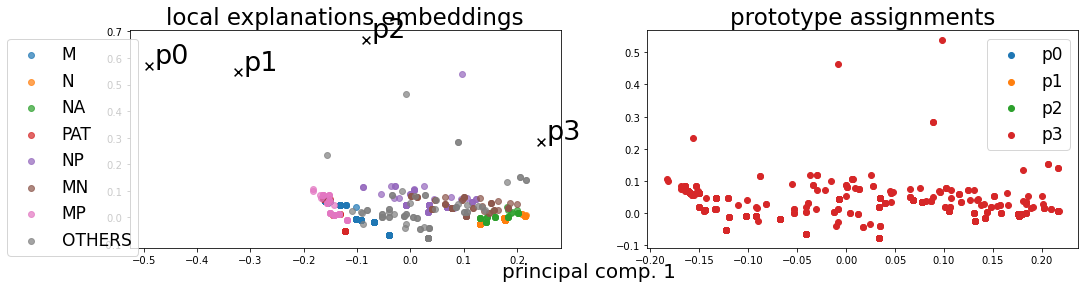

Alpha norms:
tensor([[0.7931, 0.8350, 1.0000, 0.9032],
        [1.0000, 0.8446, 0.9190, 0.7527]], grad_fn=<DivBackward0>)
Concept Purity: 0.364000 +- 0.000000
Concept distribution:  (array([3], dtype=int64), array([750], dtype=int64))
Logic formulas:
For class 0:
0.0 ()
For class 1:
0.0 ()
Accuracy as classifier:  0.0
LEN fidelity:  tensor(0.)

  1: Loss: 0.33819, LEN: 0.090700, AccxC: 0.58, AccO: 0.00, V. Acc: 0.00, V. Loss: 0.27823, V. LEN 0.09
  2: Loss: 0.25963, LEN: 0.090484, AccxC: 0.49, AccO: 0.00, V. Acc: 0.00, V. Loss: 0.22783, V. LEN 0.09
  3: Loss: 0.20898, LEN: 0.090245, AccxC: 0.42, AccO: 0.00, V. Acc: 0.00, V. Loss: 0.18290, V. LEN 0.09
  4: Loss: 0.16350, LEN: 0.090050, AccxC: 0.44, AccO: 0.00, V. Acc: 0.00, V. Loss: 0.14494, V. LEN 0.09
  5: Loss: 0.13554, LEN: 0.089742, AccxC: 0.57, AccO: 0.00, V. Acc: 0.00, V. Loss: 0.12614, V. LEN 0.09
  6: Loss: 0.12358, LEN: 0.089447, AccxC: 0.57, AccO: 0.00, V. Acc: 0.00, V. Loss: 0.12188, V. LEN 0.09
  7: Loss: 0.12099, LEN: 0.08

 77: Loss: 0.04710, LEN: 0.046152, AccxC: 0.88, AccO: 0.88, V. Acc: 0.88, V. Loss: 0.04603, V. LEN 0.05
 78: Loss: 0.04653, LEN: 0.045930, AccxC: 0.88, AccO: 0.88, V. Acc: 0.88, V. Loss: 0.04619, V. LEN 0.04
 79: Loss: 0.04635, LEN: 0.045724, AccxC: 0.87, AccO: 0.87, V. Acc: 0.88, V. Loss: 0.04605, V. LEN 0.04


 80: Loss: 0.04702, LEN: 0.046230, AccxC: 0.87, AccO: 0.87, V. Acc: 0.88, V. Loss: 0.04610, V. LEN 0.04
 81: Loss: 0.04706, LEN: 0.046166, AccxC: 0.88, AccO: 0.88, V. Acc: 0.88, V. Loss: 0.04820, V. LEN 0.05
 82: Loss: 0.04617, LEN: 0.045466, AccxC: 0.88, AccO: 0.88, V. Acc: 0.88, V. Loss: 0.04556, V. LEN 0.04
 83: Loss: 0.04585, LEN: 0.044816, AccxC: 0.88, AccO: 0.88, V. Acc: 0.88, V. Loss: 0.04556, V. LEN 0.04
 84: Loss: 0.04598, LEN: 0.045355, AccxC: 0.88, AccO: 0.88, V. Acc: 0.88, V. Loss: 0.04549, V. LEN 0.04
 85: Loss: 0.04599, LEN: 0.045219, AccxC: 0.88, AccO: 0.88, V. Acc: 0.88, V. Loss: 0.04782, V. LEN 0.05
 86: Loss: 0.04638, LEN: 0.045631, AccxC: 0.88, AccO: 0.88, V.

156: Loss: 0.04292, LEN: 0.042411, AccxC: 0.89, AccO: 0.89, V. Acc: 0.89, V. Loss: 0.04530, V. LEN 0.04
157: Loss: 0.04337, LEN: 0.042803, AccxC: 0.87, AccO: 0.87, V. Acc: 0.89, V. Loss: 0.04534, V. LEN 0.04
158: Loss: 0.04309, LEN: 0.042677, AccxC: 0.89, AccO: 0.89, V. Acc: 0.88, V. Loss: 0.04765, V. LEN 0.05
159: Loss: 0.04244, LEN: 0.042037, AccxC: 0.89, AccO: 0.89, V. Acc: 0.84, V. Loss: 0.04918, V. LEN 0.05


160: Loss: 0.04378, LEN: 0.043073, AccxC: 0.86, AccO: 0.86, V. Acc: 0.89, V. Loss: 0.04541, V. LEN 0.04
161: Loss: 0.04319, LEN: 0.042680, AccxC: 0.87, AccO: 0.87, V. Acc: 0.86, V. Loss: 0.05096, V. LEN 0.05
162: Loss: 0.04653, LEN: 0.045916, AccxC: 0.87, AccO: 0.87, V. Acc: 0.89, V. Loss: 0.04540, V. LEN 0.04
163: Loss: 0.04389, LEN: 0.043523, AccxC: 0.88, AccO: 0.88, V. Acc: 0.88, V. Loss: 0.04790, V. LEN 0.05
164: Loss: 0.04665, LEN: 0.046072, AccxC: 0.85, AccO: 0.85, V. Acc: 0.88, V. Loss: 0.04768, V. LEN 0.05
165: Loss: 0.04308, LEN: 0.042663, AccxC: 0.89, AccO: 0.89, V.

In [15]:
expls = []
for ITERATION_NUM in range(5):
    batch_sampler = utils.GroupBatchSampler(num_input_graphs=128, drop_last=False, belonging=np.array(belonging_train))
    train_group_loader = DataLoader(dataset_train, batch_sampler=batch_sampler)

    batch_sampler = utils.GroupBatchSampler(num_input_graphs=256, drop_last=False, belonging=np.array(belonging_val))
    val_group_loader = DataLoader(dataset_val, batch_sampler=batch_sampler)

    batch_sampler = utils.GroupBatchSampler(num_input_graphs=256, drop_last=False, belonging=np.array(belonging_test))
    test_group_loader = DataLoader(dataset_test, batch_sampler=batch_sampler)


    torch.manual_seed(42 + 10*ITERATION_NUM)
    hyper = {
        "len_lr": 0.0005,
        "proto_lr": 0.001,
        "le_emb_lr": 0.001,
        "coeff_divloss": 0.000,
        "coeff_pdist": 0.,
        "coeff_gae": 0.,
        "coeff_r1": 0.09,
        "coeff_r2": 0.00099,
        "coeff_ce": 0.0,
        "coeff_de": 0.,
        "coeff_logic_loss": 0.00,
        "focal_gamma": 2, #3
        "focal_alpha": -1,
        "ts": 1,
        "te": 1,
        "focal_loss": True,
        "debug_prototypes": False,
        "num_prototypes": 4,
        "dim_prototypes": 10,
        "num_le_features": 5,
        "activation": "leaky",
        "embedder_backbone": "GAT",
        "embedder_num_layers": 2,
        "assign_func": "straight_sim",
        "LEN_temperature": 1,
        "remove_attention": True,
        "log_images": True,
        "log_models": True,
        "num_epochs": 500
    }

    len_model    = models.LEN(hyper["num_prototypes"], 
                              hyper["LEN_temperature"], 
                              remove_attention=hyper["remove_attention"]).to(device)
    le_model     = models.LEEmbedder(num_features=hyper["num_le_features"], 
                                     activation=hyper["activation"], 
                                     num_hidden=hyper["dim_prototypes"],
                                     backbone=hyper["embedder_backbone"],
                                     num_layers=hyper["embedder_num_layers"]).to(device)
    expl         = models.GlobalExplainer(len_model, 
                                           le_model, 
                                           train_group_loader, 
                                           val_group_loader, 
                                           device, 
                                           hyper_params=hyper,
                                           classes_names=priori_etn_classes_names,
                                           dataset_name="ETN").to(device)
    expl.iterate(num_epochs=hyper["num_epochs"], log_wandb=False, name_wandb=ITERATION_NUM)
    expls.append(expl)
    
    #with open(f'../logs/model_focal_{use_focal}_BAMultiShapes.pkl', 'wb') as handle:
    #    pickle.dump(expl, handle)

In [22]:
batch_sampler = utils.GroupBatchSampler(num_input_graphs=128, drop_last=False, belonging=np.array(belonging_train))
train_group_loader = DataLoader(dataset_train, batch_sampler=batch_sampler)

batch_sampler = utils.GroupBatchSampler(num_input_graphs=256, drop_last=False, belonging=np.array(belonging_val))
val_group_loader = DataLoader(dataset_val, batch_sampler=batch_sampler)

batch_sampler = utils.GroupBatchSampler(num_input_graphs=256, drop_last=False, belonging=np.array(belonging_test))
test_group_loader = DataLoader(dataset_test, batch_sampler=batch_sampler)

Fidelity:
	 0.8904109597206116  @  363
	 0.8904109597206116  @  323
	 0.8904109597206116  @  110
	 0.8630136847496033  @  113
	 0.8904109597206116  @  99
(array([0., 1., 2., 3., 4., 5., 6., 7.], dtype=float32), array([38, 18,  4, 10, 14,  9,  8, 14], dtype=int64))


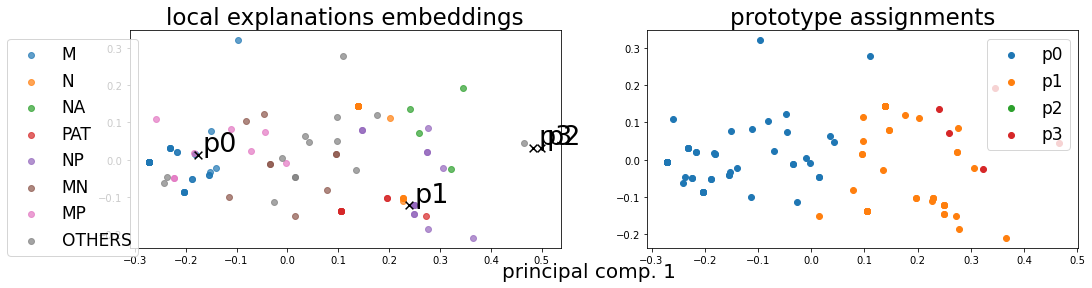

Alpha norms:
tensor([[1.0000, 0.3365, 0.4938, 0.4587],
        [0.8763, 1.0000, 0.6165, 0.7133]], grad_fn=<DivBackward0>)
Concept Purity: 0.597778 +- 0.181380
Concept distribution:  (array([0, 1, 3], dtype=int64), array([60, 50,  5], dtype=int64))
Logic formulas:
For class 0:
0.8347826086956521 ((feature001) | (feature003)
For class 1:
0.8347826086956521 (feature000)
Accuracy as classifier:  0.8348
LEN fidelity:  tensor(0.8348)

(array([0., 1., 2., 3., 4., 5., 6., 7.], dtype=float32), array([38, 18,  4, 10, 14,  9,  8, 14], dtype=int64))


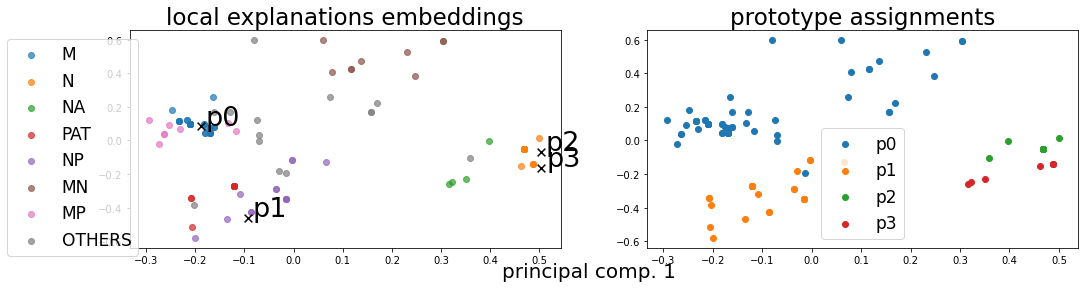

Alpha norms:
tensor([[1.0000, 0.3902, 0.2740, 0.7385],
        [1.0000, 0.3484, 0.2031, 0.4576]], grad_fn=<DivBackward0>)
Concept Purity: 0.640162 +- 0.136349
Concept distribution:  (array([0, 1, 2, 3], dtype=int64), array([66, 26, 16,  7], dtype=int64))
Logic formulas:
For class 0:
0.8695652173913043 (feature001) | ((feature002) | (feature003)
For class 1:
0.8695652173913043 (feature000)
Accuracy as classifier:  0.8696
LEN fidelity:  tensor(0.8696)

(array([0., 1., 2., 3., 4., 5., 6., 7.], dtype=float32), array([38, 18,  4, 10, 14,  9,  8, 14], dtype=int64))


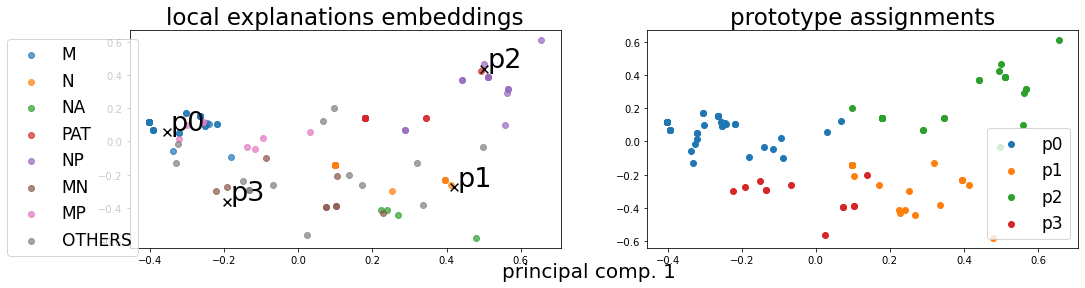

Alpha norms:
tensor([[0.9907, 0.7188, 1.0000, 0.3343],
        [1.0000, 0.5339, 0.7855, 0.1644]], grad_fn=<DivBackward0>)
Concept Purity: 0.616282 +- 0.103406
Concept distribution:  (array([0, 1, 2, 3], dtype=int64), array([50, 27, 26, 12], dtype=int64))
Logic formulas:
For class 0:
0.8521739130434782 (feature002) | (feature001)
For class 1:
0.8521739130434782 (feature000) | ((feature003)
Accuracy as classifier:  0.8522
LEN fidelity:  tensor(0.8522)

(array([0., 1., 2., 3., 4., 5., 6., 7.], dtype=float32), array([38, 18,  4, 10, 14,  9,  8, 14], dtype=int64))


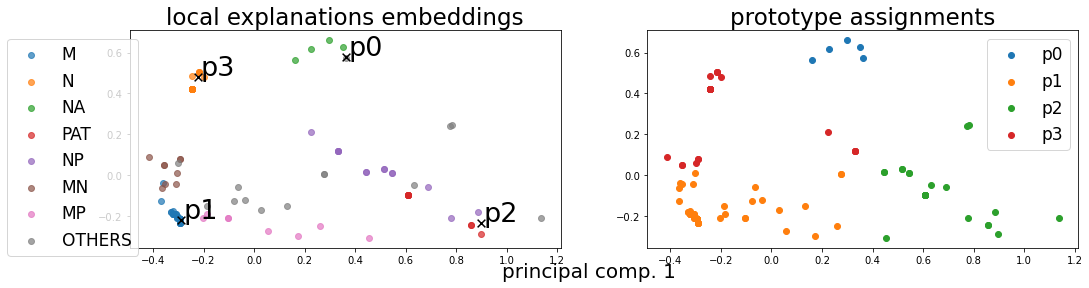

Alpha norms:
tensor([[0.5398, 1.0000, 0.4623, 0.6315],
        [0.7815, 1.0000, 0.9093, 0.7851]], grad_fn=<DivBackward0>)
Concept Purity: 0.626006 +- 0.137639
Concept distribution:  (array([0, 1, 2, 3], dtype=int64), array([ 5, 57, 24, 29], dtype=int64))
Logic formulas:
For class 0:
0.808695652173913 (feature003) | ((feature002) | (feature000)
For class 1:
0.808695652173913 (feature001)
Accuracy as classifier:  0.8087
LEN fidelity:  tensor(0.8087)

(array([0., 1., 2., 3., 4., 5., 6., 7.], dtype=float32), array([38, 18,  4, 10, 14,  9,  8, 14], dtype=int64))


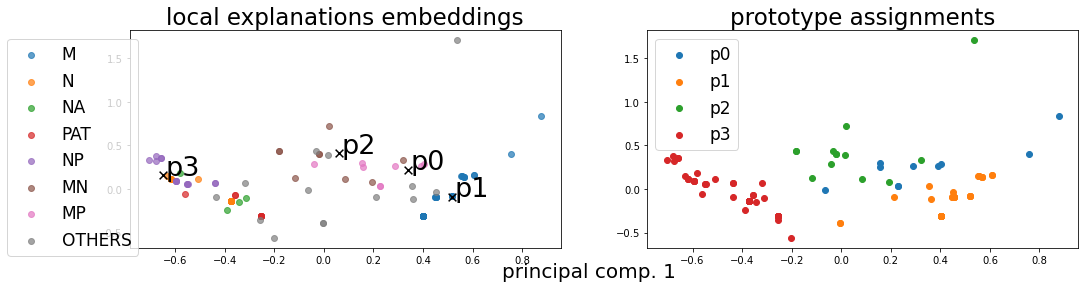

Alpha norms:
tensor([[0.7197, 0.9029, 0.2472, 1.0000],
        [0.5002, 1.0000, 0.0995, 0.4128]], grad_fn=<DivBackward0>)
Concept Purity: 0.652363 +- 0.181160
Concept distribution:  (array([0, 1, 2, 3], dtype=int64), array([10, 42, 13, 50], dtype=int64))
Logic formulas:
For class 0:
0.8608695652173913 (feature003)
For class 1:
0.8608695652173913 (feature001) | ((feature002) | (feature000)
Accuracy as classifier:  0.8609
LEN fidelity:  tensor(0.8609)



In [23]:
print("Fidelity:")
for i , m in enumerate(expls):
    print("\t", [e["acc_overall"] for e in m.val_metrics][m.early_stopping.best_epoch-1].item(), " @ ", m.early_stopping.best_epoch)
    
for i , m in enumerate(expls):
    m.inspect_embedding(test_group_loader)

In [25]:
fidelities = [0.878, 0.8609, 0.8696, 0.8087, 0.8522]
print("Fidelity: ", np.mean(fidelities), np.std(fidelities))

acc = [0.8348, 0.8696, 0.8522, 0.8087, 0.8609]
print("Acc: ", np.mean(acc), np.std(acc))

Fidelity:  0.85388 0.024175309718801965
Acc:  0.8452400000000001 0.021592832144024104


## Num prototypes

(array([0., 1., 2., 3., 4., 5., 6., 7.], dtype=float32), array([273, 139,  32,  51,  65,  58,  42,  90], dtype=int64))


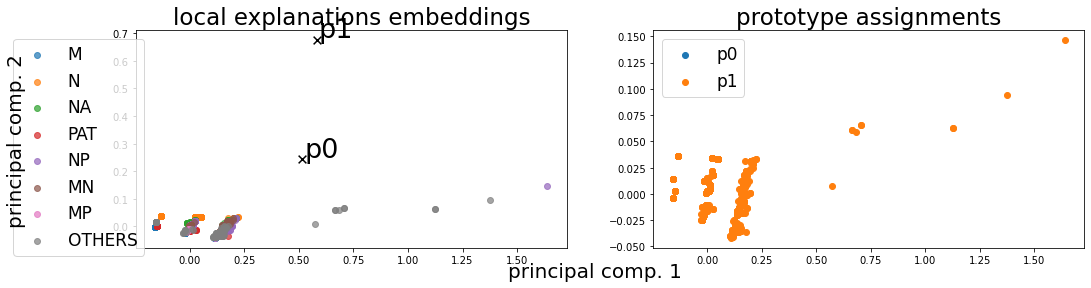

Alpha norms:
tensor([[1.0000, 0.6722],
        [0.7495, 1.0000]], grad_fn=<DivBackward0>)
Concept Purity: 0.364000 +- 0.000000
Concept distribution:  (array([1], dtype=int64), array([750], dtype=int64))
Logic formulas:
For class 0:
0.0 ()
For class 1:
0.0 ()
Accuracy as classifier:  0.0
LEN fidelity:  tensor(0.)

  1: Loss: 0.22118, LEN: 0.086605, AccxC: 0.57, AccO: 0.00, V. Acc: 0.00, V. Loss: 0.20107, V. LEN 0.09
  2: Loss: 0.19579, LEN: 0.086547, AccxC: 0.57, AccO: 0.00, V. Acc: 0.00, V. Loss: 0.18665, V. LEN 0.09
  3: Loss: 0.17726, LEN: 0.086474, AccxC: 0.57, AccO: 0.00, V. Acc: 0.00, V. Loss: 0.16109, V. LEN 0.09
  4: Loss: 0.14809, LEN: 0.086422, AccxC: 0.57, AccO: 0.00, V. Acc: 0.00, V. Loss: 0.13338, V. LEN 0.09
  5: Loss: 0.12611, LEN: 0.086371, AccxC: 0.57, AccO: 0.00, V. Acc: 0.51, V. Loss: 0.11855, V. LEN 0.09
  6: Loss: 0.11414, LEN: 0.086237, AccxC: 0.57, AccO: 0.57, V. Acc: 0.45, V. Loss: 0.11044, V. LEN 0.09
  7: Loss: 0.10860, LEN: 0.086245, AccxC: 0.57, AccO: 0.41, V

 77: Loss: 0.04690, LEN: 0.046705, AccxC: 0.89, AccO: 0.89, V. Acc: 0.86, V. Loss: 0.05248, V. LEN 0.05
 78: Loss: 0.04732, LEN: 0.047103, AccxC: 0.89, AccO: 0.89, V. Acc: 0.86, V. Loss: 0.05252, V. LEN 0.05
 79: Loss: 0.04666, LEN: 0.046436, AccxC: 0.89, AccO: 0.89, V. Acc: 0.86, V. Loss: 0.05228, V. LEN 0.05


 80: Loss: 0.04672, LEN: 0.046408, AccxC: 0.89, AccO: 0.89, V. Acc: 0.86, V. Loss: 0.05226, V. LEN 0.05
 81: Loss: 0.04613, LEN: 0.045941, AccxC: 0.89, AccO: 0.89, V. Acc: 0.86, V. Loss: 0.05217, V. LEN 0.05
 82: Loss: 0.04672, LEN: 0.046559, AccxC: 0.89, AccO: 0.89, V. Acc: 0.88, V. Loss: 0.04931, V. LEN 0.05
 83: Loss: 0.04571, LEN: 0.045529, AccxC: 0.89, AccO: 0.89, V. Acc: 0.88, V. Loss: 0.04930, V. LEN 0.05
 84: Loss: 0.04639, LEN: 0.046138, AccxC: 0.89, AccO: 0.89, V. Acc: 0.86, V. Loss: 0.05232, V. LEN 0.05
 85: Loss: 0.04729, LEN: 0.047075, AccxC: 0.89, AccO: 0.89, V. Acc: 0.86, V. Loss: 0.05233, V. LEN 0.05
 86: Loss: 0.04644, LEN: 0.046214, AccxC: 0.89, AccO: 0.89, V.

156: Loss: 0.04753, LEN: 0.047271, AccxC: 0.88, AccO: 0.88, V. Acc: 0.86, V. Loss: 0.05232, V. LEN 0.05
157: Loss: 0.04810, LEN: 0.047784, AccxC: 0.88, AccO: 0.88, V. Acc: 0.86, V. Loss: 0.05215, V. LEN 0.05
158: Loss: 0.04693, LEN: 0.046635, AccxC: 0.88, AccO: 0.88, V. Acc: 0.86, V. Loss: 0.05229, V. LEN 0.05
159: Loss: 0.04777, LEN: 0.047517, AccxC: 0.88, AccO: 0.88, V. Acc: 0.86, V. Loss: 0.05220, V. LEN 0.05


160: Loss: 0.04654, LEN: 0.046105, AccxC: 0.89, AccO: 0.89, V. Acc: 0.86, V. Loss: 0.05220, V. LEN 0.05
161: Loss: 0.04821, LEN: 0.047924, AccxC: 0.88, AccO: 0.88, V. Acc: 0.86, V. Loss: 0.05231, V. LEN 0.05
162: Loss: 0.04690, LEN: 0.046558, AccxC: 0.89, AccO: 0.89, V. Acc: 0.88, V. Loss: 0.04956, V. LEN 0.05
163: Loss: 0.04719, LEN: 0.046842, AccxC: 0.89, AccO: 0.89, V. Acc: 0.77, V. Loss: 0.08550, V. LEN 0.09
164: Loss: 0.05622, LEN: 0.055830, AccxC: 0.85, AccO: 0.85, V. Acc: 0.86, V. Loss: 0.05231, V. LEN 0.05
165: Loss: 0.04855, LEN: 0.048139, AccxC: 0.88, AccO: 0.88, V.

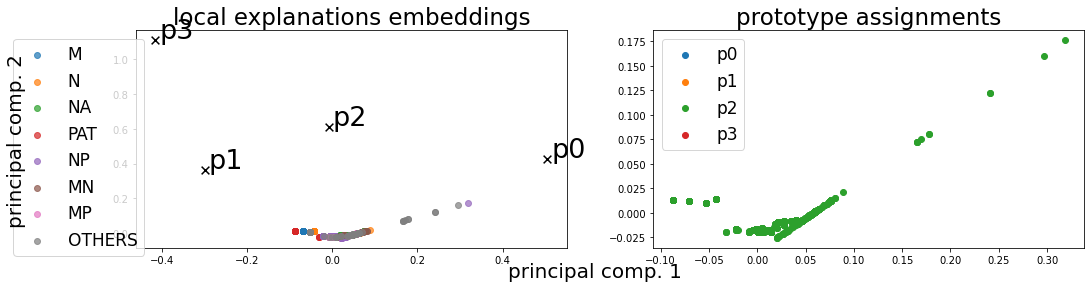

Alpha norms:
tensor([[1.0000, 0.8459, 0.8427, 0.9224],
        [0.8005, 0.7799, 1.0000, 0.8565]], grad_fn=<DivBackward0>)
Concept Purity: 0.364000 +- 0.000000
Concept distribution:  (array([2], dtype=int64), array([750], dtype=int64))
Logic formulas:
For class 0:
0.0 ()
For class 1:
0.0 ()
Accuracy as classifier:  0.0
LEN fidelity:  tensor(0.)

  1: Loss: 0.27936, LEN: 0.096436, AccxC: 0.57, AccO: 0.00, V. Acc: 0.00, V. Loss: 0.24028, V. LEN 0.10
  2: Loss: 0.22880, LEN: 0.095958, AccxC: 0.57, AccO: 0.00, V. Acc: 0.00, V. Loss: 0.20413, V. LEN 0.10
  3: Loss: 0.19641, LEN: 0.095704, AccxC: 0.58, AccO: 0.00, V. Acc: 0.00, V. Loss: 0.18034, V. LEN 0.10
  4: Loss: 0.17632, LEN: 0.096038, AccxC: 0.58, AccO: 0.00, V. Acc: 0.00, V. Loss: 0.17273, V. LEN 0.10
  5: Loss: 0.16546, LEN: 0.095490, AccxC: 0.58, AccO: 0.00, V. Acc: 0.00, V. Loss: 0.16448, V. LEN 0.10
  6: Loss: 0.16153, LEN: 0.094870, AccxC: 0.58, AccO: 0.00, V. Acc: 0.00, V. Loss: 0.15797, V. LEN 0.09
  7: Loss: 0.14867, LEN: 0.09

 77: Loss: 0.05610, LEN: 0.056050, AccxC: 0.88, AccO: 0.88, V. Acc: 0.86, V. Loss: 0.05842, V. LEN 0.06
 78: Loss: 0.05520, LEN: 0.055145, AccxC: 0.88, AccO: 0.88, V. Acc: 0.86, V. Loss: 0.05787, V. LEN 0.06
 79: Loss: 0.05465, LEN: 0.054560, AccxC: 0.88, AccO: 0.88, V. Acc: 0.86, V. Loss: 0.05697, V. LEN 0.06


 80: Loss: 0.05341, LEN: 0.053300, AccxC: 0.88, AccO: 0.88, V. Acc: 0.86, V. Loss: 0.05586, V. LEN 0.06
 81: Loss: 0.05257, LEN: 0.052417, AccxC: 0.88, AccO: 0.88, V. Acc: 0.86, V. Loss: 0.05528, V. LEN 0.06
 82: Loss: 0.05123, LEN: 0.051101, AccxC: 0.89, AccO: 0.89, V. Acc: 0.86, V. Loss: 0.05452, V. LEN 0.05
 83: Loss: 0.05065, LEN: 0.050403, AccxC: 0.88, AccO: 0.88, V. Acc: 0.86, V. Loss: 0.05382, V. LEN 0.05
 84: Loss: 0.04980, LEN: 0.049687, AccxC: 0.88, AccO: 0.88, V. Acc: 0.86, V. Loss: 0.05326, V. LEN 0.05
 85: Loss: 0.04869, LEN: 0.048590, AccxC: 0.89, AccO: 0.89, V. Acc: 0.86, V. Loss: 0.05281, V. LEN 0.05
 86: Loss: 0.04890, LEN: 0.048821, AccxC: 0.88, AccO: 0.88, V.

156: Loss: 0.04569, LEN: 0.045590, AccxC: 0.89, AccO: 0.89, V. Acc: 0.88, V. Loss: 0.04772, V. LEN 0.05
157: Loss: 0.04589, LEN: 0.045799, AccxC: 0.89, AccO: 0.89, V. Acc: 0.86, V. Loss: 0.05037, V. LEN 0.05
158: Loss: 0.04708, LEN: 0.046941, AccxC: 0.88, AccO: 0.88, V. Acc: 0.88, V. Loss: 0.04783, V. LEN 0.05
159: Loss: 0.04554, LEN: 0.045348, AccxC: 0.89, AccO: 0.89, V. Acc: 0.86, V. Loss: 0.05039, V. LEN 0.05


160: Loss: 0.04782, LEN: 0.047402, AccxC: 0.88, AccO: 0.88, V. Acc: 0.88, V. Loss: 0.04776, V. LEN 0.05
161: Loss: 0.04733, LEN: 0.047188, AccxC: 0.88, AccO: 0.88, V. Acc: 0.86, V. Loss: 0.05036, V. LEN 0.05
162: Loss: 0.04652, LEN: 0.046409, AccxC: 0.88, AccO: 0.88, V. Acc: 0.88, V. Loss: 0.04775, V. LEN 0.05
163: Loss: 0.04647, LEN: 0.046356, AccxC: 0.89, AccO: 0.89, V. Acc: 0.86, V. Loss: 0.05031, V. LEN 0.05
164: Loss: 0.04717, LEN: 0.047072, AccxC: 0.88, AccO: 0.88, V. Acc: 0.88, V. Loss: 0.04769, V. LEN 0.05
165: Loss: 0.04749, LEN: 0.047366, AccxC: 0.88, AccO: 0.88, V.

235: Loss: 0.04365, LEN: 0.043492, AccxC: 0.89, AccO: 0.89, V. Acc: 0.88, V. Loss: 0.04688, V. LEN 0.05
236: Loss: 0.04434, LEN: 0.044194, AccxC: 0.89, AccO: 0.89, V. Acc: 0.84, V. Loss: 0.05582, V. LEN 0.06
237: Loss: 0.04487, LEN: 0.044680, AccxC: 0.88, AccO: 0.88, V. Acc: 0.88, V. Loss: 0.04692, V. LEN 0.05
238: Loss: 0.04782, LEN: 0.047662, AccxC: 0.88, AccO: 0.88, V. Acc: 0.84, V. Loss: 0.05570, V. LEN 0.06
239: Loss: 0.04692, LEN: 0.046754, AccxC: 0.88, AccO: 0.88, V. Acc: 0.88, V. Loss: 0.04690, V. LEN 0.05


240: Loss: 0.04469, LEN: 0.044514, AccxC: 0.89, AccO: 0.89, V. Acc: 0.85, V. Loss: 0.05488, V. LEN 0.05
241: Loss: 0.04681, LEN: 0.046575, AccxC: 0.87, AccO: 0.87, V. Acc: 0.88, V. Loss: 0.04776, V. LEN 0.05
242: Loss: 0.04522, LEN: 0.044914, AccxC: 0.89, AccO: 0.89, V. Acc: 0.84, V. Loss: 0.05761, V. LEN 0.06
243: Loss: 0.04652, LEN: 0.046199, AccxC: 0.88, AccO: 0.88, V. Acc: 0.86, V. Loss: 0.05211, V. LEN 0.05
244: Loss: 0.04415, LEN: 0.043947, AccxC: 0.89, AccO: 0.89, V.

314: Loss: 0.04500, LEN: 0.044830, AccxC: 0.89, AccO: 0.89, V. Acc: 0.86, V. Loss: 0.05050, V. LEN 0.05
315: Loss: 0.04478, LEN: 0.044613, AccxC: 0.89, AccO: 0.89, V. Acc: 0.88, V. Loss: 0.04710, V. LEN 0.05
316: Loss: 0.04422, LEN: 0.044034, AccxC: 0.89, AccO: 0.89, V. Acc: 0.88, V. Loss: 0.04699, V. LEN 0.05
317: Loss: 0.04584, LEN: 0.045653, AccxC: 0.89, AccO: 0.89, V. Acc: 0.86, V. Loss: 0.05072, V. LEN 0.05
318: Loss: 0.04593, LEN: 0.045699, AccxC: 0.88, AccO: 0.88, V. Acc: 0.89, V. Loss: 0.04436, V. LEN 0.04
319: Loss: 0.04380, LEN: 0.043594, AccxC: 0.89, AccO: 0.89, V. Acc: 0.88, V. Loss: 0.04699, V. LEN 0.05


320: Loss: 0.04617, LEN: 0.045916, AccxC: 0.88, AccO: 0.88, V. Acc: 0.89, V. Loss: 0.04330, V. LEN 0.04
321: Loss: 0.04443, LEN: 0.044160, AccxC: 0.89, AccO: 0.89, V. Acc: 0.89, V. Loss: 0.04438, V. LEN 0.04
322: Loss: 0.04572, LEN: 0.045523, AccxC: 0.88, AccO: 0.88, V. Acc: 0.86, V. Loss: 0.05179, V. LEN 0.05
323: Loss: 0.04232, LEN: 0.042111, AccxC: 0.90, AccO: 0.90, V.

393: Loss: 0.04616, LEN: 0.045965, AccxC: 0.89, AccO: 0.89, V. Acc: 0.86, V. Loss: 0.05044, V. LEN 0.05
394: Loss: 0.04382, LEN: 0.043602, AccxC: 0.89, AccO: 0.89, V. Acc: 0.82, V. Loss: 0.05469, V. LEN 0.05
395: Loss: 0.04686, LEN: 0.046696, AccxC: 0.89, AccO: 0.89, V. Acc: 0.86, V. Loss: 0.04814, V. LEN 0.05
396: Loss: 0.04675, LEN: 0.046612, AccxC: 0.87, AccO: 0.87, V. Acc: 0.86, V. Loss: 0.04815, V. LEN 0.05
397: Loss: 0.04588, LEN: 0.045727, AccxC: 0.89, AccO: 0.89, V. Acc: 0.86, V. Loss: 0.04813, V. LEN 0.05
398: Loss: 0.04344, LEN: 0.043288, AccxC: 0.89, AccO: 0.89, V. Acc: 0.86, V. Loss: 0.04816, V. LEN 0.05
399: Loss: 0.04422, LEN: 0.044025, AccxC: 0.89, AccO: 0.89, V. Acc: 0.86, V. Loss: 0.04937, V. LEN 0.05


400: Loss: 0.04435, LEN: 0.044193, AccxC: 0.88, AccO: 0.88, V. Acc: 0.86, V. Loss: 0.04812, V. LEN 0.05
401: Loss: 0.04527, LEN: 0.045128, AccxC: 0.89, AccO: 0.89, V. Acc: 0.86, V. Loss: 0.04810, V. LEN 0.05
402: Loss: 0.04342, LEN: 0.043267, AccxC: 0.89, AccO: 0.89, V.

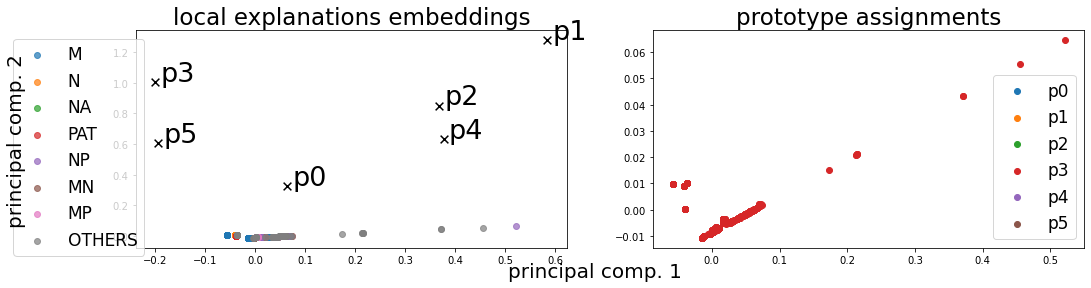

Alpha norms:
tensor([[0.9595, 1.0000, 0.9094, 0.7717, 0.9062, 0.8726],
        [0.8822, 0.8649, 0.8276, 1.0000, 0.9040, 0.7665]],
       grad_fn=<DivBackward0>)
Concept Purity: 0.364000 +- 0.000000
Concept distribution:  (array([3], dtype=int64), array([750], dtype=int64))
Logic formulas:
For class 0:
0.0 ()
For class 1:
0.0 ()
Accuracy as classifier:  0.0
LEN fidelity:  tensor(0.)

  1: Loss: 0.43995, LEN: 0.101010, AccxC: 0.57, AccO: 0.00, V. Acc: 0.00, V. Loss: 0.39465, V. LEN 0.10
  2: Loss: 0.37109, LEN: 0.100615, AccxC: 0.58, AccO: 0.00, V. Acc: 0.00, V. Loss: 0.32681, V. LEN 0.10
  3: Loss: 0.31049, LEN: 0.100224, AccxC: 0.58, AccO: 0.00, V. Acc: 0.00, V. Loss: 0.26954, V. LEN 0.10
  4: Loss: 0.24782, LEN: 0.099841, AccxC: 0.58, AccO: 0.00, V. Acc: 0.00, V. Loss: 0.21752, V. LEN 0.10
  5: Loss: 0.20521, LEN: 0.099464, AccxC: 0.57, AccO: 0.00, V. Acc: 0.00, V. Loss: 0.19428, V. LEN 0.10
  6: Loss: 0.18853, LEN: 0.099090, AccxC: 0.59, AccO: 0.00, V. Acc: 0.00, V. Loss: 0.18209, V.

 77: Loss: 0.05249, LEN: 0.051661, AccxC: 0.87, AccO: 0.87, V. Acc: 0.86, V. Loss: 0.05214, V. LEN 0.05
 78: Loss: 0.05145, LEN: 0.050759, AccxC: 0.87, AccO: 0.87, V. Acc: 0.86, V. Loss: 0.05172, V. LEN 0.05
 79: Loss: 0.05103, LEN: 0.050317, AccxC: 0.87, AccO: 0.87, V. Acc: 0.86, V. Loss: 0.05206, V. LEN 0.05


 80: Loss: 0.05062, LEN: 0.049898, AccxC: 0.87, AccO: 0.87, V. Acc: 0.86, V. Loss: 0.05083, V. LEN 0.05
 81: Loss: 0.05128, LEN: 0.050519, AccxC: 0.87, AccO: 0.87, V. Acc: 0.88, V. Loss: 0.04997, V. LEN 0.05
 82: Loss: 0.04930, LEN: 0.048611, AccxC: 0.88, AccO: 0.88, V. Acc: 0.86, V. Loss: 0.04985, V. LEN 0.05
 83: Loss: 0.04888, LEN: 0.048206, AccxC: 0.88, AccO: 0.88, V. Acc: 0.86, V. Loss: 0.05192, V. LEN 0.05
 84: Loss: 0.04869, LEN: 0.047847, AccxC: 0.88, AccO: 0.88, V. Acc: 0.88, V. Loss: 0.04933, V. LEN 0.05
 85: Loss: 0.04893, LEN: 0.048458, AccxC: 0.87, AccO: 0.87, V. Acc: 0.88, V. Loss: 0.04952, V. LEN 0.05
 86: Loss: 0.04856, LEN: 0.048053, AccxC: 0.88, AccO: 0.88, V.

156: Loss: 0.04508, LEN: 0.044844, AccxC: 0.89, AccO: 0.89, V. Acc: 0.89, V. Loss: 0.04557, V. LEN 0.05
157: Loss: 0.04587, LEN: 0.045524, AccxC: 0.89, AccO: 0.89, V. Acc: 0.82, V. Loss: 0.06754, V. LEN 0.07
158: Loss: 0.04962, LEN: 0.049392, AccxC: 0.87, AccO: 0.87, V. Acc: 0.88, V. Loss: 0.04997, V. LEN 0.05
159: Loss: 0.04546, LEN: 0.045221, AccxC: 0.89, AccO: 0.89, V. Acc: 0.88, V. Loss: 0.05022, V. LEN 0.05


160: Loss: 0.04582, LEN: 0.045627, AccxC: 0.89, AccO: 0.89, V. Acc: 0.89, V. Loss: 0.04579, V. LEN 0.05
161: Loss: 0.05102, LEN: 0.050557, AccxC: 0.87, AccO: 0.87, V. Acc: 0.88, V. Loss: 0.04813, V. LEN 0.05
162: Loss: 0.04450, LEN: 0.044074, AccxC: 0.89, AccO: 0.89, V. Acc: 0.88, V. Loss: 0.05043, V. LEN 0.05
163: Loss: 0.04626, LEN: 0.045905, AccxC: 0.89, AccO: 0.89, V. Acc: 0.88, V. Loss: 0.04800, V. LEN 0.05
164: Loss: 0.04618, LEN: 0.045755, AccxC: 0.89, AccO: 0.89, V. Acc: 0.88, V. Loss: 0.05027, V. LEN 0.05
165: Loss: 0.04494, LEN: 0.044636, AccxC: 0.89, AccO: 0.89, V.

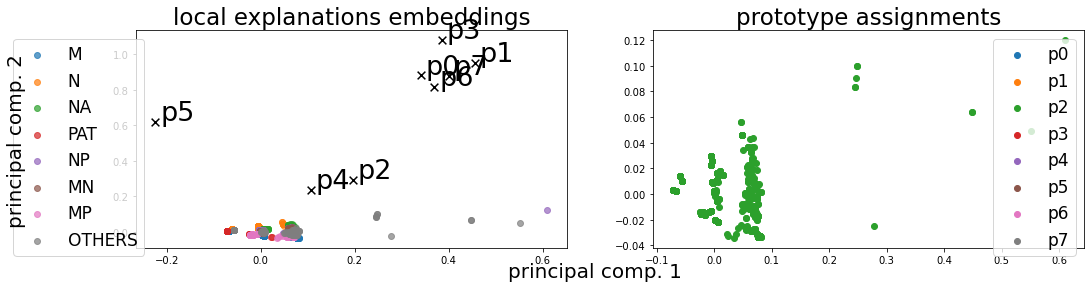

Alpha norms:
tensor([[1.0000, 0.7935, 0.9836, 0.9568, 0.8002, 0.8796, 0.8436, 0.8286],
        [0.8038, 0.9233, 0.9012, 0.9027, 1.0000, 0.9723, 0.8571, 0.9484]],
       grad_fn=<DivBackward0>)
Concept Purity: 0.364000 +- 0.000000
Concept distribution:  (array([2], dtype=int64), array([750], dtype=int64))
Logic formulas:
For class 0:
0.0 ()
For class 1:
0.0 ()
Accuracy as classifier:  0.0
LEN fidelity:  tensor(0.)

  1: Loss: 0.33280, LEN: 0.086644, AccxC: 0.58, AccO: 0.00, V. Acc: 0.00, V. Loss: 0.30316, V. LEN 0.09
  2: Loss: 0.29465, LEN: 0.086304, AccxC: 0.67, AccO: 0.05, V. Acc: 0.37, V. Loss: 0.27161, V. LEN 0.09
  3: Loss: 0.26105, LEN: 0.086544, AccxC: 0.52, AccO: 0.45, V. Acc: 0.37, V. Loss: 0.24310, V. LEN 0.09
  4: Loss: 0.23671, LEN: 0.086691, AccxC: 0.43, AccO: 0.35, V. Acc: 0.14, V. Loss: 0.22385, V. LEN 0.09
  5: Loss: 0.20652, LEN: 0.086654, AccxC: 0.58, AccO: 0.23, V. Acc: 0.51, V. Loss: 0.18895, V. LEN 0.09
  6: Loss: 0.17172, LEN: 0.086610, AccxC: 0.58, AccO: 0.57, V.

 76: Loss: 0.04788, LEN: 0.046331, AccxC: 0.87, AccO: 0.87, V. Acc: 0.89, V. Loss: 0.04569, V. LEN 0.04
 77: Loss: 0.04712, LEN: 0.046239, AccxC: 0.87, AccO: 0.87, V. Acc: 0.89, V. Loss: 0.04529, V. LEN 0.04
 78: Loss: 0.04700, LEN: 0.045284, AccxC: 0.87, AccO: 0.87, V. Acc: 0.89, V. Loss: 0.04528, V. LEN 0.04
 79: Loss: 0.04694, LEN: 0.046250, AccxC: 0.87, AccO: 0.87, V. Acc: 0.89, V. Loss: 0.04517, V. LEN 0.04


 80: Loss: 0.04566, LEN: 0.044800, AccxC: 0.87, AccO: 0.87, V. Acc: 0.89, V. Loss: 0.04459, V. LEN 0.04
 81: Loss: 0.04612, LEN: 0.045039, AccxC: 0.87, AccO: 0.87, V. Acc: 0.89, V. Loss: 0.04509, V. LEN 0.04
 82: Loss: 0.04689, LEN: 0.045586, AccxC: 0.87, AccO: 0.87, V. Acc: 0.89, V. Loss: 0.04543, V. LEN 0.04
 83: Loss: 0.04623, LEN: 0.045115, AccxC: 0.87, AccO: 0.87, V. Acc: 0.89, V. Loss: 0.04421, V. LEN 0.04
 84: Loss: 0.04596, LEN: 0.044820, AccxC: 0.87, AccO: 0.87, V. Acc: 0.89, V. Loss: 0.04512, V. LEN 0.04
 85: Loss: 0.04518, LEN: 0.044119, AccxC: 0.88, AccO: 0.88, V.

155: Loss: 0.04138, LEN: 0.040626, AccxC: 0.89, AccO: 0.89, V. Acc: 0.85, V. Loss: 0.04276, V. LEN 0.04
156: Loss: 0.04177, LEN: 0.041030, AccxC: 0.89, AccO: 0.89, V. Acc: 0.88, V. Loss: 0.04153, V. LEN 0.04
157: Loss: 0.04118, LEN: 0.040157, AccxC: 0.89, AccO: 0.89, V. Acc: 0.84, V. Loss: 0.04729, V. LEN 0.05
158: Loss: 0.04875, LEN: 0.047882, AccxC: 0.87, AccO: 0.87, V. Acc: 0.88, V. Loss: 0.04130, V. LEN 0.04
159: Loss: 0.04180, LEN: 0.041022, AccxC: 0.89, AccO: 0.89, V. Acc: 0.88, V. Loss: 0.04084, V. LEN 0.04


160: Loss: 0.04186, LEN: 0.041125, AccxC: 0.89, AccO: 0.89, V. Acc: 0.88, V. Loss: 0.04105, V. LEN 0.04
161: Loss: 0.04252, LEN: 0.041929, AccxC: 0.89, AccO: 0.89, V. Acc: 0.86, V. Loss: 0.04167, V. LEN 0.04
162: Loss: 0.04233, LEN: 0.041595, AccxC: 0.88, AccO: 0.88, V. Acc: 0.88, V. Loss: 0.04126, V. LEN 0.04
163: Loss: 0.04205, LEN: 0.041444, AccxC: 0.89, AccO: 0.89, V. Acc: 0.86, V. Loss: 0.04201, V. LEN 0.04
164: Loss: 0.04408, LEN: 0.043371, AccxC: 0.89, AccO: 0.89, V.

234: Loss: 0.04353, LEN: 0.042941, AccxC: 0.89, AccO: 0.89, V. Acc: 0.88, V. Loss: 0.04679, V. LEN 0.05
235: Loss: 0.04269, LEN: 0.041997, AccxC: 0.89, AccO: 0.89, V. Acc: 0.88, V. Loss: 0.04099, V. LEN 0.04
236: Loss: 0.04210, LEN: 0.041623, AccxC: 0.90, AccO: 0.90, V. Acc: 0.88, V. Loss: 0.04088, V. LEN 0.04
237: Loss: 0.04144, LEN: 0.041008, AccxC: 0.89, AccO: 0.89, V. Acc: 0.88, V. Loss: 0.04082, V. LEN 0.04
238: Loss: 0.04189, LEN: 0.041468, AccxC: 0.90, AccO: 0.90, V. Acc: 0.88, V. Loss: 0.04090, V. LEN 0.04
239: Loss: 0.04221, LEN: 0.041599, AccxC: 0.89, AccO: 0.89, V. Acc: 0.88, V. Loss: 0.04679, V. LEN 0.05


240: Loss: 0.04203, LEN: 0.041551, AccxC: 0.89, AccO: 0.89, V. Acc: 0.88, V. Loss: 0.04084, V. LEN 0.04
241: Loss: 0.04227, LEN: 0.041723, AccxC: 0.90, AccO: 0.90, V. Acc: 0.88, V. Loss: 0.04079, V. LEN 0.04
242: Loss: 0.04108, LEN: 0.040604, AccxC: 0.89, AccO: 0.89, V. Acc: 0.88, V. Loss: 0.04378, V. LEN 0.04
243: Loss: 0.04101, LEN: 0.040545, AccxC: 0.90, AccO: 0.90, V.

313: Loss: 0.04223, LEN: 0.041902, AccxC: 0.89, AccO: 0.89, V. Acc: 0.88, V. Loss: 0.04441, V. LEN 0.04
314: Loss: 0.04672, LEN: 0.046256, AccxC: 0.88, AccO: 0.88, V. Acc: 0.88, V. Loss: 0.04410, V. LEN 0.04
315: Loss: 0.04305, LEN: 0.042580, AccxC: 0.90, AccO: 0.90, V. Acc: 0.88, V. Loss: 0.04679, V. LEN 0.05
316: Loss: 0.04119, LEN: 0.040754, AccxC: 0.89, AccO: 0.89, V. Acc: 0.86, V. Loss: 0.04856, V. LEN 0.05
317: Loss: 0.04276, LEN: 0.042297, AccxC: 0.90, AccO: 0.90, V. Acc: 0.86, V. Loss: 0.04916, V. LEN 0.05
318: Loss: 0.04072, LEN: 0.040363, AccxC: 0.90, AccO: 0.90, V. Acc: 0.86, V. Loss: 0.04877, V. LEN 0.05
319: Loss: 0.04606, LEN: 0.045697, AccxC: 0.89, AccO: 0.89, V. Acc: 0.88, V. Loss: 0.04695, V. LEN 0.05
Early Stopping
Loading model at epoch 218
Best epoch: 218
Trained lasted for 183 seconds


In [8]:
for num_proto in [2, 4, 6, 8]:
    batch_sampler = utils.GroupBatchSampler(num_input_graphs=128, drop_last=False, belonging=np.array(belonging_train))
    train_group_loader = DataLoader(dataset_train, batch_sampler=batch_sampler)

    batch_sampler = utils.GroupBatchSampler(num_input_graphs=256, drop_last=False, belonging=np.array(belonging_val))
    val_group_loader = DataLoader(dataset_val, batch_sampler=batch_sampler)

    batch_sampler = utils.GroupBatchSampler(num_input_graphs=256, drop_last=False, belonging=np.array(belonging_test))
    test_group_loader = DataLoader(dataset_test, batch_sampler=batch_sampler)

    torch.manual_seed(42)
    hyper = {
        "len_lr": 0.0005,
        "proto_lr": 0.001,
        "le_emb_lr": 0.001,
        "coeff_divloss": 0.000,
        "coeff_pdist": 0.,
        "coeff_gae": 0.,
        "coeff_r1": 0.09,
        "coeff_r2": 0.00099,
        "coeff_ce": 0.0,
        "coeff_de": 0.,
        "coeff_logic_loss": 0.00,
        "focal_gamma": 2, #3
        "focal_alpha": -1,
        "ts": 1,
        "te": 1,
        "focal_loss": True,
        "debug_prototypes": False,
        "num_prototypes": num_proto,
        "dim_prototypes": 10,
        "num_le_features": 5,
        "activation": "leaky",
        "embedder_backbone": "GAT",
        "embedder_num_layers": 5,
        "assign_func": "straight_sim",
        "LEN_temperature": 1,
        "remove_attention": True,
        "log_images": True,
        "log_models": True,
        "num_epochs": 500
    }

    len_model    = models.LEN(hyper["num_prototypes"], 
                              hyper["LEN_temperature"], 
                              remove_attention=hyper["remove_attention"]).to(device)
    le_model     = models.LEEmbedder(num_features=hyper["num_le_features"], 
                                     activation=hyper["activation"], 
                                     num_hidden=hyper["dim_prototypes"],
                                     backbone=hyper["embedder_backbone"],
                                     num_layers=hyper["embedder_num_layers"]).to(device)
    expl         = models.GlobalExplainer(len_model, 
                                           le_model, 
                                           train_group_loader, 
                                           val_group_loader, 
                                           device, 
                                           hyper_params=hyper,
                                           classes_names=priori_etn_classes_names,
                                           dataset_name="ETN").to(device)
    expl.iterate(num_epochs=hyper["num_epochs"], log_wandb=False, name_wandb="")
    #expls.append(expl)
    
    with open(f'../logs/model_focal_num_proto_{hyper["num_prototypes"]}_ETN.pkl', 'wb') as handle:
        pickle.dump(expl, handle)

num_proto:  2 Fidelity: tensor(0.8767)
(array([0., 1., 2., 3., 4., 5., 6., 7.], dtype=float32), array([20,  9,  2,  7, 12,  6,  2, 15], dtype=int64))


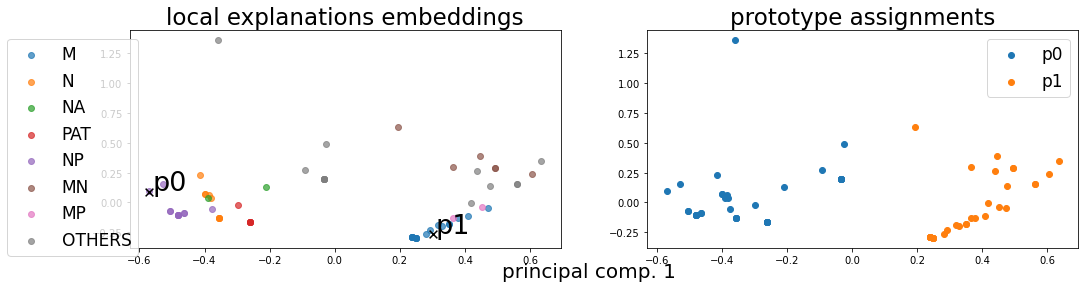

Alpha norms:
tensor([[1.0000, 0.5746],
        [0.4117, 1.0000]], grad_fn=<DivBackward0>)
Concept Purity: 0.447964 +- 0.140271
Concept distribution:  (array([0, 1], dtype=int64), array([39, 34], dtype=int64))
Logic formulas:
For class 0:
0.8767123287671232 (feature000)
For class 1:
0.8767123287671232 (feature001)
Accuracy as classifier:  0.8767
LEN fidelity:  tensor(0.8767)

num_proto:  4 Fidelity: tensor(0.8904)
(array([0., 1., 2., 3., 4., 5., 6., 7.], dtype=float32), array([20,  9,  2,  7, 12,  6,  2, 15], dtype=int64))


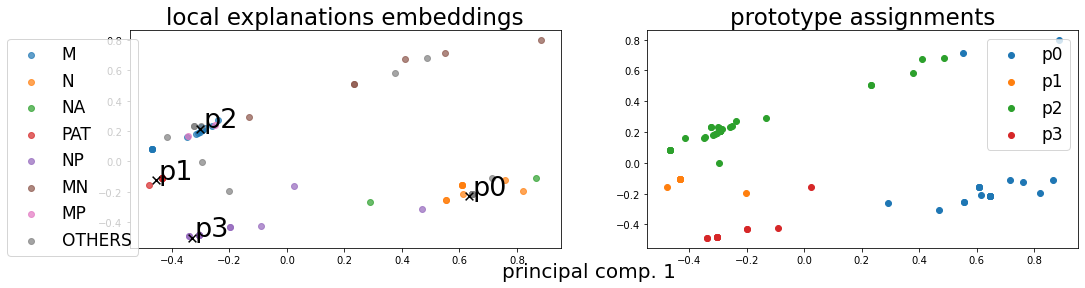

Alpha norms:
tensor([[0.5024, 0.3717, 0.8615, 1.0000],
        [1.0000, 0.2749, 0.4986, 0.7796]], grad_fn=<DivBackward0>)
Concept Purity: 0.727408 +- 0.223673
Concept distribution:  (array([0, 1, 2, 3], dtype=int64), array([21,  8, 33, 11], dtype=int64))
Logic formulas:
For class 0:
0.8904109589041096 (feature000) | ((feature001) | (feature003)
For class 1:
0.8904109589041096 (feature002)
Accuracy as classifier:  0.8904
LEN fidelity:  tensor(0.8904)

num_proto:  6 Fidelity: tensor(0.8904)
(array([0., 1., 2., 3., 4., 5., 6., 7.], dtype=float32), array([20,  9,  2,  7, 12,  6,  2, 15], dtype=int64))


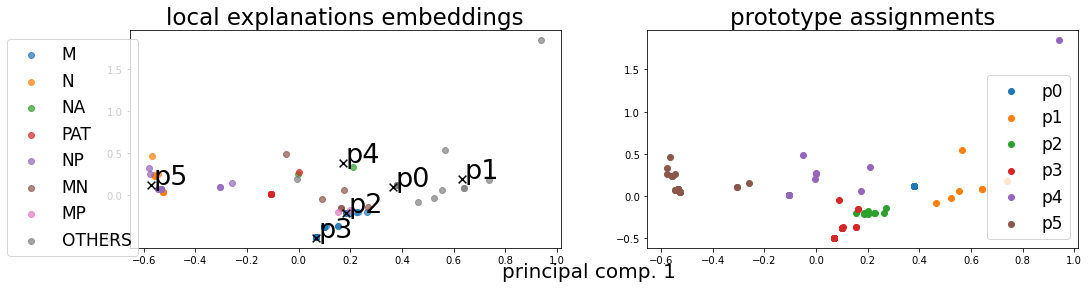

Alpha norms:
tensor([[0.5683, 0.3107, 0.6339, 0.6410, 0.3206, 1.0000],
        [0.2844, 0.2386, 0.6522, 0.6842, 0.3422, 1.0000]],
       grad_fn=<DivBackward0>)
Concept Purity: 0.766681 +- 0.188112
Concept distribution:  (array([0, 1, 2, 3, 4, 5], dtype=int64), array([ 6,  7,  9, 17, 13, 21], dtype=int64))
Logic formulas:
For class 0:
0.8904109589041096 (feature005) | (feature004) | (feature000)
For class 1:
0.8904109589041096 (feature002) | (feature003) | ((feature001)
Accuracy as classifier:  0.8904
LEN fidelity:  tensor(0.8904)

num_proto:  8 Fidelity: tensor(0.8767)
(array([0., 1., 2., 3., 4., 5., 6., 7.], dtype=float32), array([20,  9,  2,  7, 12,  6,  2, 15], dtype=int64))


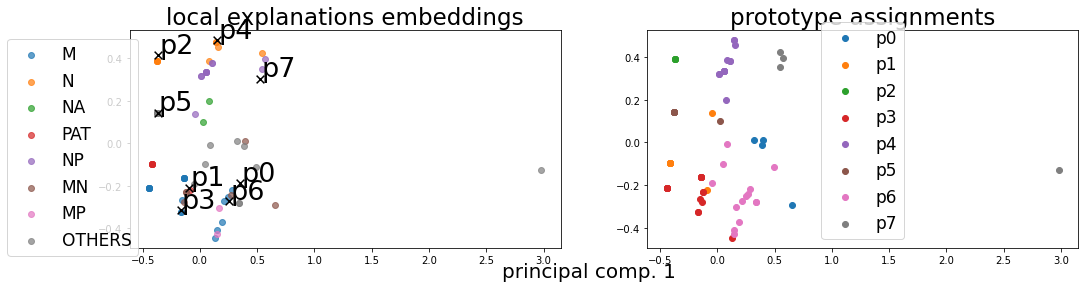

Alpha norms:
tensor([[0.2561, 0.3404, 0.4173, 0.7751, 0.6357, 0.3484, 1.0000, 0.5605],
        [0.1771, 0.3778, 0.3445, 0.4614, 0.5896, 0.3291, 1.0000, 0.8917]],
       grad_fn=<DivBackward0>)
Concept Purity: 0.704613 +- 0.199958
Concept distribution:  (array([0, 1, 2, 3, 4, 5, 6, 7], dtype=int64), array([ 4,  8,  4, 18, 14,  7, 14,  4], dtype=int64))
Logic formulas:
For class 0:
0.8767123287671232 (feature007) | (feature002) | (feature001) | (feature004) | (feature005) | ((feature000)
For class 1:
0.8767123287671232 (feature006) | (feature003)
Accuracy as classifier:  0.8767
LEN fidelity:  tensor(0.8767)



In [17]:
metrics = []
for num_p in [2, 4, 6, 8]:
    with open(f'../logs/model_focal_num_proto_{num_p}_ETN.pkl', 'rb') as handle:
        uno = pickle.load(handle)
        del uno.dataloader
        del uno.val_dataloader
        metrics.append(uno)
        print("num_proto: ", num_p, "Fidelity:", uno.val_metrics[uno.early_stopping.best_epoch-1]["acc_overall"])
        uno.inspect_embedding(val_group_loader)

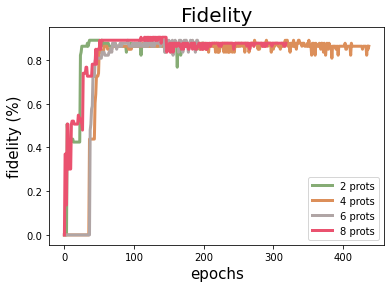

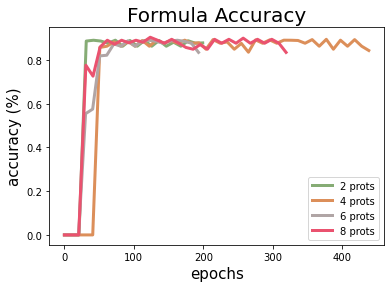

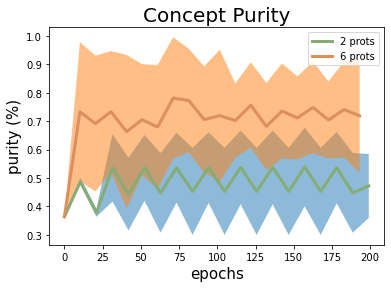

In [16]:
cs = ["#86ac75", "#dc8f5a", "#b0a5a5", "#ea526f", "blue", "red", "black", "purple"]

c = 0
for i , m in enumerate(metrics):
    #if i % 2 == 1: continue
    plt.plot([e["acc_overall"] for e in m.val_metrics], label=f"{m.hyper['num_prototypes']} prots", linewidth=3, color=cs[c])
    c += 1
plt.legend()
plt.title("Fidelity", size=20)
plt.xlabel("epochs", size=15)
plt.ylabel("fidelity (%)", size=15)
plt.show()

c = 0
for i , m in enumerate(metrics):
    #if i % 2 == 1: continue
    plt.plot(np.linspace(0, len([e["acc_overall"] for e in m.val_metrics]), num=len([e["logic_acc_clf"] for e in m.val_logic_metrics])), [e["logic_acc_clf"] for e in m.val_logic_metrics], label=f"{m.hyper['num_prototypes']} prots", linewidth=3, color=cs[c])
    c += 1
plt.legend()
plt.title("Formula Accuracy", size=20)
plt.xlabel("epochs", size=15)
plt.ylabel("accuracy (%)", size=15)
plt.show()

c = 0
for i , m in enumerate(metrics):
    if i % 2 == 1: continue
    purity     = np.array([e["concept_purity"] for e in m.val_logic_metrics])
    std_purity = np.array([e["concept_purity_std"] for e in m.val_logic_metrics])
    plt.plot(np.linspace(0, len([e["acc_overall"] for e in m.val_metrics]), num=len(purity)), purity, label=f"{m.hyper['num_prototypes']} prots", linewidth=3, color=cs[c])
    plt.fill_between(np.linspace(0, len([e["acc_overall"] for e in m.val_metrics]), num=len([e["logic_acc_clf"] for e in m.val_logic_metrics])), purity-std_purity, purity+std_purity, alpha=0.5)
    c += 1

plt.legend()
plt.title("Concept Purity", size=20)
plt.xlabel("epochs", size=15)
plt.ylabel("purity (%)", size=15)
plt.show()